### 1) **DATA COLLECTION** 

In [149]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

###  **UnderStat Dependencies**

In [ ]:
pip install pandas numpy aiohttp understat


In [ ]:

import asyncio
from understat import Understat
import aiohttp

async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        data = await understat.get_league_players("epl", 2023)
        print("Number of players:", len(data))


await main()


### Extracting Data from UnderStat

In [25]:
import pandas as pd
import aiohttp
import asyncio
from understat import Understat

def normalize_understat_shots(shots, league, season):
    """Normalize Understat shots data to match expected format"""
    df = pd.DataFrame(shots)
    if df.empty:
        return df
    
    # Convert numeric columns
    df["xG"] = pd.to_numeric(df["xG"], errors="coerce")
    df["minute"] = pd.to_numeric(df["minute"], errors="coerce")
    df["X"] = pd.to_numeric(df["X"], errors="coerce")
    df["Y"] = pd.to_numeric(df["Y"], errors="coerce")
    
    # Create normalized DataFrame
    df_out = pd.DataFrame({
        "goal": df["result"].apply(lambda r: 1 if r == "Goal" else 0),
        "understat_xg": df["xG"],  
        "minute": df["minute"],
        "second": 0,  
        "possession": None,  
        "play_pattern": df["situation"], 
        "possession_team": None,  
        "team": df["h_team"].where(df["h_a"] == "h", df["a_team"]),
        "player": df["player"], 
        "shot_body_part": df["shotType"], 
        "shot_technique": None, 
        "shot_type": df["situation"], 
        "under_pressure": None, 
        "shot_outcome": df["result"], 
        "x": df["X"], 
        "y": df["Y"], 
        "competition": f"{league} {season}", 
        "off_camera": None
    })
    return df_out

async def fetch_league_shots(league: str, season: int):
    """Fetch all shots for a league and season using RESULTS instead of fixtures"""
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        leagueshots = []
        
        try:
            print(f"📡 Fetching RESULTS for {league} {season}...")
            
            # FIX: Use get_league_results instead of get_league_fixtures
            results = await understat.get_league_results(
                league_name=league.lower(), 
                season=str(season)
            )
            
            print(f"   Found {len(results)} completed matches")
            
            if not results:
                print(f"⚠️  No results found for {league} {season}")
                return pd.DataFrame()
            
            # Process each completed match
            for i, match in enumerate(results):
                match_id = match.get('id')
                if not match_id:
                    continue
                    
                try:
                    if i % 50 == 0:  # Print progress every 50 matches
                        print(f"   Processing match {i+1}/{len(results)}: {match_id}")
                    
                    # Get match shots data
                    shots_data = await understat.get_match_shots(match_id=int(match_id))
                    
                    # Handle the shots data structure correctly
                    if isinstance(shots_data, dict):
                        for team_name, team_shots in shots_data.items():
                            if team_shots and len(team_shots) > 0:
                                norm_df = normalize_understat_shots(team_shots, league, season)
                                if not norm_df.empty:
                                    leagueshots.append(norm_df)
                    elif isinstance(shots_data, list) and shots_data:
                        norm_df = normalize_understat_shots(shots_data, league, season)
                        if not norm_df.empty:
                            leagueshots.append(norm_df)
                            
                    # Small delay to avoid overwhelming the API
                    await asyncio.sleep(0.1)
                            
                except Exception as e:
                    print(f"⚠️  Error fetching match {match_id}: {str(e)}")
                    continue
                    
        except Exception as e:
            print(f"❌ Error fetching results for {league} {season}: {str(e)}")
            return pd.DataFrame()
        
        # Combine all shots
        if leagueshots:
            combined_df = pd.concat(leagueshots, ignore_index=True)
            print(f"✅ Successfully collected {len(combined_df)} shots for {league} {season}")
            return combined_df
        else:
            print(f"⚠️  No shots data collected for {league} {season}")
            return pd.DataFrame()

async def fetch_multi_leagues(leagues, seasons):
    """Fetch shots data for multiple leagues and seasons"""
    all_data = []
    
    for league in leagues:
        for season in seasons:
            print(f"\n🔄 Fetching {league} {season}...")
            df = await fetch_league_shots(league, season)
            print(f"   → Collected {len(df)} shots")
            
            if not df.empty:
                all_data.append(df)
            
            # Add delay between different seasons/leagues
            await asyncio.sleep(1)
    
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()

async def main():
    # Use lowercase league codes and try older seasons first
    leagues = ["epl","la_liga","bundesliga","serie_a", "ligue_1"]
    seasons = list(range(2018, 2021))  # Try older seasons that are more likely to work
    
    print("🚀 Starting data collection...")
    df_all = await fetch_multi_leagues(leagues, seasons)
    
    print(f"\n📊 TOTAL SHOTS COLLECTED: {len(df_all)}")
    
    if not df_all.empty:
        # Save to CSV
        df_all.to_csv("understat_shots_2018_2020.csv", index=False)
        print("💾 Data saved to understat_shots_2018_2020.csv")
        
        # Show sample
        print("\n📋 Sample of collected data:")
        print(df_all.head())
        print(f"\nColumns: {list(df_all.columns)}")
    else:
        print("❌ No data collected. Try the alternative solution below.")

# Run the code
await main()


🚀 Starting data collection...

🔄 Fetching serie_a 2018...
📡 Fetching RESULTS for serie_a 2018...
   Found 380 completed matches
   Processing match 1/380: 9577
   Processing match 51/380: 9636
   Processing match 101/380: 9683
   Processing match 151/380: 9733
   Processing match 201/380: 9780
   Processing match 251/380: 9832
   Processing match 301/380: 9886
   Processing match 351/380: 9930
✅ Successfully collected 10587 shots for serie_a 2018
   → Collected 10587 shots

🔄 Fetching serie_a 2019...
📡 Fetching RESULTS for serie_a 2019...
   Found 380 completed matches
   Processing match 1/380: 13089
   Processing match 51/380: 13140
   Processing match 101/380: 13190
   Processing match 151/380: 13247
   Processing match 201/380: 13296
   Processing match 251/380: 13345
   Processing match 301/380: 13393
   Processing match 351/380: 13440
✅ Successfully collected 10898 shots for serie_a 2019
   → Collected 10898 shots

🔄 Fetching serie_a 2020...
📡 Fetching RESULTS for serie_a 2020...

### 2) **Data Preprocessing**

In [203]:
# got data in 2 different csv files
# so concating them into 1 master csv 


import pandas as pd 

# paths to 3 CSVs
csv1 = "EPL,La-Liga,Bundesliga_understat_shots_2018_2020.csv"
csv2 = "Seria-A,Ligue-1_understat_shots_2018_2020.csv"

# read them
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)


# combine (stack on top of each other)
df_understat = pd.concat([df1, df2], ignore_index=True)

# drop duplicates if overlap exists
df_understat.drop_duplicates(inplace=True)

# check shape
print("Total samples:", len(df_understat))

# save combined dataset
df_understat.to_csv("global_shots_combined.csv", index=False)



Total samples: 141269


In [204]:
df_understat.head()

,goal,shot_statsbomb_xg,minute,second,possession,play_pattern,possession_team,team,player,shot_body_part,shot_technique,shot_type,under_pressure,shot_outcome,x,y,competition,off_camera
0,0,0.039962,1,0,NaN,OpenPlay,NaN,Manchester United,Alexis Sánchez,RightFoot,NaN,OpenPlay,NaN,BlockedShot,0.863,0.711,epl 2018,NaN
1,1,0.761169,2,0,NaN,Penalty,NaN,Manchester United,Paul Pogba,RightFoot,NaN,Penalty,NaN,Goal,0.885,0.500,epl 2018,NaN
2,0,0.018396,39,0,NaN,OpenPlay,NaN,Manchester United,Paul Pogba,RightFoot,NaN,OpenPlay,NaN,SavedShot,0.724,0.655,epl 2018,NaN
3,0,0.081215,40,0,NaN,OpenPlay,NaN,Manchester United,Luke Shaw,RightFoot,NaN,OpenPlay,NaN,SavedShot,0.880,0.653,epl 2018,NaN
4,0,0.028309,55,0,NaN,OpenPlay,NaN,Manchester United,Matteo Darmian,RightFoot,NaN,OpenPlay,NaN,SavedShot,0.781,0.330,epl 2018,NaN


In [205]:
df_understat.shape

(141269, 18)

In [206]:
df_understat["shot_technique"].isna().sum()

np.int64(141269)

In [207]:
df_understat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141269 entries, 0 to 142203
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   goal               141269 non-null  int64  
 1   shot_statsbomb_xg  141269 non-null  float64
 2   minute             141269 non-null  int64  
 3   second             141269 non-null  int64  
 4   possession         0 non-null       float64
 5   play_pattern       141269 non-null  object 
 6   possession_team    0 non-null       float64
 7   team               141269 non-null  object 
 8   player             141269 non-null  object 
 9   shot_body_part     141269 non-null  object 
 10  shot_technique     0 non-null       float64
 11  shot_type          141269 non-null  object 
 12  under_pressure     0 non-null       float64
 13  shot_outcome       141269 non-null  object 
 14  x                  141269 non-null  float64
 15  y                  141269 non-null  float64
 16  competi

In [208]:
df_understat["player"].unique()

array(['Alexis Sánchez', 'Paul Pogba', 'Luke Shaw', ..., 'Yanis Lhéry',
       'Wilitty Younoussa', 'Erwan Belhadji'], shape=(3316,), dtype=object)

In [53]:
df_player_names = pd.DataFrame(df_understat["player"].unique(), columns=["player"])
df_player_names.to_csv("player_names.csv", index=False)



In [76]:
df_player_names

,player
0,Alexis Sánchez
1,Paul Pogba
2,Luke Shaw
3,Matteo Darmian
4,Juan Mata
...,...
3311,Jacques Siwe
3312,Saidou Sow
3313,Yanis Lhéry
3314,Wilitty Younoussa


In [77]:
df_player_names.nunique()

player    3316
dtype: int64

In [11]:
df_player_names.to_csv("player_names")

In [12]:
df_player_names.to_excel("player_names.xlsx", index=False)


In [13]:
df_player_names

,player
0,Alexis Sánchez
1,Paul Pogba
2,Luke Shaw
3,Matteo Darmian
4,Juan Mata
...,...
3311,Jacques Siwe
3312,Saidou Sow
3313,Yanis Lhéry
3314,Wilitty Younoussa


In [14]:
df_player_names.columns

Index(['player'], dtype='object')

### *Handling missing values*

In [209]:
df_understat.isna().sum().sort_values(ascending=False)


possession_team      141269
possession           141269
off_camera           141269
shot_technique       141269
under_pressure       141269
goal                      0
shot_statsbomb_xg         0
play_pattern              0
second                    0
minute                    0
shot_body_part            0
player                    0
team                      0
shot_type                 0
shot_outcome              0
x                         0
y                         0
competition               0
dtype: int64

### Dropping "shot_outcome" feature 

In [210]:
df_understat.drop(["shot_outcome"],axis=1)

,goal,shot_statsbomb_xg,minute,second,possession,play_pattern,possession_team,team,player,shot_body_part,shot_technique,shot_type,under_pressure,x,y,competition,off_camera
0,0,0.039962,1,0,NaN,OpenPlay,NaN,Manchester United,Alexis Sánchez,RightFoot,NaN,OpenPlay,NaN,0.863,0.711,epl 2018,NaN
1,1,0.761169,2,0,NaN,Penalty,NaN,Manchester United,Paul Pogba,RightFoot,NaN,Penalty,NaN,0.885,0.500,epl 2018,NaN
2,0,0.018396,39,0,NaN,OpenPlay,NaN,Manchester United,Paul Pogba,RightFoot,NaN,OpenPlay,NaN,0.724,0.655,epl 2018,NaN
3,0,0.081215,40,0,NaN,OpenPlay,NaN,Manchester United,Luke Shaw,RightFoot,NaN,OpenPlay,NaN,0.880,0.653,epl 2018,NaN
4,0,0.028309,55,0,NaN,OpenPlay,NaN,Manchester United,Matteo Darmian,RightFoot,NaN,OpenPlay,NaN,0.781,0.330,epl 2018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142199,0,0.039172,19,0,NaN,SetPiece,NaN,Lorient,Trevoh Chalobah,Head,NaN,SetPiece,NaN,0.899,0.511,ligue_1 2020,NaN
142200,1,0.372809,54,0,NaN,SetPiece,NaN,Lorient,Trevoh Chalobah,LeftFoot,NaN,SetPiece,NaN,0.902,0.482,ligue_1 2020,NaN
142201,0,0.009242,70,0,NaN,OpenPlay,NaN,Lorient,Vincent Le Goff,LeftFoot,NaN,OpenPlay,NaN,0.738,0.774,ligue_1 2020,NaN
142202,0,0.045374,72,0,NaN,OpenPlay,NaN,Lorient,Enzo Le Fée,Head,NaN,OpenPlay,NaN,0.882,0.543,ligue_1 2020,NaN


### can see first 5 columns here : off_camera,under_pressure,...... have a very large amount of entries missing , so extracting any insight from these is not feasible , so I am dropping these columns 

In [211]:
df_understat.drop(["off_camera","under_pressure","shot_technique","possession","possession_team"],axis=1,inplace=True)

In [212]:
df_understat.head()

,goal,shot_statsbomb_xg,minute,second,play_pattern,team,player,shot_body_part,shot_type,shot_outcome,x,y,competition
0,0,0.039962,1,0,OpenPlay,Manchester United,Alexis Sánchez,RightFoot,OpenPlay,BlockedShot,0.863,0.711,epl 2018
1,1,0.761169,2,0,Penalty,Manchester United,Paul Pogba,RightFoot,Penalty,Goal,0.885,0.500,epl 2018
2,0,0.018396,39,0,OpenPlay,Manchester United,Paul Pogba,RightFoot,OpenPlay,SavedShot,0.724,0.655,epl 2018
3,0,0.081215,40,0,OpenPlay,Manchester United,Luke Shaw,RightFoot,OpenPlay,SavedShot,0.880,0.653,epl 2018
4,0,0.028309,55,0,OpenPlay,Manchester United,Matteo Darmian,RightFoot,OpenPlay,SavedShot,0.781,0.330,epl 2018


In [213]:
df_understat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141269 entries, 0 to 142203
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   goal               141269 non-null  int64  
 1   shot_statsbomb_xg  141269 non-null  float64
 2   minute             141269 non-null  int64  
 3   second             141269 non-null  int64  
 4   play_pattern       141269 non-null  object 
 5   team               141269 non-null  object 
 6   player             141269 non-null  object 
 7   shot_body_part     141269 non-null  object 
 8   shot_type          141269 non-null  object 
 9   shot_outcome       141269 non-null  object 
 10  x                  141269 non-null  float64
 11  y                  141269 non-null  float64
 12  competition        141269 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 15.1+ MB


### checking each column for insights and to make every column consistent 

In [214]:
for i in df_understat.columns:
    print(f" {i} : {df_understat[i].unique()}")

 goal : [0 1]
 shot_statsbomb_xg : [0.0399621  0.76116902 0.0183958  ... 0.00924233 0.0453741  0.0131211 ]
 minute : [  1   2  39  40  55  64  77  82  14  24  28  31  49  74  76  88  89  90
  91  94   3  10  27  34  38  46  59  61  63  75  84  86   5   7  17  36
  37  56  70  80   8  11  13  16  26  47  48  53  68  83  20  32  44  19
  25  71  72  33  57  79  12  60  78  29  43  52  62  92  23  81  66  67
  21  65  58  15  41  69  85   4  22  45  18  35  87  93   9  50  95  42
  54   0  73  51   6  30 101  96  97  99  98 104 102 103 100]
 second : [0]
 play_pattern : ['OpenPlay' 'Penalty' 'FromCorner' 'DirectFreekick' 'SetPiece']
 team : ['Manchester United' 'Leicester' 'Newcastle United' 'Tottenham' 'Watford'
 'Brighton' 'Huddersfield' 'Chelsea' 'Fulham' 'Crystal Palace'
 'Bournemouth' 'Cardiff' 'Wolverhampton Wanderers' 'Everton' 'Southampton'
 'Burnley' 'Liverpool' 'West Ham' 'Arsenal' 'Manchester City' 'Norwich'
 'Sheffield United' 'Aston Villa' 'Leeds' 'West Bromwich Albion' 'Giro

### we do not need  competition's name or team's name for making our (general) context-based global xG model to estimate the average chance of any player/team scoring from a given shot situation

In [215]:
df_understat.drop(["team","competition"],axis=1,inplace=True)

In [216]:
df_understat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141269 entries, 0 to 142203
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   goal               141269 non-null  int64  
 1   shot_statsbomb_xg  141269 non-null  float64
 2   minute             141269 non-null  int64  
 3   second             141269 non-null  int64  
 4   play_pattern       141269 non-null  object 
 5   player             141269 non-null  object 
 6   shot_body_part     141269 non-null  object 
 7   shot_type          141269 non-null  object 
 8   shot_outcome       141269 non-null  object 
 9   x                  141269 non-null  float64
 10  y                  141269 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 12.9+ MB


In [217]:
# after adjusting the shot outcome 

for i in df_understat.columns:
    print(f" {i} : {df_understat[i].unique()}")

 goal : [0 1]
 shot_statsbomb_xg : [0.0399621  0.76116902 0.0183958  ... 0.00924233 0.0453741  0.0131211 ]
 minute : [  1   2  39  40  55  64  77  82  14  24  28  31  49  74  76  88  89  90
  91  94   3  10  27  34  38  46  59  61  63  75  84  86   5   7  17  36
  37  56  70  80   8  11  13  16  26  47  48  53  68  83  20  32  44  19
  25  71  72  33  57  79  12  60  78  29  43  52  62  92  23  81  66  67
  21  65  58  15  41  69  85   4  22  45  18  35  87  93   9  50  95  42
  54   0  73  51   6  30 101  96  97  99  98 104 102 103 100]
 second : [0]
 play_pattern : ['OpenPlay' 'Penalty' 'FromCorner' 'DirectFreekick' 'SetPiece']
 player : ['Alexis Sánchez' 'Paul Pogba' 'Luke Shaw' ... 'Yanis Lhéry'
 'Wilitty Younoussa' 'Erwan Belhadji']
 shot_body_part : ['RightFoot' 'LeftFoot' 'Head' 'OtherBodyPart']
 shot_type : ['OpenPlay' 'Penalty' 'FromCorner' 'DirectFreekick' 'SetPiece']
 shot_outcome : ['BlockedShot' 'Goal' 'SavedShot' 'MissedShots' 'ShotOnPost' 'OwnGoal']
 x : [0.86300003 0.88

### Calculating Distances and Angles

In [218]:
import numpy as np

# Get pitch size from data
pitch_length = df_understat["x"].max()
pitch_width = df_understat["y"].max()

# Scale StatsBomb 120x80 → FIFA 105x68
df_understat["x_m"] = df_understat["x"] * (105 / pitch_length)
df_understat["y_m"] = df_understat["y"] * (68 / pitch_width)

# Goal dimensions (centered at y=34)
goal_x = 105
goal_y_center = 68 / 2
goal_y_top = goal_y_center + 7.32 / 2
goal_y_bottom = goal_y_center - 7.32 / 2

# ---- Distance to goal ----
df_understat["distance_to_goal"] = np.sqrt(
    (goal_x - df_understat["x_m"])**2 + (goal_y_center - df_understat["y_m"])**2
)

# Clip distances to max half-pitch (~60m) just for safety
df_understat["distance_to_goal"] = df_understat["distance_to_goal"].clip(0, 60)

# ---- Angle to goal (open angle between posts) ----
df_understat["angle_to_goal"] = np.abs(
    np.arctan2(df_understat["y_m"] - goal_y_bottom, goal_x - df_understat["x_m"]) -
    np.arctan2(df_understat["y_m"] - goal_y_top, goal_x - df_understat["x_m"])
)

# Clip to [0, π] radians
df_understat["angle_to_goal"] = df_understat["angle_to_goal"].clip(0, np.pi)

# Convert to degrees
df_understat["angle_to_goal_deg"] = np.degrees(df_understat["angle_to_goal"])

# Clip degrees between 0–180 for visualization sanity
df_understat["angle_to_goal_deg"] = df_understat["angle_to_goal_deg"].clip(0, 180)

print(df_understat[["x", "y", "x_m", "y_m", "distance_to_goal", "angle_to_goal_deg"]].head())


       x      y        x_m        y_m  distance_to_goal  angle_to_goal_deg
0  0.863  0.711  90.705708  48.590954         20.426031          14.526252
1  0.885  0.500  93.018017  34.170854         11.983201          33.965533
2  0.724  0.655  76.096097  44.763819         30.843078          12.712308
3  0.880  0.653  92.492491  44.627138         16.412612          19.680453
4  0.781  0.330  82.087084  22.552764         25.613296          14.627213


In [219]:
df_understat.head()

,goal,shot_statsbomb_xg,minute,second,play_pattern,player,shot_body_part,shot_type,shot_outcome,x,y,x_m,y_m,distance_to_goal,angle_to_goal,angle_to_goal_deg
0,0,0.039962,1,0,OpenPlay,Alexis Sánchez,RightFoot,OpenPlay,BlockedShot,0.863,0.711,90.705708,48.590954,20.426031,0.253531,14.526252
1,1,0.761169,2,0,Penalty,Paul Pogba,RightFoot,Penalty,Goal,0.885,0.500,93.018017,34.170854,11.983201,0.592810,33.965533
2,0,0.018396,39,0,OpenPlay,Paul Pogba,RightFoot,OpenPlay,SavedShot,0.724,0.655,76.096097,44.763819,30.843078,0.221872,12.712308
3,0,0.081215,40,0,OpenPlay,Luke Shaw,RightFoot,OpenPlay,SavedShot,0.880,0.653,92.492491,44.627138,16.412612,0.343489,19.680453
4,0,0.028309,55,0,OpenPlay,Matteo Darmian,RightFoot,OpenPlay,SavedShot,0.781,0.330,82.087084,22.552764,25.613296,0.255293,14.627213


### Visulaizations for Distances and Angles

In [220]:
print(df_understat["distance_to_goal"].describe())
print(df_understat["angle_to_goal_deg"].describe())

count    141269.000000
mean         18.149131
std           8.367403
min           0.318441
25%          11.744941
50%          16.758866
75%          24.739145
max          60.000000
Name: distance_to_goal, dtype: float64
count    141269.000000
mean         25.050422
std          15.460688
min           0.000000
25%          14.705569
50%          19.807997
75%          31.197594
max         180.000000
Name: angle_to_goal_deg, dtype: float64


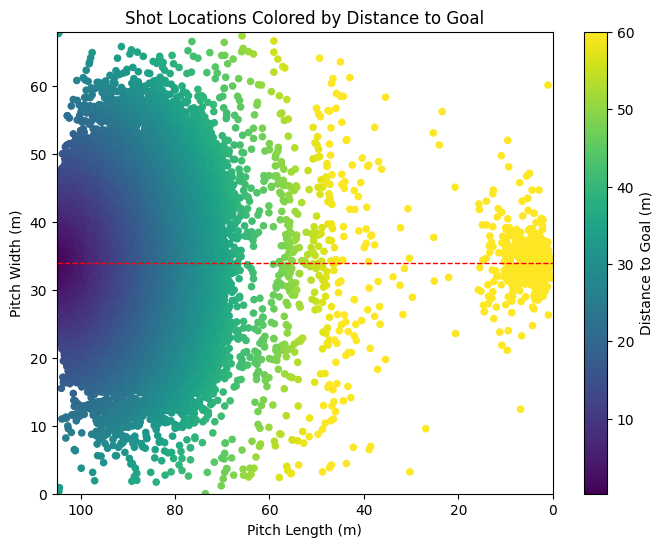

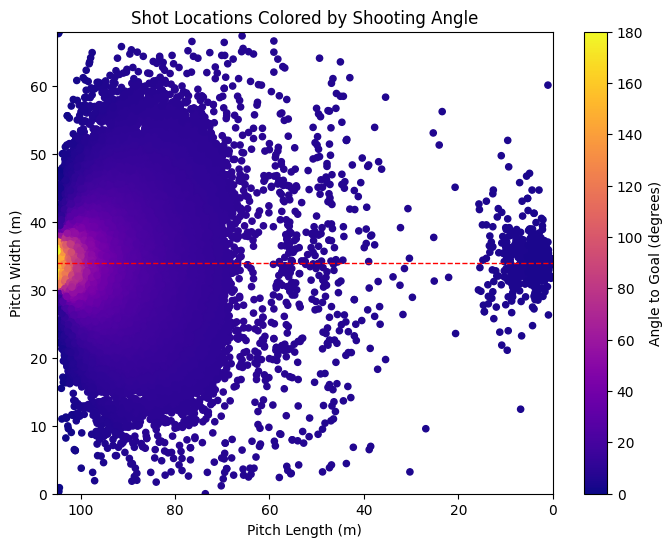

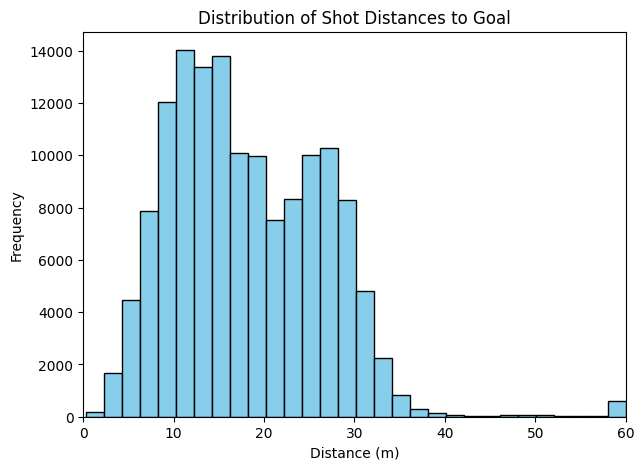

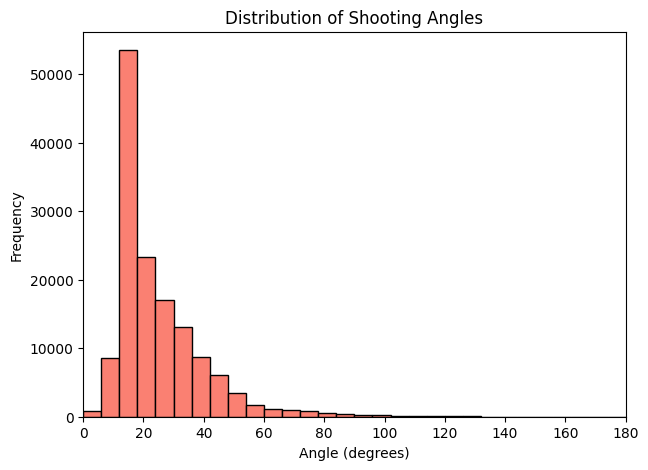

In [221]:
import matplotlib.pyplot as plt

# ---- Scatter: Distance to Goal ----
plt.figure(figsize=(8,6))
sc1 = plt.scatter(
    df_understat["x_m"], df_understat["y_m"], 
    c=df_understat["distance_to_goal"], cmap="viridis", s=20
)
plt.colorbar(sc1, label="Distance to Goal (m)")
plt.axhline(34, color="red", linestyle="--", linewidth=1)  # goal line
plt.title("Shot Locations Colored by Distance to Goal")
plt.xlabel("Pitch Length (m)")
plt.ylabel("Pitch Width (m)")
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.gca().invert_xaxis()   # flip pitch so goal is on the right
plt.show()

# ---- Scatter: Angle to Goal ----
plt.figure(figsize=(8,6))
sc2 = plt.scatter(
    df_understat["x_m"], df_understat["y_m"], 
    c=df_understat["angle_to_goal_deg"], cmap="plasma", s=20
)
plt.colorbar(sc2, label="Angle to Goal (degrees)")
plt.axhline(34, color="red", linestyle="--", linewidth=1)
plt.title("Shot Locations Colored by Shooting Angle")
plt.xlabel("Pitch Length (m)")
plt.ylabel("Pitch Width (m)")
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.gca().invert_xaxis()
plt.show()

# ---- Histogram: Distance ----
plt.figure(figsize=(7,5))
plt.hist(df_understat["distance_to_goal"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Shot Distances to Goal")
plt.xlabel("Distance (m)")
plt.ylabel("Frequency")
plt.xlim(0, 60)   # max distance ~60m
plt.show()

# ---- Histogram: Angle ----
plt.figure(figsize=(7,5))
plt.hist(df_understat["angle_to_goal_deg"], bins=30, color="salmon", edgecolor="black")
plt.title("Distribution of Shooting Angles")
plt.xlabel("Angle (degrees)")
plt.ylabel("Frequency")
plt.xlim(0, 180)  # angles between 0°–180°
plt.show()


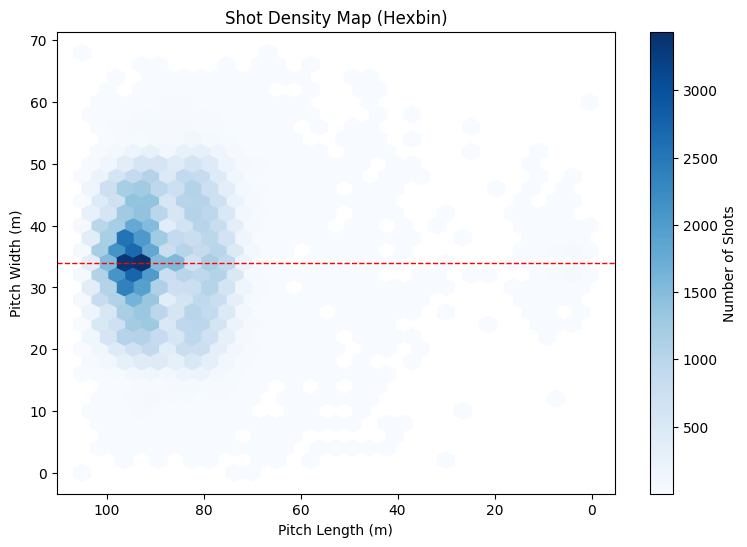

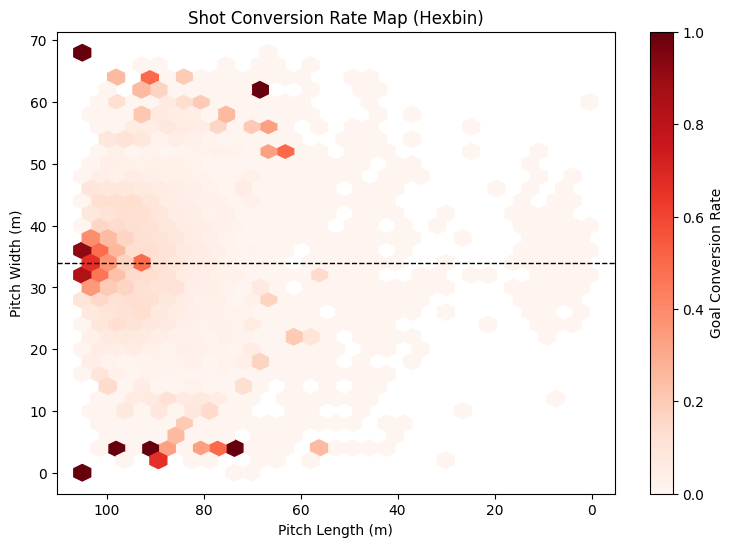

In [222]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Hexbin heatmap: Shot density ----
plt.figure(figsize=(9,6))
hb = plt.hexbin(df_understat["x_m"], df_understat["y_m"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(hb, label="Number of Shots")
plt.axhline(34, color="red", linestyle="--", linewidth=1)
plt.title("Shot Density Map (Hexbin)")
plt.xlabel("Pitch Length (m)")
plt.ylabel("Pitch Width (m)")
plt.gca().invert_xaxis()
plt.show()

# ---- Hexbin weighted by goal outcome ----
plt.figure(figsize=(9,6))
hb = plt.hexbin(
    df_understat["x_m"], df_understat["y_m"], 
    C=df_understat["goal"], 
    reduce_C_function=np.mean, 
    gridsize=30, 
    cmap="Reds", 
    mincnt=1
)
plt.colorbar(hb, label="Goal Conversion Rate")
plt.axhline(34, color="black", linestyle="--", linewidth=1)
plt.title("Shot Conversion Rate Map (Hexbin)")
plt.xlabel("Pitch Length (m)")
plt.ylabel("Pitch Width (m)")
plt.gca().invert_xaxis()
plt.show()


In [223]:
# after adjusting the shot outcome 

for i in df_understat.columns:
    print(f" {i} : {df_understat[i].unique()}")

 goal : [0 1]
 shot_statsbomb_xg : [0.0399621  0.76116902 0.0183958  ... 0.00924233 0.0453741  0.0131211 ]
 minute : [  1   2  39  40  55  64  77  82  14  24  28  31  49  74  76  88  89  90
  91  94   3  10  27  34  38  46  59  61  63  75  84  86   5   7  17  36
  37  56  70  80   8  11  13  16  26  47  48  53  68  83  20  32  44  19
  25  71  72  33  57  79  12  60  78  29  43  52  62  92  23  81  66  67
  21  65  58  15  41  69  85   4  22  45  18  35  87  93   9  50  95  42
  54   0  73  51   6  30 101  96  97  99  98 104 102 103 100]
 second : [0]
 play_pattern : ['OpenPlay' 'Penalty' 'FromCorner' 'DirectFreekick' 'SetPiece']
 player : ['Alexis Sánchez' 'Paul Pogba' 'Luke Shaw' ... 'Yanis Lhéry'
 'Wilitty Younoussa' 'Erwan Belhadji']
 shot_body_part : ['RightFoot' 'LeftFoot' 'Head' 'OtherBodyPart']
 shot_type : ['OpenPlay' 'Penalty' 'FromCorner' 'DirectFreekick' 'SetPiece']
 shot_outcome : ['BlockedShot' 'Goal' 'SavedShot' 'MissedShots' 'ShotOnPost' 'OwnGoal']
 x : [0.86300003 0.88

### Recreating the master dataframe 

In [224]:
# after adjusting the shot outcome 

for i in df_understat.columns:
    print(f" {i} : {df_understat[i].unique()}")

 goal : [0 1]
 shot_statsbomb_xg : [0.0399621  0.76116902 0.0183958  ... 0.00924233 0.0453741  0.0131211 ]
 minute : [  1   2  39  40  55  64  77  82  14  24  28  31  49  74  76  88  89  90
  91  94   3  10  27  34  38  46  59  61  63  75  84  86   5   7  17  36
  37  56  70  80   8  11  13  16  26  47  48  53  68  83  20  32  44  19
  25  71  72  33  57  79  12  60  78  29  43  52  62  92  23  81  66  67
  21  65  58  15  41  69  85   4  22  45  18  35  87  93   9  50  95  42
  54   0  73  51   6  30 101  96  97  99  98 104 102 103 100]
 second : [0]
 play_pattern : ['OpenPlay' 'Penalty' 'FromCorner' 'DirectFreekick' 'SetPiece']
 player : ['Alexis Sánchez' 'Paul Pogba' 'Luke Shaw' ... 'Yanis Lhéry'
 'Wilitty Younoussa' 'Erwan Belhadji']
 shot_body_part : ['RightFoot' 'LeftFoot' 'Head' 'OtherBodyPart']
 shot_type : ['OpenPlay' 'Penalty' 'FromCorner' 'DirectFreekick' 'SetPiece']
 shot_outcome : ['BlockedShot' 'Goal' 'SavedShot' 'MissedShots' 'ShotOnPost' 'OwnGoal']
 x : [0.86300003 0.88

In [225]:
df_understat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141269 entries, 0 to 142203
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   goal               141269 non-null  int64  
 1   shot_statsbomb_xg  141269 non-null  float64
 2   minute             141269 non-null  int64  
 3   second             141269 non-null  int64  
 4   play_pattern       141269 non-null  object 
 5   player             141269 non-null  object 
 6   shot_body_part     141269 non-null  object 
 7   shot_type          141269 non-null  object 
 8   shot_outcome       141269 non-null  object 
 9   x                  141269 non-null  float64
 10  y                  141269 non-null  float64
 11  x_m                141269 non-null  float64
 12  y_m                141269 non-null  float64
 13  distance_to_goal   141269 non-null  float64
 14  angle_to_goal      141269 non-null  float64
 15  angle_to_goal_deg  141269 non-null  float64
dtypes: floa

In [226]:
df_understat.drop(["shot_outcome"],axis=1, inplace=True)

In [227]:
df_understat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141269 entries, 0 to 142203
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   goal               141269 non-null  int64  
 1   shot_statsbomb_xg  141269 non-null  float64
 2   minute             141269 non-null  int64  
 3   second             141269 non-null  int64  
 4   play_pattern       141269 non-null  object 
 5   player             141269 non-null  object 
 6   shot_body_part     141269 non-null  object 
 7   shot_type          141269 non-null  object 
 8   x                  141269 non-null  float64
 9   y                  141269 non-null  float64
 10  x_m                141269 non-null  float64
 11  y_m                141269 non-null  float64
 12  distance_to_goal   141269 non-null  float64
 13  angle_to_goal      141269 non-null  float64
 14  angle_to_goal_deg  141269 non-null  float64
dtypes: float64(8), int64(3), object(4)
memory usage: 17.2+ M

In [228]:
df_understat

,goal,shot_statsbomb_xg,minute,second,play_pattern,player,shot_body_part,shot_type,x,y,x_m,y_m,distance_to_goal,angle_to_goal,angle_to_goal_deg
0,0,0.039962,1,0,OpenPlay,Alexis Sánchez,RightFoot,OpenPlay,0.863,0.711,90.705708,48.590954,20.426031,0.253531,14.526252
1,1,0.761169,2,0,Penalty,Paul Pogba,RightFoot,Penalty,0.885,0.500,93.018017,34.170854,11.983201,0.592810,33.965533
2,0,0.018396,39,0,OpenPlay,Paul Pogba,RightFoot,OpenPlay,0.724,0.655,76.096097,44.763819,30.843078,0.221872,12.712308
3,0,0.081215,40,0,OpenPlay,Luke Shaw,RightFoot,OpenPlay,0.880,0.653,92.492491,44.627138,16.412612,0.343489,19.680453
4,0,0.028309,55,0,OpenPlay,Matteo Darmian,RightFoot,OpenPlay,0.781,0.330,82.087084,22.552764,25.613296,0.255293,14.627213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142199,0,0.039172,19,0,SetPiece,Trevoh Chalobah,Head,SetPiece,0.899,0.511,94.489490,34.922612,10.550926,0.665936,38.155321
142200,1,0.372809,54,0,SetPiece,Trevoh Chalobah,LeftFoot,SetPiece,0.902,0.482,94.804800,32.940704,10.250083,0.683289,39.149580
142201,0,0.009242,70,0,OpenPlay,Vincent Le Goff,LeftFoot,OpenPlay,0.738,0.774,77.567570,52.896483,33.310889,0.181171,10.380351
142202,0,0.045374,72,0,OpenPlay,Enzo Le Fée,Head,OpenPlay,0.882,0.543,92.702698,37.109547,12.684357,0.547952,31.395331


**Further Feature Engineering**

In [229]:
import numpy as np
import pandas as pd

def feature_engineer(df_understat):
    df = df_understat.copy()

    # --- Distance and log transforms ---
    df["distance_to_goal_sq"] = df["distance_to_goal"] ** 2
    df["log_distance"] = np.log1p(df["distance_to_goal"])  # log(1+distance)

    # --- Zonal features (based on x_m, y_m) ---
    def zone_classifier(row):
        if row["distance_to_goal"] <= 18 and abs(row["y_m"]) <= 10:
            return "central_box"
        elif row["distance_to_goal"] <= 18 and row["y_m"] < -10:
            return "wide_left"
        elif row["distance_to_goal"] <= 18 and row["y_m"] > 10:
            return "wide_right"
        else:
            return "outside_box"
    df["zone"] = df.apply(zone_classifier, axis=1)

    # --- Temporal features ---
    df["is_first_half"] = (df["minute"] <= 45).astype(int)
    df["is_extra_time"] = (df["minute"] > 90).astype(int)

    # --- Buckets ---
    df["distance_bucket"] = pd.cut(df["distance_to_goal"],
                                   bins=[0, 10, 20, 30, 40, 60],
                                   labels=["0-10", "10-20", "20-30", "30-40", "40+"])

    df["angle_bucket"] = pd.cut(df["angle_to_goal"],
                                bins=[0, 10, 20, 30, 40, 60, 90],
                                labels=["0-10", "10-20", "20-30", "30-40", "40-60", "60+"])

    # --- Interaction term ---
    df["distance_x_angle"] = df["distance_to_goal"] * df["angle_to_goal"]

    return df


In [230]:
df_understat = feature_engineer(df_understat)


In [231]:
df_understat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141269 entries, 0 to 142203
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   goal                 141269 non-null  int64   
 1   shot_statsbomb_xg    141269 non-null  float64 
 2   minute               141269 non-null  int64   
 3   second               141269 non-null  int64   
 4   play_pattern         141269 non-null  object  
 5   player               141269 non-null  object  
 6   shot_body_part       141269 non-null  object  
 7   shot_type            141269 non-null  object  
 8   x                    141269 non-null  float64 
 9   y                    141269 non-null  float64 
 10  x_m                  141269 non-null  float64 
 11  y_m                  141269 non-null  float64 
 12  distance_to_goal     141269 non-null  float64 
 13  angle_to_goal        141269 non-null  float64 
 14  angle_to_goal_deg    141269 non-null  float64 
 15  dista

In [232]:
df_understat.head()

,goal,shot_statsbomb_xg,minute,second,play_pattern,player,shot_body_part,shot_type,x,y,...,angle_to_goal,angle_to_goal_deg,distance_to_goal_sq,log_distance,zone,is_first_half,is_extra_time,distance_bucket,angle_bucket,distance_x_angle
0,0,0.039962,1,0,OpenPlay,Alexis Sánchez,RightFoot,OpenPlay,0.863,0.711,...,0.253531,14.526252,417.222728,3.064607,outside_box,1,0,20-30,0-10,5.178630
1,1,0.761169,2,0,Penalty,Paul Pogba,RightFoot,Penalty,0.885,0.500,...,0.592810,33.965533,143.597117,2.563656,wide_right,1,0,10-20,0-10,7.103766
2,0,0.018396,39,0,OpenPlay,Paul Pogba,RightFoot,OpenPlay,0.724,0.655,...,0.221872,12.712308,951.295437,3.460820,outside_box,1,0,30-40,0-10,6.843204
3,0,0.081215,40,0,OpenPlay,Luke Shaw,RightFoot,OpenPlay,0.880,0.653,...,0.343489,19.680453,269.373836,2.857195,wide_right,1,0,10-20,0-10,5.637547
4,0,0.028309,55,0,OpenPlay,Matteo Darmian,RightFoot,OpenPlay,0.781,0.330,...,0.255293,14.627213,656.040925,3.281411,outside_box,0,0,20-30,0-10,6.538896


In [233]:
# after adjusting the shot outcome 

for i in df_understat.columns:
    print(f" {i} : {df_understat[i].unique()}")

 goal : [0 1]
 shot_statsbomb_xg : [0.0399621  0.76116902 0.0183958  ... 0.00924233 0.0453741  0.0131211 ]
 minute : [  1   2  39  40  55  64  77  82  14  24  28  31  49  74  76  88  89  90
  91  94   3  10  27  34  38  46  59  61  63  75  84  86   5   7  17  36
  37  56  70  80   8  11  13  16  26  47  48  53  68  83  20  32  44  19
  25  71  72  33  57  79  12  60  78  29  43  52  62  92  23  81  66  67
  21  65  58  15  41  69  85   4  22  45  18  35  87  93   9  50  95  42
  54   0  73  51   6  30 101  96  97  99  98 104 102 103 100]
 second : [0]
 play_pattern : ['OpenPlay' 'Penalty' 'FromCorner' 'DirectFreekick' 'SetPiece']
 player : ['Alexis Sánchez' 'Paul Pogba' 'Luke Shaw' ... 'Yanis Lhéry'
 'Wilitty Younoussa' 'Erwan Belhadji']
 shot_body_part : ['RightFoot' 'LeftFoot' 'Head' 'OtherBodyPart']
 shot_type : ['OpenPlay' 'Penalty' 'FromCorner' 'DirectFreekick' 'SetPiece']
 x : [0.86300003 0.885      0.72400002 0.88       0.78099998 0.81300003
 0.88800003 0.95       0.755      0.7

**one hot encoding**

In [234]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def encode_features(df):
    # Label encode play_pattern
    le_play_pattern = LabelEncoder()
    df['play_pattern_encoded'] = le_play_pattern.fit_transform(df['play_pattern'].astype(str))
    
    # Columns to one-hot encode
    one_hot_columns = ['shot_body_part', 'shot_type', 'zone', 'distance_bucket', 'angle_bucket']
    
    # One-hot encode with drop_first=True to avoid dummy variable trap for logistic regression
    df_one_hot = pd.get_dummies(df[one_hot_columns].astype(str), prefix=one_hot_columns, drop_first=True)
    
    # Concatenate encoded columns to original dataframe
    df_encoded = pd.concat([df, df_one_hot], axis=1)
    
    # Drop original categorical columns
    df_encoded.drop(columns=one_hot_columns + ['play_pattern'], inplace=True)
    
    return df_encoded, le_play_pattern

def safe_label_encode(encoder, values):
    encoded = []
    for v in values:
        if v in encoder.classes_:
            encoded.append(encoder.transform([v])[0])
        else:
            encoded.append(-1)  # Unknown label code for unseen values
    return encoded

# ----------------------
# Usage example with your df_understat
# ----------------------
if __name__ == "__main__":
    # Assuming df_understat is your DataFrame already loaded in memory
    # Example: df_understat = pd.read_csv('your_file.csv')
    
    df_encoded, play_pattern_encoder = encode_features(df_understat)
    
    print("Encoded DataFrame:")
    print(df_encoded.head())
    
    # Example: encode new play_pattern values using saved encoder, handling unseen labels:
    new_play_patterns = ['Set Piece', 'Open Play', 'Unknown Pattern']
    encoded_new = safe_label_encode(play_pattern_encoder, new_play_patterns)
    print("\nEncoded new play_pattern values (with -1 for unknown):", encoded_new)


Encoded DataFrame:
   goal  shot_statsbomb_xg  minute  second          player      x      y  \
0     0           0.039962       1       0  Alexis Sánchez  0.863  0.711   
1     1           0.761169       2       0      Paul Pogba  0.885  0.500   
2     0           0.018396      39       0      Paul Pogba  0.724  0.655   
3     0           0.081215      40       0       Luke Shaw  0.880  0.653   
4     0           0.028309      55       0  Matteo Darmian  0.781  0.330   

         x_m        y_m  distance_to_goal  ...  shot_type_FromCorner  \
0  90.705708  48.590954         20.426031  ...                 False   
1  93.018017  34.170854         11.983201  ...                 False   
2  76.096097  44.763819         30.843078  ...                 False   
3  92.492491  44.627138         16.412612  ...                 False   
4  82.087084  22.552764         25.613296  ...                 False   

   shot_type_OpenPlay  shot_type_Penalty  shot_type_SetPiece  zone_wide_right  \
0         

In [235]:
df_understat

,goal,shot_statsbomb_xg,minute,second,play_pattern,player,shot_body_part,shot_type,x,y,...,angle_to_goal_deg,distance_to_goal_sq,log_distance,zone,is_first_half,is_extra_time,distance_bucket,angle_bucket,distance_x_angle,play_pattern_encoded
0,0,0.039962,1,0,OpenPlay,Alexis Sánchez,RightFoot,OpenPlay,0.863,0.711,...,14.526252,417.222728,3.064607,outside_box,1,0,20-30,0-10,5.178630,2
1,1,0.761169,2,0,Penalty,Paul Pogba,RightFoot,Penalty,0.885,0.500,...,33.965533,143.597117,2.563656,wide_right,1,0,10-20,0-10,7.103766,3
2,0,0.018396,39,0,OpenPlay,Paul Pogba,RightFoot,OpenPlay,0.724,0.655,...,12.712308,951.295437,3.460820,outside_box,1,0,30-40,0-10,6.843204,2
3,0,0.081215,40,0,OpenPlay,Luke Shaw,RightFoot,OpenPlay,0.880,0.653,...,19.680453,269.373836,2.857195,wide_right,1,0,10-20,0-10,5.637547,2
4,0,0.028309,55,0,OpenPlay,Matteo Darmian,RightFoot,OpenPlay,0.781,0.330,...,14.627213,656.040925,3.281411,outside_box,0,0,20-30,0-10,6.538896,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142199,0,0.039172,19,0,SetPiece,Trevoh Chalobah,Head,SetPiece,0.899,0.511,...,38.155321,111.322041,2.446766,wide_right,1,0,10-20,0-10,7.026241,4
142200,1,0.372809,54,0,SetPiece,Trevoh Chalobah,LeftFoot,SetPiece,0.902,0.482,...,39.149580,105.064208,2.420376,wide_right,0,0,10-20,0-10,7.003770,4
142201,0,0.009242,70,0,OpenPlay,Vincent Le Goff,LeftFoot,OpenPlay,0.738,0.774,...,10.380351,1109.615325,3.535463,outside_box,0,0,30-40,0-10,6.034977,2
142202,0,0.045374,72,0,OpenPlay,Enzo Le Fée,Head,OpenPlay,0.882,0.543,...,31.395331,160.892918,2.616253,wide_right,0,0,10-20,0-10,6.950418,2


In [237]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141269 entries, 0 to 142203
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   goal                          141269 non-null  int64  
 1   shot_statsbomb_xg             141269 non-null  float64
 2   minute                        141269 non-null  int64  
 3   second                        141269 non-null  int64  
 4   player                        141269 non-null  object 
 5   x                             141269 non-null  float64
 6   y                             141269 non-null  float64
 7   x_m                           141269 non-null  float64
 8   y_m                           141269 non-null  float64
 9   distance_to_goal              141269 non-null  float64
 10  angle_to_goal                 141269 non-null  float64
 11  angle_to_goal_deg             141269 non-null  float64
 12  distance_to_goal_sq           141269 non-null  fl

In [238]:
df_encoded.to_csv("encoded_data.csv", index=False)



**MODEL MAKING**

In [54]:
encoded_data_with_x_and_y=pd.read_csv("encoded_data.csv")

In [55]:
encoded_data_with_x_and_y.head()

,goal,shot_statsbomb_xg,minute,second,player,x,y,x_m,y_m,distance_to_goal,...,shot_type_FromCorner,shot_type_OpenPlay,shot_type_Penalty,shot_type_SetPiece,zone_wide_right,distance_bucket_10-20,distance_bucket_20-30,distance_bucket_30-40,distance_bucket_40+,angle_bucket_nan
0,0,0.039962,1,0,Alexis Sánchez,0.863,0.711,90.705708,48.590954,20.426031,...,False,True,False,False,False,False,True,False,False,False
1,1,0.761169,2,0,Paul Pogba,0.885,0.500,93.018017,34.170854,11.983201,...,False,False,True,False,True,True,False,False,False,False
2,0,0.018396,39,0,Paul Pogba,0.724,0.655,76.096097,44.763819,30.843078,...,False,True,False,False,False,False,False,True,False,False
3,0,0.081215,40,0,Luke Shaw,0.880,0.653,92.492491,44.627138,16.412612,...,False,True,False,False,True,True,False,False,False,False
4,0,0.028309,55,0,Matteo Darmian,0.781,0.330,82.087084,22.552764,25.613296,...,False,True,False,False,False,False,True,False,False,False


### LINEAR REGRESSION MODEL

In [239]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141269 entries, 0 to 142203
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   goal                          141269 non-null  int64  
 1   shot_statsbomb_xg             141269 non-null  float64
 2   minute                        141269 non-null  int64  
 3   second                        141269 non-null  int64  
 4   player                        141269 non-null  object 
 5   x                             141269 non-null  float64
 6   y                             141269 non-null  float64
 7   x_m                           141269 non-null  float64
 8   y_m                           141269 non-null  float64
 9   distance_to_goal              141269 non-null  float64
 10  angle_to_goal                 141269 non-null  float64
 11  angle_to_goal_deg             141269 non-null  float64
 12  distance_to_goal_sq           141269 non-null  fl

# CAUTION CAUTION CAUTION 


In [240]:
df_encoded.drop(["x","y"],axis=1,inplace=True)

In [195]:
df_encoded.drop(["goal"],axis=1,inplace=True)

In [241]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141269 entries, 0 to 142203
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   goal                          141269 non-null  int64  
 1   shot_statsbomb_xg             141269 non-null  float64
 2   minute                        141269 non-null  int64  
 3   second                        141269 non-null  int64  
 4   player                        141269 non-null  object 
 5   x_m                           141269 non-null  float64
 6   y_m                           141269 non-null  float64
 7   distance_to_goal              141269 non-null  float64
 8   angle_to_goal                 141269 non-null  float64
 9   angle_to_goal_deg             141269 non-null  float64
 10  distance_to_goal_sq           141269 non-null  float64
 11  log_distance                  141269 non-null  float64
 12  is_first_half                 141269 non-null  in

# K-Fold Model

In [242]:
df_encoded.drop(["second","player"],axis=1,inplace=True)

In [244]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141269 entries, 0 to 142203
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   goal                          141269 non-null  int64  
 1   shot_statsbomb_xg             141269 non-null  float64
 2   minute                        141269 non-null  int64  
 3   x_m                           141269 non-null  float64
 4   y_m                           141269 non-null  float64
 5   distance_to_goal              141269 non-null  float64
 6   angle_to_goal                 141269 non-null  float64
 7   angle_to_goal_deg             141269 non-null  float64
 8   distance_to_goal_sq           141269 non-null  float64
 9   log_distance                  141269 non-null  float64
 10  is_first_half                 141269 non-null  int64  
 11  is_extra_time                 141269 non-null  int64  
 12  distance_x_angle              141269 non-null  fl

In [199]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import statsmodels.api as sm

# ==============================
# 1. Prepare Data
# ==============================
y = df_encoded["shot_statsbomb_xg"]
X = df_encoded.drop(columns=["shot_statsbomb_xg"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==============================
# 2. Sklearn Linear Regression (Prediction-focused)
# ==============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("===== Sklearn Linear Regression =====")
print("Mean Squared Error:", mse)
print("R² Score:", r2)

# Coefficients
coeffs_sklearn = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr_model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)
print("\nTop 10 Coefficients (Sklearn):")
print(coeffs_sklearn.head(10))

# ==============================
# 3. K-Fold Cross Validation
# ==============================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Use pipeline to scale within each fold
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(StandardScaler(), LinearRegression())

cv_r2 = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')
cv_mse = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(mean_squared_error))

print("\n===== K-Fold Cross Validation (5 folds) =====")
print("R² Scores (per fold):", cv_r2)
print("Mean R² (CV):", np.mean(cv_r2))
print("Std R² (CV):", np.std(cv_r2))
print("MSE (per fold):", cv_mse)
print("Mean MSE (CV):", np.mean(cv_mse))
print("Std MSE (CV):", np.std(cv_mse))

# ==============================
# 4. Statsmodels OLS (Inference-focused)
# ==============================
X_train_sm = sm.add_constant(X_train_scaled)
ols_model = sm.OLS(y_train, X_train_sm).fit()

print("\n===== Statsmodels OLS Regression Summary =====")
print(ols_model.summary())


===== Sklearn Linear Regression =====
Mean Squared Error: 0.008052828717456308
R² Score: 0.703259996263605

Top 10 Coefficients (Sklearn):
                     Feature  Coefficient
7               log_distance    -0.091929
14  shot_body_part_RightFoot     0.066509
17         shot_type_Penalty     0.062402
12   shot_body_part_LeftFoot     0.061123
4              angle_to_goal     0.038921
5          angle_to_goal_deg     0.038921
6        distance_to_goal_sq     0.034946
15      shot_type_FromCorner    -0.031692
3           distance_to_goal     0.009928
16        shot_type_OpenPlay    -0.008895

===== K-Fold Cross Validation (5 folds) =====
R² Scores (per fold): [0.70326    0.71040446 0.71623449 0.71040773 0.71485871]
Mean R² (CV): 0.7110330775897978
Std R² (CV): 0.004536455628391002
MSE (per fold): [0.00805283 0.00794899 0.00782972 0.00768276 0.0077271 ]
Mean MSE (CV): 0.007848279821143356
Std MSE (CV): 0.00013741207014566996

===== Statsmodels OLS Regression Summary =====
            

# RANDOM FOREST 

** does not include the feature "goal"

In [200]:
# Randomized SearchCV 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error, make_scorer
)
from sklearn.pipeline import Pipeline
from scipy.stats import randint

# ==============================
# 1. Prepare Data
# ==============================
y = df_encoded["shot_statsbomb_xg"]
X = df_encoded.drop(columns=["shot_statsbomb_xg"])

# Convert categorical columns if any
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==============================
# 2. Random Forest Regressor (Base Model)
# ==============================
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("===== Base Random Forest Regression =====")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("\nTop 10 Important Features (Random Forest):")
print(feature_importance.head(10))

# ==============================
# 3. Hyperparameter Optimization (RandomizedSearchCV)
# ==============================
param_dist = {
    'rf__n_estimators': randint(100, 400),
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': randint(2, 10),
    'rf__min_samples_leaf': randint(1, 5),
    'rf__max_features': ['sqrt', 'log2']
}

pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # RF doesn’t require scaling, but kept for consistency
    ('rf', RandomForestRegressor(random_state=42))
])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,              # 30 random combinations
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)

print("\n===== RandomizedSearchCV Results =====")
print("Best Parameters:", random_search.best_params_)
print(f"Best R² Score (CV): {random_search.best_score_:.4f}")

# Use best model
best_rf = random_search.best_estimator_

# ==============================
# 4. Evaluate Optimized Model
# ==============================
y_pred_best = best_rf.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\n===== Optimized Random Forest Model =====")
print(f"Mean Squared Error: {mse_best:.4f}")
print(f"Mean Absolute Error: {mae_best:.4f}")
print(f"R² Score: {r2_best:.4f}")

# ==============================
# 5. K-Fold Cross Validation
# ==============================
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = cross_val_score(best_rf, X, y, cv=kf, scoring='r2', n_jobs=-1)
cv_mse = cross_val_score(best_rf, X, y, cv=kf, scoring=make_scorer(mean_squared_error), n_jobs=-1)

print("\n===== K-Fold Cross Validation (5 folds) =====")
print("R² Scores (per fold):", cv_r2)
print("Mean R² (CV):", np.mean(cv_r2))
print("Std R² (CV):", np.std(cv_r2))
print("MSE (per fold):", cv_mse)
print("Mean MSE (CV):", np.mean(cv_mse))
print("Std MSE (CV):", np.std(cv_mse))


===== Base Random Forest Regression =====
Mean Squared Error: 0.0080
Mean Absolute Error: 0.0478
R² Score: 0.7051

Top 10 Important Features (Random Forest):
                Feature  Importance
4         angle_to_goal    0.220165
5     angle_to_goal_deg    0.192602
10     distance_x_angle    0.121252
3      distance_to_goal    0.074996
7          log_distance    0.069281
6   distance_to_goal_sq    0.065426
0                minute    0.063673
2                   y_m    0.036880
16   shot_type_OpenPlay    0.034420
17    shot_type_Penalty    0.032824
Fitting 5 folds for each of 30 candidates, totalling 150 fits

===== RandomizedSearchCV Results =====
Best Parameters: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 6, 'rf__n_estimators': 330}
Best R² Score (CV): 0.7233

===== Optimized Random Forest Model =====
Mean Squared Error: 0.0077
Mean Absolute Error: 0.0476
R² Score: 0.7178

===== K-Fold Cross Validation (5 folds) =====
R² Score

# XGBoost


# adding SHOTZONE and HEATMAP 

In [245]:
import numpy as np
import pandas as pd

# -------------------------------
# 1. Shot Zone Encoding
# -------------------------------
def assign_shot_zone(x, y):
    """
    Assigns a shot to a zone on the pitch based on x (goal to far side) and y (width).
    Adjust bounds if your data uses a different pitch scale.
    """
    if x >= 104 and x <= 116 and y >= 34 and y <= 54:
        return 'six_yard_box'
    elif x >= 88 and x < 120 and y >= 18 and y <= 62:
        return 'penalty_area'
    elif x >= 88 and x < 120 and y > 62:
        return 'penalty_area_right'
    elif x >= 88 and x < 120 and y < 18:
        return 'penalty_area_left'
    elif x < 88:
        return 'outside_box'
    else:
        return 'other'

df_encoded['shot_zone_label'] = df_encoded.apply(lambda row: assign_shot_zone(row['x_m'], row['y_m']), axis=1)

# -------------------------------
# 2. Heatmap/Grid Encoding
# -------------------------------
# Bin pitch into a 5x5 grid
x_bins = np.linspace(df_encoded['x_m'].min(), df_encoded['x_m'].max(), 6)
y_bins = np.linspace(df_encoded['y_m'].min(), df_encoded['y_m'].max(), 6)

df_encoded['x_bin'] = pd.cut(df_encoded['x_m'], bins=x_bins, labels=False)
df_encoded['y_bin'] = pd.cut(df_encoded['y_m'], bins=y_bins, labels=False)

# Combine x and y bins into one column
df_encoded['heatmap_cell'] = df_encoded['x_bin'].astype(str) + '_' + df_encoded['y_bin'].astype(str)

# -------------------------------
# 3. One-Hot Encoding
# -------------------------------
df_encoded = pd.get_dummies(
    df_encoded,
    columns=['shot_zone_label', 'heatmap_cell'],  # these columns exist now
    drop_first=True  # optional: drops one column per categorical feature to avoid multicollinearity
)

# -------------------------------
# 4. Ready for modeling
# -------------------------------
print("Feature encoding complete. Columns now numeric and ready for XGBoost.")
print("Sample columns:", df_encoded.columns[:10])


Feature encoding complete. Columns now numeric and ready for XGBoost.
Sample columns: Index(['goal', 'shot_statsbomb_xg', 'minute', 'x_m', 'y_m', 'distance_to_goal',
       'angle_to_goal', 'angle_to_goal_deg', 'distance_to_goal_sq',
       'log_distance'],
      dtype='object')


# With Brier Score and Log Loss

In [246]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141269 entries, 0 to 142203
Data columns (total 59 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   goal                                141269 non-null  int64  
 1   shot_statsbomb_xg                   141269 non-null  float64
 2   minute                              141269 non-null  int64  
 3   x_m                                 141269 non-null  float64
 4   y_m                                 141269 non-null  float64
 5   distance_to_goal                    141269 non-null  float64
 6   angle_to_goal                       141269 non-null  float64
 7   angle_to_goal_deg                   141269 non-null  float64
 8   distance_to_goal_sq                 141269 non-null  float64
 9   log_distance                        141269 non-null  float64
 10  is_first_half                       141269 non-null  int64  
 11  is_extra_time                  

In [247]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
import xgboost as xgb
from tqdm import tqdm

# 1️⃣ Prepare Data
y = df_encoded["shot_statsbomb_xg"]

# Extract actual goal outcome for Brier Score and Log Loss calculation ONLY
# Replace 'goal' with your actual column name for goal outcome (0 or 1)
y_goal = df_encoded["goal"]  # Binary outcome: 0 = no goal, 1 = goal

# Drop target column AND goal outcome from features (goal should NOT be a feature)
X = df_encoded.drop(columns=["shot_statsbomb_xg", "goal"])

# Convert any remaining categorical/string columns to dummies
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Fill NaNs if any
X = X.fillna(0)

# Train-test split (split goal outcome along with features and target)
X_train, X_test, y_train, y_test, y_goal_train, y_goal_test = train_test_split(
    X, y, y_goal, test_size=0.2, random_state=42
)

# 2️⃣ XGBoost Base Model
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=1)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Clip predictions to valid probability range [0, 1] for Brier/Log Loss
y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
brier = brier_score_loss(y_goal_test, y_pred_clipped)
logloss = log_loss(y_goal_test, y_pred_clipped)

print("===== Base XGBoost Regression =====")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"Log Loss: {logloss:.4f}")

feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Important Features (XGBoost):")
print(feature_importance.head(10))

# 3️⃣ Hyperparameter Optimization
param_dist = {
    "xgb__n_estimators": randint(100, 400),
    "xgb__max_depth": randint(3, 15),
    "xgb__learning_rate": uniform(0.01, 0.2),
    "xgb__subsample": uniform(0.7, 0.3),
    "xgb__colsample_bytree": uniform(0.7, 0.3),
    "xgb__gamma": uniform(0, 0.3),
    "xgb__min_child_weight": randint(1, 7),
}

pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # numeric consistency
    ("xgb", xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0))
])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring="r2",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)
random_search.fit(X_train, y_train)

print("\n===== RandomizedSearchCV Results =====")
print("Best Parameters:", random_search.best_params_)
print(f"Best R² Score (CV): {random_search.best_score_:.4f}")

best_xgb = random_search.best_estimator_

# 4️⃣ Evaluate Optimized Model
y_pred_best = best_xgb.predict(X_test)
y_pred_best_clipped = np.clip(y_pred_best, 1e-15, 1 - 1e-15)

mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
brier_best = brier_score_loss(y_goal_test, y_pred_best_clipped)
logloss_best = log_loss(y_goal_test, y_pred_best_clipped)

print("\n===== Optimized XGBoost Model =====")
print(f"Mean Squared Error: {mse_best:.4f}")
print(f"Mean Absolute Error: {mae_best:.4f}")
print(f"R² Score: {r2_best:.4f}")
print(f"Brier Score: {brier_best:.4f}")
print(f"Log Loss: {logloss_best:.4f}")

# 5️⃣ K-Fold Cross Validation with Progress Bar
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = []
cv_mse = []
cv_brier = []
cv_logloss = []

print("\n===== K-Fold Cross Validation (5 folds) =====")
for train_index, test_index in tqdm(kf.split(X), total=kf.get_n_splits(), desc="CV Folds"):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    y_goal_test_cv = y_goal.iloc[test_index]
    
    y_pred_cv = best_xgb.predict(X_test_cv)
    y_pred_cv_clipped = np.clip(y_pred_cv, 1e-15, 1 - 1e-15)
    
    cv_r2.append(r2_score(y_test_cv, y_pred_cv))
    cv_mse.append(mean_squared_error(y_test_cv, y_pred_cv))
    cv_brier.append(brier_score_loss(y_goal_test_cv, y_pred_cv_clipped))
    cv_logloss.append(log_loss(y_goal_test_cv, y_pred_cv_clipped))

print("R² Scores (per fold):", cv_r2)
print("Mean R² (CV):", np.mean(cv_r2))
print("Std R² (CV):", np.std(cv_r2))

print("\nMSE (per fold):", cv_mse)
print("Mean MSE (CV):", np.mean(cv_mse))
print("Std MSE (CV):", np.std(cv_mse))

print("\nBrier Score (per fold):", cv_brier)
print("Mean Brier Score (CV):", np.mean(cv_brier))
print("Std Brier Score (CV):", np.std(cv_brier))

print("\nLog Loss (per fold):", cv_logloss)
print("Mean Log Loss (CV):", np.mean(cv_logloss))
print("Std Log Loss (CV):", np.std(cv_logloss))


===== Base XGBoost Regression =====
Mean Squared Error: 0.0077
Mean Absolute Error: 0.0481
R² Score: 0.7146
Brier Score: 0.0783
Log Loss: 0.2741

Top 10 Important Features (XGBoost):
                         Feature  Importance
4                  angle_to_goal    0.201712
17             shot_type_Penalty    0.201019
15          shot_type_FromCorner    0.159452
16            shot_type_OpenPlay    0.096712
3               distance_to_goal    0.087842
10              distance_x_angle    0.068894
14      shot_body_part_RightFoot    0.063571
12       shot_body_part_LeftFoot    0.060157
11          play_pattern_encoded    0.023768
13  shot_body_part_OtherBodyPart    0.005305
Fitting 5 folds for each of 30 candidates, totalling 150 fits

===== RandomizedSearchCV Results =====
Best Parameters: {'xgb__colsample_bytree': np.float64(0.8658679267213983), 'xgb__gamma': np.float64(0.17780901716381806), 'xgb__learning_rate': np.float64(0.026170665266543047), 'xgb__max_depth': 10, 'xgb__min_child_weig

CV Folds: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]

R² Scores (per fold): [0.721146018809352, 0.7390772840009419, 0.7470558287647155, 0.737676290218134, 0.7410401154864896]
Mean R² (CV): 0.7371991074559265
Std R² (CV): 0.008641356412827312

MSE (per fold): [0.007567443955766367, 0.007161962901926414, 0.006979294625111582, 0.006959333899673234, 0.007017602715237176]
Mean MSE (CV): 0.007137127619542954
Std MSE (CV): 0.00022653785740021427

Brier Score (per fold): [0.07787249091418917, 0.07841777967688773, 0.07940061139715648, 0.0783673233611755, 0.07710240184578028]
Mean Brier Score (CV): 0.07823212143903782
Std Brier Score (CV): 0.0007514942178151885

Log Loss (per fold): [0.2728857961615896, 0.2751785920634159, 0.2789945554193607, 0.2753503390272039, 0.2718514801542319]
Mean Log Loss (CV): 0.27485215256516043
Std Log Loss (CV): 0.0024651509619916957


### visualizing feature importance 

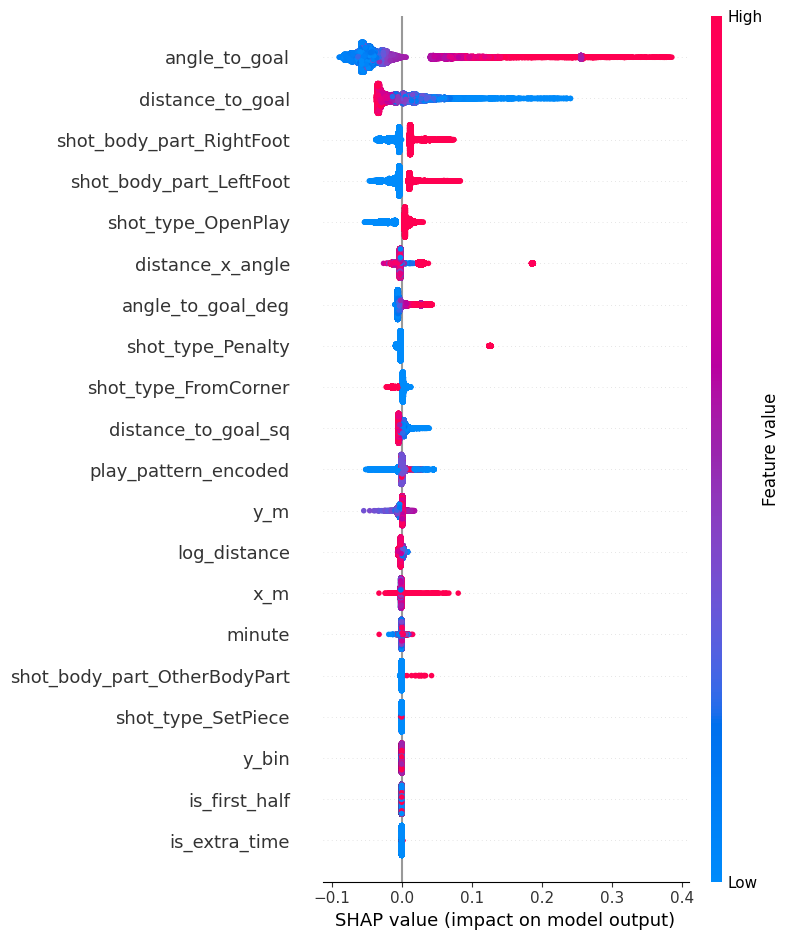

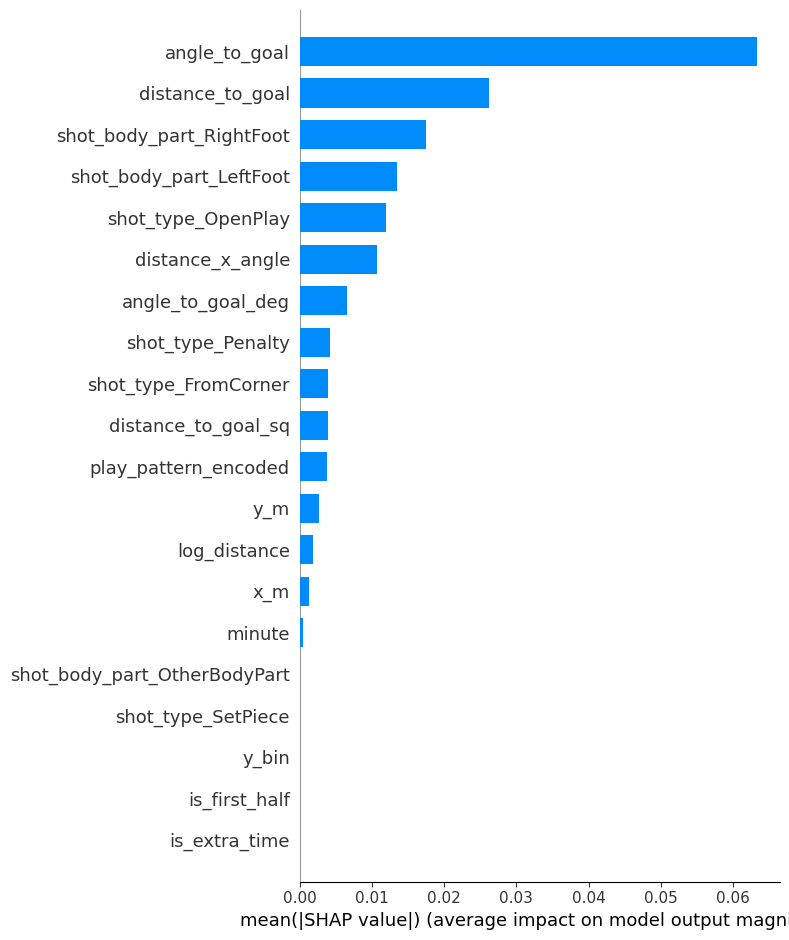

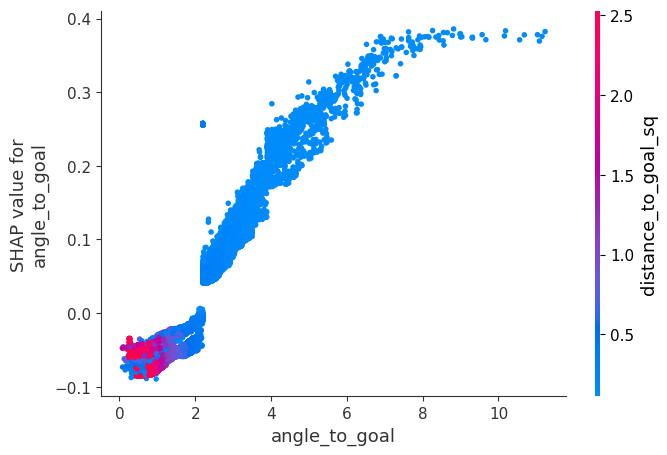

In [50]:
import shap
import matplotlib.pyplot as plt

# Extract XGBoost model from pipeline
xgb_model = best_xgb.named_steps['xgb']

# If using StandardScaler in pipeline, transform X_test accordingly
X_test_scaled = best_xgb.named_steps['scaler'].transform(X_test)

# Create SHAP explainer compatible with XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# Global feature importance summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

# Bar plot of feature importance
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=X.columns)

# Local interpretation: explain prediction for first test sample
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_scaled[0], feature_names=X.columns)

# Optional: Dependence plot for a key feature
shap.dependence_plot('angle_to_goal', shap_values, X_test_scaled, feature_names=X.columns)


### LightGBM

In [248]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
import lightgbm as lgb
from tqdm import tqdm

# =============== 1️⃣ Data Prep ===============
y = df_encoded["shot_statsbomb_xg"]
y_goal = df_encoded["goal"]
X = df_encoded.drop(columns=["shot_statsbomb_xg", "goal"])

# One-hot encode only if categorical columns exist
X = pd.get_dummies(X, drop_first=True)
X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test, y_goal_train, y_goal_test = train_test_split(
    X, y, y_goal, test_size=0.2, random_state=42
)

# =============== 2️⃣ Base LightGBM Model ===============
lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)

y_pred = np.clip(lgb_model.predict(X_test), 1e-15, 1 - 1e-15)

metrics = {
    "MSE": mean_squared_error(y_test, y_pred),
    "MAE": mean_absolute_error(y_test, y_pred),
    "R²": r2_score(y_test, y_pred),
    "Brier": brier_score_loss(y_goal_test, y_pred),
    "LogLoss": log_loss(y_goal_test, y_pred),
}

print("===== Base LightGBM =====")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Feature Importance
feature_importance = (
    pd.DataFrame({"Feature": X.columns, "Importance": lgb_model.feature_importances_})
    .sort_values(by="Importance", ascending=False)
)
print("\nTop 10 Important Features:")
print(feature_importance.head(10))

# =============== 3️⃣ Hyperparameter Optimization ===============
param_dist = {
    "lgb__n_estimators": randint(100, 400),
    "lgb__max_depth": randint(3, 15),
    "lgb__learning_rate": uniform(0.01, 0.2),
    "lgb__subsample": uniform(0.7, 0.3),
    "lgb__colsample_bytree": uniform(0.7, 0.3),
    "lgb__min_child_weight": randint(1, 7),
}

pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # Faster for sparse matrices
    ("lgb", lgb.LGBMRegressor(random_state=42, n_jobs=-1))
])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,              # reduced from 30 → faster with small tradeoff
    scoring="r2",
    cv=3,                   # reduced from 5 → faster without huge accuracy loss
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train, y_train)

best_lgb = random_search.best_estimator_
print("\n===== Optimized LightGBM =====")
print("Best Parameters:", random_search.best_params_)
print(f"Best R² (CV): {random_search.best_score_:.4f}")

# =============== 4️⃣ Evaluate Optimized Model ===============
y_pred_best = np.clip(best_lgb.predict(X_test), 1e-15, 1 - 1e-15)
metrics_best = {
    "MSE": mean_squared_error(y_test, y_pred_best),
    "MAE": mean_absolute_error(y_test, y_pred_best),
    "R²": r2_score(y_test, y_pred_best),
    "Brier": brier_score_loss(y_goal_test, y_pred_best),
    "LogLoss": log_loss(y_goal_test, y_pred_best),
}

for k, v in metrics_best.items():
    print(f"{k}: {v:.4f}")

# =============== 5️⃣ K-Fold CV ===============
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {"R²": [], "MSE": [], "Brier": [], "LogLoss": []}

print("\n===== 5-Fold Cross Validation =====")
for train_idx, test_idx in tqdm(kf.split(X), total=5, desc="CV Folds"):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    y_goal_te = y_goal.iloc[test_idx]

    preds = np.clip(best_lgb.predict(X_te), 1e-15, 1 - 1e-15)
    cv_results["R²"].append(r2_score(y_te, preds))
    cv_results["MSE"].append(mean_squared_error(y_te, preds))
    cv_results["Brier"].append(brier_score_loss(y_goal_te, preds))
    cv_results["LogLoss"].append(log_loss(y_goal_te, preds))

for metric, values in cv_results.items():
    print(f"\n{metric} (per fold): {np.round(values, 4)}")
    print(f"Mean {metric}: {np.mean(values):.4f} ± {np.std(values):.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2223
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 46
[LightGBM] [Info] Start training from score 0.112555
===== Base LightGBM =====
MSE: 0.0076
MAE: 0.0476
R²: 0.7207
Brier: 0.0780
LogLoss: 0.2731

Top 10 Important Features:
                     Feature  Importance
0                     minute         480
4              angle_to_goal         398
2                        y_m         372
10          distance_x_angle         328
1                        x_m         327
3           distance_to_goal         292
14  shot_body_part_RightFoot         190
12   shot_body_part_LeftFoot         169
11      play_pattern_encoded         139
16        shot_type_OpenPlay          82
Fitting 3 folds for eac

C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MSE: 0.0075
MAE: 0.0475
R²: 0.7220
Brier: 0.0779
LogLoss: 0.2729

===== 5-Fold Cross Validation =====


CV Folds:   0%|                                                                                  | 0/5 [00:00<?, ?it/s]C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
CV Folds:  20%|██████████████▊                                                           | 1/5 [00:00<00:02,  1.61it/s]C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
CV Folds:  40%|█████████████████████████████▌                                            | 2/5 [00:00<00:01,  2.34it/s]C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with fe


R² (per fold): [0.722  0.7419 0.7498 0.7423 0.7444]
Mean R²: 0.7401 ± 0.0095

MSE (per fold): [0.0075 0.0071 0.0069 0.0068 0.0069]
Mean MSE: 0.0071 ± 0.0003

Brier (per fold): [0.0779 0.0784 0.0794 0.0782 0.077 ]
Mean Brier: 0.0782 ± 0.0008

LogLoss (per fold): [0.2729 0.2781 0.2788 0.2749 0.2714]
Mean LogLoss: 0.2752 ± 0.0029


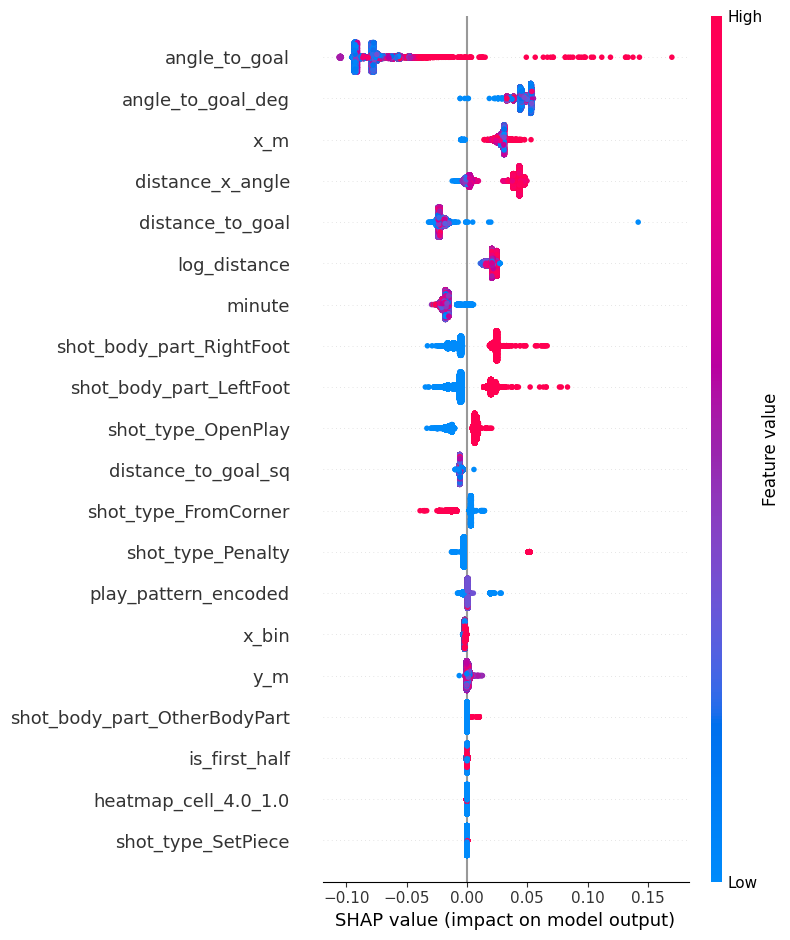

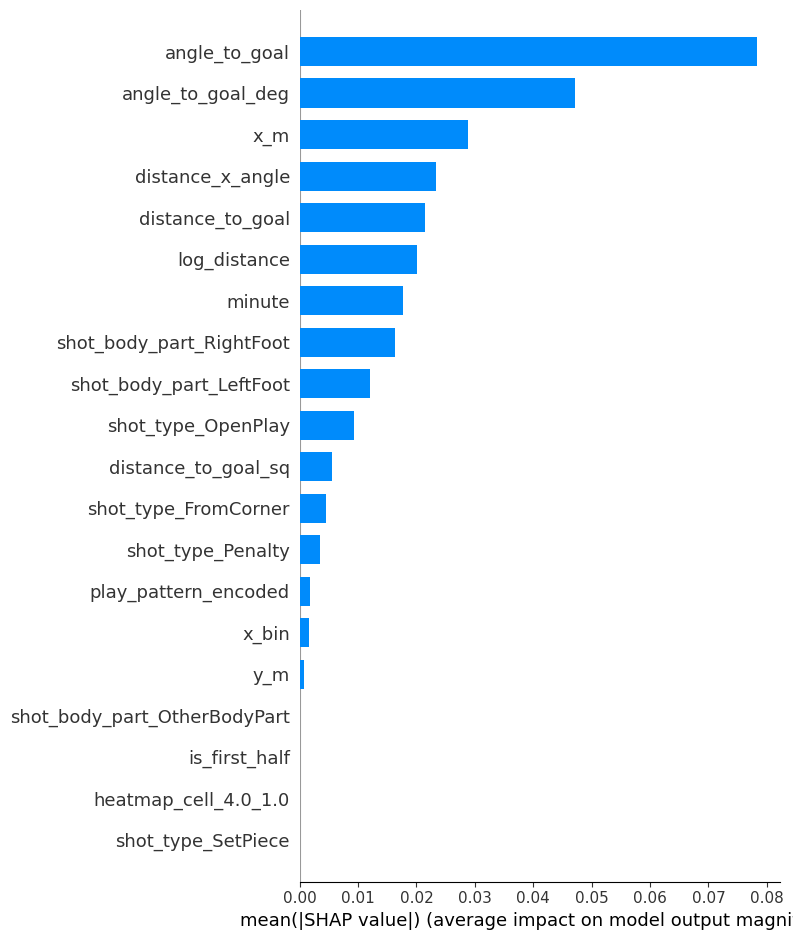

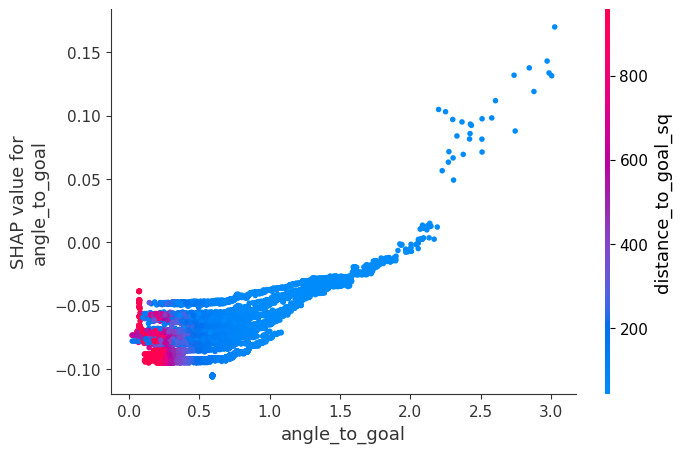

In [93]:
## shap interpretation 

import shap
import matplotlib.pyplot as plt

# Assuming best_lgb is your trained LightGBM model
# and X_test is your test feature dataframe (with proper columns)

# Create SHAP explainer for the LightGBM model
explainer = shap.TreeExplainer(best_lgb.named_steps['lgb'])

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Global Feature Importance (summary plot)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Bar plot of feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns)

# Local Interpretation: Explain a single prediction (e.g., first instance in test set)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], feature_names=X_test.columns)

# Optional: Dependence plot for a specific feature (e.g., 'angle_to_goal')
shap.dependence_plot('angle_to_goal', shap_values, X_test, feature_names=X_test.columns)


### NN

In [249]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Enable mixed precision for speed
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# =============== 1️⃣ Data Prep ===============
y = df_encoded["shot_statsbomb_xg"].astype("float32").values
y_goal = df_encoded["goal"].astype("float32").values
X = df_encoded.drop(columns=["shot_statsbomb_xg", "goal"])
X = pd.get_dummies(X, drop_first=True).fillna(0).astype("float32")
X = X.values

# Split
X_train, X_test, y_train, y_test, y_goal_train, y_goal_test = train_test_split(
    X, y, y_goal, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# =============== 2️⃣ Build Model ===============
def build_model(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, dtype="float32")(x)  # keep regression output as float32

    model = keras.Model(inputs, outputs)

    lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=1e-3,
        first_decay_steps=200
    )

    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model

# =============== 3️⃣ Train Model ===============
model = build_model(X_train.shape[1])

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(
    "best_xg_model.keras", save_best_only=True, monitor="val_loss"
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=128,
    callbacks=[early_stop, checkpoint],  # Removed reduce_lr
    verbose=2
)

# =============== 4️⃣ Evaluate Model ===============
model = keras.models.load_model("best_xg_model.keras")
y_pred = model.predict(X_test).flatten()

# Clip between 0 and 1 for xG-like metrics
y_pred_clipped = np.clip(y_pred, 1e-6, 1 - 1e-6)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
brier = brier_score_loss(y_goal_test, y_pred_clipped)
logloss = log_loss(y_goal_test, y_pred_clipped)

print("\n===== Neural Network Regression =====")
print(f"MSE: {mse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"R²: {r2:.5f}")
print(f"Brier: {brier:.5f}")
print(f"LogLoss: {logloss:.5f}")

# =============== 5️⃣ K-Fold Cross Validation ===============
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2, cv_mse, cv_brier, cv_logloss = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n📂 Fold {fold+1}/5")

    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    y_goal_te = y_goal[test_idx]

    # Scale within fold to avoid data leakage
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)

    nn = build_model(X_tr.shape[1])
    nn.fit(
        X_tr, y_tr,
        validation_split=0.1,
        epochs=100,
        batch_size=128,
        verbose=0,
        callbacks=[keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
    )

    preds = nn.predict(X_te).flatten()
    preds_clipped = np.clip(preds, 1e-6, 1 - 1e-6)

    cv_r2.append(r2_score(y_te, preds))
    cv_mse.append(mean_squared_error(y_te, preds))
    cv_brier.append(brier_score_loss(y_goal_te, preds_clipped))
    cv_logloss.append(log_loss(y_goal_te, preds_clipped))

print("\n===== 5-Fold Cross Validation =====")
print("R² per fold:", np.round(cv_r2, 4))
print(f"Mean R²: {np.mean(cv_r2):.4f} ± {np.std(cv_r2):.4f}")
print("MSE per fold:", np.round(cv_mse, 4))
print(f"Mean MSE: {np.mean(cv_mse):.4f} ± {np.std(cv_mse):.4f}")
print("Brier per fold:", np.round(cv_brier, 4))
print(f"Mean Brier: {np.mean(cv_brier):.4f} ± {np.std(cv_brier):.4f}")
print("LogLoss per fold:", np.round(cv_logloss, 4))
print(f"Mean LogLoss: {np.mean(cv_logloss):.4f} ± {np.std(cv_logloss):.4f}")


Epoch 1/200
707/707 - 15s - 22ms/step - loss: 0.1584 - mae: 0.2465 - val_loss: 0.0568 - val_mae: 0.1100
Epoch 2/200
707/707 - 12s - 18ms/step - loss: 0.0533 - mae: 0.1259 - val_loss: 0.0354 - val_mae: 0.0771
Epoch 3/200
707/707 - 20s - 28ms/step - loss: 0.0402 - mae: 0.0947 - val_loss: 0.0307 - val_mae: 0.0619
Epoch 4/200
707/707 - 21s - 30ms/step - loss: 0.0336 - mae: 0.0773 - val_loss: 0.0295 - val_mae: 0.0580
Epoch 5/200
707/707 - 13s - 18ms/step - loss: 0.0314 - mae: 0.0722 - val_loss: 0.0267 - val_mae: 0.0525
Epoch 6/200
707/707 - 12s - 17ms/step - loss: 0.0261 - mae: 0.0630 - val_loss: 0.0225 - val_mae: 0.0499
Epoch 7/200
707/707 - 10s - 15ms/step - loss: 0.0225 - mae: 0.0591 - val_loss: 0.0203 - val_mae: 0.0530
Epoch 8/200
707/707 - 12s - 17ms/step - loss: 0.0204 - mae: 0.0568 - val_loss: 0.0190 - val_mae: 0.0512
Epoch 9/200
707/707 - 21s - 30ms/step - loss: 0.0197 - mae: 0.0568 - val_loss: 0.0176 - val_mae: 0.0575
Epoch 10/200
707/707 - 19s - 27ms/step - loss: 0.0154 - mae: 0.0

### Without NaNs NN

In [262]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =============== Data Preparation ===============
y = df_encoded["shot_statsbomb_xg"].astype("float32").values
y_goal = df_encoded["goal"].astype("float32").values
X = df_encoded.drop(columns=["shot_statsbomb_xg", "goal"])
X = pd.get_dummies(X, drop_first=True).fillna(0).astype("float32").values

# =============== Model Building Function ===============
def build_model(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, dtype="float32")(x)
    model = keras.Model(inputs, outputs)
    lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=1e-3, first_decay_steps=200)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model

# =============== K-Fold Cross-Validation ===============
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2, cv_mse, cv_mae, cv_brier, cv_logloss, n_nan_folds = [], [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n📂 Fold {fold+1}/5")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    y_goal_te = y_goal[test_idx]

    # Scale within fold
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)

    nn = build_model(X_tr.shape[1])
    nn.fit(X_tr, y_tr, validation_split=0.1, epochs=100, batch_size=128, verbose=0, 
           callbacks=[keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])
    preds = nn.predict(X_te).flatten()
    n_nan = np.isnan(preds).sum()
    n_nan_folds.append(n_nan)
    print(f"NaN predictions in this fold: {n_nan}")
    not_nan_mask = ~np.isnan(preds)
    y_te_clean = y_te[not_nan_mask]
    preds_clean = preds[not_nan_mask]
    y_goal_te_clean = y_goal_te[not_nan_mask]
    preds_clipped = np.clip(preds_clean, 1e-6, 1 - 1e-6)
    cv_r2.append(r2_score(y_te_clean, preds_clean))
    cv_mse.append(mean_squared_error(y_te_clean, preds_clean))
    cv_mae.append(mean_absolute_error(y_te_clean, preds_clean))
    cv_brier.append(brier_score_loss(y_goal_te_clean, preds_clipped))
    cv_logloss.append(log_loss(y_goal_te_clean, preds_clipped))

# =============== Results Summary ===============
print("\n===== 5-Fold Cross Validation (NaN-safe) =====")
print("NaN predictions per fold:", n_nan_folds)
print("R² per fold:", np.round(cv_r2, 4))
print(f"Mean R²: {np.mean(cv_r2):.4f} ± {np.std(cv_r2):.4f}")
print("MSE per fold:", np.round(cv_mse, 4))
print(f"Mean MSE: {np.mean(cv_mse):.4f} ± {np.std(cv_mse):.4f}")
print("MAE per fold:", np.round(cv_mae, 4))
print(f"Mean MAE: {np.mean(cv_mae):.4f} ± {np.std(cv_mae):.4f}")
print("Brier per fold:", np.round(cv_brier, 4))
print(f"Mean Brier: {np.mean(cv_brier):.4f} ± {np.std(cv_brier):.4f}")
print("LogLoss per fold:", np.round(cv_logloss, 4))
print(f"Mean LogLoss: {np.mean(cv_logloss):.4f} ± {np.std(cv_logloss):.4f}")



📂 Fold 1/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step
NaN predictions in this fold: 0

📂 Fold 2/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step
NaN predictions in this fold: 0

📂 Fold 3/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step
NaN predictions in this fold: 0

📂 Fold 4/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step
NaN predictions in this fold: 0

📂 Fold 5/5
883/883 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
NaN predictions in this fold: 0

===== 5-Fold Cross Validation (NaN-safe) =====
NaN predictions per fold: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
R² per fold: [0.7191 0.7268 0.7331 0.727  0.7298]
Mean R²: 0.7272 ± 0.0046
MSE per fold: [0.0076 0.0075 0.0074 0.0072 0.0073]
Mean MSE: 0.0074 ± 0.0001
MAE per fold: [0.0474 0.0475 0.0473 0.0468 0.0472]
Mean MAE: 0.0473 ± 0.0003
Brier per fold: [0.078  0.0786 0.0796 0.0785 0.0774]
Mean Brier: 0.0784 ± 0.0007
LogLoss per fold: [0.274  0.2754 0.2816 0.2761 0.2726]
Mean LogLoss: 0.2759 ± 0.0031


### Mean ENSEMBLE Model

In [99]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss
import xgboost as xgb
import lightgbm as lgb
from tensorflow import keras
from tensorflow.keras import layers

# Prepare your data: X (DataFrame), y (xG target), y_goal (binary goal outcome)
# Ensure all preprocessing (encoding, etc.) is done on X.

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse, cv_mae, cv_r2, cv_brier, cv_logloss = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n--- Fold {fold+1}/5 ---")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    y_goal_te = y_goal[test_idx]

    # Always scale within fold to avoid data leakage
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)

    # Linear Regression
    lr_model = LinearRegression().fit(X_tr_scaled, y_tr)
    lr_pred = lr_model.predict(X_te_scaled)

    # Random Forest
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_tr, y_tr)
    rf_pred = rf_model.predict(X_te)

    # XGBoost
    xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)
    xgb_model.fit(X_tr, y_tr)
    xgb_pred = xgb_model.predict(X_te)

    # LightGBM
    lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    lgb_model.fit(X_tr, y_tr)
    lgb_pred = lgb_model.predict(X_te)

    # Neural Network
    def build_model(input_dim):
        inputs = keras.Input(shape=(input_dim,))
        x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(64, activation="relu")(x)    # <-- Fix: now called properly
        outputs = layers.Dense(1, dtype="float32")(x)
        model = keras.Model(inputs, outputs)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
        return model

    nn_model = build_model(X_tr_scaled.shape[1])
    nn_model.fit(X_tr_scaled, y_tr, epochs=30, batch_size=128, verbose=0)
    nn_pred = nn_model.predict(X_te_scaled).flatten()

    # Ensemble prediction (simple mean)
    ensemble_pred = (lr_pred + rf_pred + xgb_pred + lgb_pred + nn_pred) / 5.0
    ensemble_pred_clipped = np.clip(ensemble_pred, 1e-6, 1-1e-6)

    # Metrics
    cv_mse.append(mean_squared_error(y_te, ensemble_pred))
    cv_mae.append(mean_absolute_error(y_te, ensemble_pred))
    cv_r2.append(r2_score(y_te, ensemble_pred))
    cv_brier.append(brier_score_loss(y_goal_te, ensemble_pred_clipped))
    cv_logloss.append(log_loss(y_goal_te, ensemble_pred_clipped))

# Final results
print("\n===== K-Fold CV Results: Ensemble =====")
print(f"Mean MSE: {np.mean(cv_mse):.5f} ± {np.std(cv_mse):.5f}")
print(f"Mean MAE: {np.mean(cv_mae):.5f} ± {np.std(cv_mae):.5f}")
print(f"Mean R²: {np.mean(cv_r2):.5f} ± {np.std(cv_r2):.5f}")
print(f"Mean Brier: {np.mean(cv_brier):.5f} ± {np.std(cv_brier):.5f}")
print(f"Mean LogLoss: {np.mean(cv_logloss):.5f} ± {np.std(cv_logloss):.5f}")



--- Fold 1/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 46
[LightGBM] [Info] Start training from score 0.112555


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

--- Fold 2/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2221
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 45
[LightGBM] [Info] Start training from score 0.112537


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

--- Fold 3/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2223
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 45
[LightGBM] [Info] Start training from score 0.112540


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

--- Fold 4/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2224
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 46
[LightGBM] [Info] Start training from score 0.112897


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 3303s 4s/step

--- Fold 5/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 113016, number of used features: 46
[LightGBM] [Info] Start training from score 0.112672


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

===== K-Fold CV Results: Ensemble =====
Mean MSE: 0.00729 ± 0.00013
Mean MAE: 0.04780 ± 0.00062
Mean R²: 0.73144 ± 0.00487
Mean Brier: 0.07827 ± 0.00076
Mean LogLoss: 0.27568 ± 0.00301


### Weighted Ensemble Model 

In [270]:
import numpy as np
from sklearn.impute import SimpleImputer

def check_and_impute(arr, arr_name):
    nan_count = np.isnan(arr).sum()
    print(f"NaNs in {arr_name}: {nan_count}")
    if nan_count > 0:
        imputer = SimpleImputer(strategy='mean')
        arr = imputer.fit_transform(arr)
        print(f"After imputation, NaNs in {arr_name}: {np.isnan(arr).sum()}")
    return arr

# Debug each major array you use for prediction:
X_test = check_and_impute(X_test, "X_test")
X_test_scaled = check_and_impute(X_test_scaled, "X_test_scaled")

# After stacking base model predictions:
X_meta_test = np.column_stack([
    lr_full.predict(X_test_scaled),
    rf_full.predict(X_test),
    xgb_full.predict(X_test),
    lgbm_full.predict(X_test),
    nn_full.predict(X_test_scaled).flatten()
])
X_meta_test = check_and_impute(X_meta_test, "X_meta_test")

# Now run ensemble prediction safely:
ensemble_pred = meta.predict(X_meta_test)
ensemble_pred_clipped = np.clip(ensemble_pred, 1e-6, 1-1e-6)
print("\n===== Sample Ensemble Predictions =====")
print(ensemble_pred_clipped[:10])


NaNs in X_test: 0
NaNs in X_test_scaled: 0
 17/883 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step  

C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
NaNs in X_meta_test: 2
After imputation, NaNs in X_meta_test: 0

===== Sample Ensemble Predictions =====
[0.35106153 0.07678042 0.08000067 0.47733521 0.32150818 0.33196711
 0.35210377 0.10015724 0.0880908  0.06645945]


In [275]:
print("NaNs in X_meta_test:", np.isnan(X_meta_test).sum())
print("Any NaNs per column:", np.isnan(X_meta_test).sum(axis=0))


NaNs in X_meta_test: 0
Any NaNs per column: [0 0 0 0 0]


In [276]:
import numpy as np

# Calculate the mean of the last column, ignoring NaNs
col4_mean = np.nanmean(X_meta_test[:, 4])

# Find indices where the last column has NaN
nan_indices = np.where(np.isnan(X_meta_test[:, 4]))[0]

# Replace those NaNs with the mean
X_meta_test[nan_indices, 4] = col4_mean

print("Post-clean NaN count (should be 0):", np.isnan(X_meta_test).sum())


Post-clean NaN count (should be 0): 0


### Best Model so FAR ……….

In [283]:


import numpy as np

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

import lightgbm as lgb

from tensorflow import keras

from tensorflow.keras import layers

from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler



# Must have X (features), y (target). Use DataFrame or np.array as needed.

# If you use np.array (e.g. after NN processing), adapt indexing accordingly.



# --- Neural Network builder ---

def build_model(input_dim):

   inputs = keras.Input(shape=(input_dim,))

   x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(inputs)

   x = layers.BatchNormalization()(x)

   x = layers.Dropout(0.3)(x)

   x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)

   x = layers.BatchNormalization()(x)

   x = layers.Dropout(0.2)(x)

   x = layers.Dense(64, activation="relu")(x)

   outputs = layers.Dense(1, dtype="float32")(x)

   model = keras.Model(inputs, outputs)

   model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

   return model



# --- 1. Generate out-of-fold predictions for stacking ---

N_models = 5

kf = KFold(n_splits=5, shuffle=True, random_state=42)

X_meta_train = np.zeros((len(X), N_models))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):

   print(f"\nStacking: Fold {fold+1}/5")

   X_tr, X_val = X[train_idx], X[val_idx]

   y_tr, y_val = y[train_idx], y[val_idx]

   scaler = StandardScaler()

   X_tr_scaled = scaler.fit_transform(X_tr)

   X_val_scaled = scaler.transform(X_val)

   # 1. Linear Regression

   lr = LinearRegression().fit(X_tr_scaled, y_tr)

   X_meta_train[val_idx, 0] = lr.predict(X_val_scaled)

   # 2. Random Forest

   rf = RandomForestRegressor(random_state=42).fit(X_tr, y_tr)

   X_meta_train[val_idx, 1] = rf.predict(X_val)

   # 3. XGBoost

   xgb_model = xgb.XGBRegressor(n_jobs=-1, random_state=42).fit(X_tr, y_tr)

   X_meta_train[val_idx, 2] = xgb_model.predict(X_val)

   # 4. LightGBM

   lgb_model = lgb.LGBMRegressor(n_jobs=-1, random_state=42).fit(X_tr, y_tr)

   X_meta_train[val_idx, 3] = lgb_model.predict(X_val)

   # 5. Neural Network

   nn = build_model(X_tr_scaled.shape[1])

   nn.fit(X_tr_scaled, y_tr, epochs=15, batch_size=128, verbose=0)

   X_meta_train[val_idx, 4] = nn.predict(X_val_scaled).flatten()



# --- 2. Fit meta-model (learn weights) ---

meta = LinearRegression(fit_intercept=False)

meta.fit(X_meta_train, y)

weights = meta.coef_

print("Optimal weights for each model:")

for i, w in enumerate(weights):

   print(f"  Model {i+1}: {w:.3f}")



# --- 3. Predict on test set with trained base models ---

scaler_full = StandardScaler()

X_train_scaled = scaler_full.fit_transform(X)

X_test_scaled = scaler_full.transform(X_test)



lr_full   = LinearRegression().fit(X_train_scaled, y)

rf_full   = RandomForestRegressor(random_state=42).fit(X, y)

xgb_full  = xgb.XGBRegressor(n_jobs=-1, random_state=42).fit(X, y)

lgbm_full = lgb.LGBMRegressor(n_jobs=-1, random_state=42).fit(X, y)

nn_full   = build_model(X_train_scaled.shape[1])

nn_full.fit(X_train_scaled, y, epochs=15, batch_size=128, verbose=0)



# Stack test predictions

X_meta_test = np.column_stack([

   lr_full.predict(X_test_scaled),           # Scaled

   rf_full.predict(X_test),

   xgb_full.predict(X_test),

   lgbm_full.predict(X_test),

   nn_full.predict(X_test_scaled).flatten()

])

ensemble_pred = meta.predict(X_meta_test)

ensemble_pred_clipped = np.clip(ensemble_pred, 1e-6, 1-1e-6)



# --- 4. Evaluate stacking ensemble ---

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss



mse = mean_squared_error(y_test, ensemble_pred)

mae = mean_absolute_error(y_test, ensemble_pred)

r2 = r2_score(y_test, ensemble_pred)

brier = brier_score_loss(y_goal_test, ensemble_pred_clipped)

logloss = log_loss(y_goal_test, ensemble_pred_clipped)



print("\n===== Meta-Ensemble (Stacking) Results =====")

print(f"Mean Squared Error: {mse:.5f}")

print(f"Mean Absolute Error: {mae:.5f}")

print(f"R² Score: {r2:.5f}")

print(f"Brier Score: {brier:.5f}")

print(f"Log Loss: {logloss:.5f}")





Stacking: Fold 1/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2223
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 46
[LightGBM] [Info] Start training from score 0.112555


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Stacking: Fold 2/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2224
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 45
[LightGBM] [Info] Start training from score 0.112537


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Stacking: Fold 3/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2225
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 45
[LightGBM] [Info] Start training from score 0.112540


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Stacking: Fold 4/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2227
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 46
[LightGBM] [Info] Start training from score 0.112897


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Stacking: Fold 5/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 113016, number of used features: 46
[LightGBM] [Info] Start training from score 0.112672


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Optimal weights for each model:
  Model 1: 0.117
  Model 2: 0.277
  Model 3: 0.025
  Model 4: 0.515
  Model 5: 0.068


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2227
[LightGBM] [Info] Number of data points in the train set: 141269, number of used features: 47
[LightGBM] [Info] Start training from score 0.112640


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

===== Meta-Ensemble (Stacking) Results =====
Mean Squared Error: 0.00487
Mean Absolute Error: 0.03878
R² Score: 0.82053
Brier Score: 0.07562
Log Loss: 0.26526


### saving the model 

In [296]:
import joblib
import os

# Create a folder to keep all model files
os.makedirs("ensemble_models", exist_ok=True)

# Save scalers
joblib.dump(scaler_full, "ensemble_models/scaler_full.pkl")

# Save base models
joblib.dump(lr_full, "ensemble_models/lr_full.pkl")
joblib.dump(rf_full, "ensemble_models/rf_full.pkl")
xgb_full.save_model("ensemble_models/xgb_full.json")
lgbm_full.booster_.save_model("ensemble_models/lgbm_full.txt")

# Save neural network
nn_full.save("ensemble_models/nn_full.keras")

# Save meta model (the linear regression that combines them)
joblib.dump(meta, "ensemble_models/meta_model.pkl")


['ensemble_models/meta_model.pkl']

In [291]:
import joblib

# ✅ Save all models and preprocessing objects
joblib.dump({
    "scaler_full": scaler_full,        # StandardScaler used for scaling
    "lr_full": lr_full,                # Linear Regression base model
    "rf_full": rf_full,                # Random Forest base model
    "xgb_full": xgb_full,              # XGBoost base model
    "lgbm_full": lgbm_full,            # LightGBM base model
    "nn_full": nn_full,                # Neural Network base model
    "meta_model": meta,                # Meta Linear Regression model
    "weights": weights,                # Meta model learned weights
}, "best_ensemble_model.pkl")

print("✅ Ensemble model and components saved as 'best_ensemble_model.pkl'")


✅ Ensemble model and components saved as 'best_ensemble_model.pkl'


In [5]:
df_india = pd.read_csv("isl_shots_2021_22.csv")

# drop duplicates if overlap exists
df_india.drop_duplicates(inplace=True)

# check shape
print("Total samples:", len(df_india))

Total samples: 3095


### Predicting on INDIAN Data

In [322]:
df_india_encoded = pd.read_csv("df_india_encoded.csv")

In [323]:
df_india_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   goal                          3095 non-null   int64  
 1   shot_statsbomb_xg             3095 non-null   float64
 2   minute                        3095 non-null   int64  
 3   x_m                           3095 non-null   float64
 4   y_m                           3095 non-null   float64
 5   distance_to_goal              3095 non-null   float64
 6   angle_to_goal                 3095 non-null   float64
 7   angle_to_goal_deg             3095 non-null   float64
 8   distance_to_goal_sq           3095 non-null   float64
 9   log_distance                  3095 non-null   float64
 10  is_first_half                 3095 non-null   int64  
 11  is_extra_time                 3095 non-null   int64  
 12  distance_x_angle              3095 non-null   float64
 13  pla

In [324]:
import numpy as np
import pandas as pd

# -------------------------------
# 1. Shot Zone Encoding
# -------------------------------
def assign_shot_zone(x, y):
    # Edit bounds if your data uses a different pitch scale
    if x >= 104 and x <= 116 and y >= 34 and y <= 54:
        return 'six_yard_box'
    elif x >= 88 and x < 120 and y >= 18 and y <= 62:
        return 'penalty_area'
    elif x >= 88 and x < 120 and y > 62:
        return 'penalty_area_right'
    elif x >= 88 and x < 120 and y < 18:
        return 'penalty_area_left'
    elif x < 88:
        return 'outside_box'
    else:
        return 'other'

# Apply shot zone encoding

df_india_encoded['shot_zone_label'] = df_india_encoded.apply(lambda row: assign_shot_zone(row['x_m'], row['y_m']), axis=1)

# -------------------------------
# 2. Heatmap/Grid Encoding
# -------------------------------
x_bins = np.linspace(df_india_encoded['x_m'].min(), df_india_encoded['x_m'].max(), 6)
y_bins = np.linspace(df_india_encoded['y_m'].min(), df_india_encoded['y_m'].max(), 6)

df_india_encoded['x_bin'] = pd.cut(df_india_encoded['x_m'], bins=x_bins, labels=False)
df_india_encoded['y_bin'] = pd.cut(df_india_encoded['y_m'], bins=y_bins, labels=False)

df_india_encoded['heatmap_cell'] = df_india_encoded['x_bin'].astype(str) + '_' + df_india_encoded['y_bin'].astype(str)

# -------------------------------
# 3. One-Hot Encoding
# -------------------------------
df_india_encoded = pd.get_dummies(
    df_india_encoded,
    columns=['shot_zone_label', 'heatmap_cell'],  # these columns exist now
    drop_first=True
)

# -------------------------------
# 4. Ready for modeling
# -------------------------------
print("Feature encoding complete. Columns now numeric and ready for modeling.")
print("Sample columns:", df_india_encoded.columns[:10].tolist())


Feature encoding complete. Columns now numeric and ready for modeling.
Sample columns: ['goal', 'shot_statsbomb_xg', 'minute', 'x_m', 'y_m', 'distance_to_goal', 'angle_to_goal', 'angle_to_goal_deg', 'distance_to_goal_sq', 'log_distance']


In [325]:
df_india_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   goal                                3095 non-null   int64  
 1   shot_statsbomb_xg                   3095 non-null   float64
 2   minute                              3095 non-null   int64  
 3   x_m                                 3095 non-null   float64
 4   y_m                                 3095 non-null   float64
 5   distance_to_goal                    3095 non-null   float64
 6   angle_to_goal                       3095 non-null   float64
 7   angle_to_goal_deg                   3095 non-null   float64
 8   distance_to_goal_sq                 3095 non-null   float64
 9   log_distance                        3095 non-null   float64
 10  is_first_half                       3095 non-null   int64  
 11  is_extra_time                       3095 no

In [305]:
missing_cols = set(feature_columns) - set(df_india_encoded.columns)
print("Missing columns:", missing_cols)


Missing columns: {'heatmap_cell_0.0_4.0', 'heatmap_cell_3.0_nan', 'heatmap_cell_nan_2.0', 'heatmap_cell_0.0_1.0', 'heatmap_cell_1.0_0.0'}


In [312]:
df_india_encoded = df_india_encoded.reindex(columns=feature_columns, fill_value=0)


In [326]:
df_india_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   goal                                3095 non-null   int64  
 1   shot_statsbomb_xg                   3095 non-null   float64
 2   minute                              3095 non-null   int64  
 3   x_m                                 3095 non-null   float64
 4   y_m                                 3095 non-null   float64
 5   distance_to_goal                    3095 non-null   float64
 6   angle_to_goal                       3095 non-null   float64
 7   angle_to_goal_deg                   3095 non-null   float64
 8   distance_to_goal_sq                 3095 non-null   float64
 9   log_distance                        3095 non-null   float64
 10  is_first_half                       3095 non-null   int64  
 11  is_extra_time                       3095 no

### using naive adjustment on df_india_encoded


In [96]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss

# --- 1. Build the neural network model ---
def build_model(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, dtype="float32")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
    return model

# --- 2. Prepare training data ---
X = df_encoded.drop(columns=["shot_statsbomb_xg", "goal"], errors="ignore")
y = df_encoded["shot_statsbomb_xg"].values
X = pd.get_dummies(X, drop_first=True).fillna(0)
feature_columns = X.columns.copy()  # Save for new data alignment
X = X.values

# --- 3. Out-of-fold predictions for stacking meta-model ---
N_models = 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X_meta_train = np.zeros((len(X), N_models))
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nStacking: Fold {fold+1}/5")
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    # 1. Linear Regression (scaled)
    lr = LinearRegression().fit(X_tr_scaled, y_tr)
    X_meta_train[val_idx, 0] = lr.predict(X_val_scaled)
    # 2. Random Forest
    rf = RandomForestRegressor(random_state=42).fit(X_tr, y_tr)
    X_meta_train[val_idx, 1] = rf.predict(X_val)
    # 3. XGBoost
    xgb_model = xgb.XGBRegressor(n_jobs=-1, random_state=42).fit(X_tr, y_tr)
    X_meta_train[val_idx, 2] = xgb_model.predict(X_val)
    # 4. LightGBM
    lgb_model = lgb.LGBMRegressor(n_jobs=-1, random_state=42).fit(X_tr, y_tr)
    X_meta_train[val_idx, 3] = lgb_model.predict(X_val)
    # 5. Neural Net (scaled)
    nn = build_model(X_tr_scaled.shape[1])
    nn.fit(X_tr_scaled, y_tr, epochs=15, batch_size=128, verbose=0)
    X_meta_train[val_idx, 4] = nn.predict(X_val_scaled).flatten()

# --- 4. Fit meta-model (learn weights for each model) ---
meta = LinearRegression(fit_intercept=False)
meta.fit(X_meta_train, y)
weights = meta.coef_
print("\nOptimal weights for each model:")
for i, w in enumerate(weights):
    print(f"  Model {i+1}: {w:.3f}")

# --- 5. Retrain base models on all training data ---
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X)
lr_full   = LinearRegression().fit(X_scaled_full, y)
rf_full   = RandomForestRegressor(random_state=42).fit(X, y)
xgb_full  = xgb.XGBRegressor(n_jobs=-1, random_state=42).fit(X, y)
lgbm_full = lgb.LGBMRegressor(n_jobs=-1, random_state=42).fit(X, y)
nn_full   = build_model(X_scaled_full.shape[1])
nn_full.fit(X_scaled_full, y, epochs=15, batch_size=128, verbose=0)

# --- 6. Prediction on a new DataFrame (df_india_encode) ---
X_new = df_india_encoded.drop(columns=["shot_statsbomb_xg", "goal"], errors="ignore")
X_new = pd.get_dummies(X_new, drop_first=True).fillna(0)
X_new = X_new.reindex(columns=feature_columns, fill_value=0)
X_new_np = X_new.values
X_new_scaled = scaler_full.transform(X_new_np)

pred_lr    = lr_full.predict(X_new_scaled)
pred_rf    = rf_full.predict(X_new_np)
pred_xgb   = xgb_full.predict(X_new_np)
pred_lgbm  = lgbm_full.predict(X_new_np)
pred_nn    = nn_full.predict(X_new_scaled).flatten()

X_meta_new = np.column_stack([pred_lr, pred_rf, pred_xgb, pred_lgbm, pred_nn])
ensemble_pred_new = meta.predict(X_meta_new)
ensemble_pred_new = np.clip(ensemble_pred_new, 1e-6, 1-1e-6)

print("\n===== Predictions for df_india_encoded =====")
print(ensemble_pred_new)

# --- 7. Evaluation: Print results summary if ground truth present ---
if 'shot_statsbomb_xg' in df_india_encoded and 'goal' in df_india_encoded:
    y_true = df_india_encoded['shot_statsbomb_xg'].values
    y_goal_true = df_india_encoded['goal'].values
    mse = mean_squared_error(y_true, ensemble_pred_new)
    mae = mean_absolute_error(y_true, ensemble_pred_new)
    r2 = r2_score(y_true, ensemble_pred_new)
    brier = brier_score_loss(y_goal_true, ensemble_pred_new)
    logloss = log_loss(y_goal_true, ensemble_pred_new)
    print("\n===== Meta-Ensemble (Stacking) Results =====")
    print(f"Mean Squared Error: {mse:.5f}")
    print(f"Mean Absolute Error: {mae:.5f}")
    print(f"R² Score: {r2:.5f}")
    print(f"Brier Score: {brier:.5f}")
    print(f"Log Loss: {logloss:.5f}")
else:
    print("\nGround truth columns 'shot_statsbomb_xg' and 'goal' not present for summary metrics.")



Stacking: Fold 1/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2223
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 46
[LightGBM] [Info] Start training from score 0.112555


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Stacking: Fold 2/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2224
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 45
[LightGBM] [Info] Start training from score 0.112537


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Stacking: Fold 3/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2224
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 45
[LightGBM] [Info] Start training from score 0.112540


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Stacking: Fold 4/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 113015, number of used features: 46
[LightGBM] [Info] Start training from score 0.112897


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Stacking: Fold 5/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2225
[LightGBM] [Info] Number of data points in the train set: 113016, number of used features: 46
[LightGBM] [Info] Start training from score 0.112672


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


883/883 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Optimal weights for each model:
  Model 1: 0.102
  Model 2: 0.274
  Model 3: 0.053
  Model 4: 0.462
  Model 5: 0.112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 141269, number of used features: 47
[LightGBM] [Info] Start training from score 0.112640
43/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

===== Predictions for df_india_encoded =====
[0.01062374 0.23664014 0.02523451 ... 0.08836912 0.08069666 0.13788529]

===== Meta-Ensemble (Stacking) Results =====
Mean Squared Error: 0.01271
Mean Absolute Error: 0.05932
R² Score: 0.40153
Brier Score: 0.09076
Log Loss: 0.31762


### using proper adjustment on df_india_encoded

In [330]:
missing_cols = [col for col in training_features if col not in df_india_encoded.columns]
print("Missing columns in India dataset:", missing_cols)

extra_cols = [col for col in df_india_encoded.columns if col not in training_features]
print("Extra columns in India dataset:", extra_cols)


Missing columns in India dataset: ['heatmap_cell_0.0_1.0', 'heatmap_cell_0.0_4.0', 'heatmap_cell_1.0_0.0', 'heatmap_cell_3.0_nan', 'heatmap_cell_nan_2.0']
Extra columns in India dataset: ['goal', 'shot_statsbomb_xg', 'heatmap_cell_4.0_nan', 'heatmap_cell_nan_1.0', 'Predicted_shot_statsbomb_xg']


In [329]:
import numpy as np
import pandas as pd
import joblib
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss

# ======================================================
# 🔹 1. Load saved ensemble model
# ======================================================
print("🔹 Loading saved ensemble model...")
ensemble_data = joblib.load("best_ensemble_model.pkl")

scaler_full = ensemble_data["scaler_full"]
lr_full = ensemble_data["lr_full"]
rf_full = ensemble_data["rf_full"]
xgb_full = ensemble_data["xgb_full"]
lgbm_full = ensemble_data["lgbm_full"]
nn_full = ensemble_data["nn_full"]
meta = ensemble_data["meta_model"]

print("✅ Ensemble components loaded successfully!")

# ======================================================
# 🔹 2. Prepare new data (df_india_encoded)
# ======================================================
df_new = df_india_encoded.copy()

# Ensure correct dtypes (convert bools to ints for model compatibility)
for col in df_new.select_dtypes(include="bool").columns:
    df_new[col] = df_new[col].astype(int)

# Get training feature names (from your original training DataFrame)
training_features = [
    'minute', 'x_m', 'y_m', 'distance_to_goal', 'angle_to_goal', 'angle_to_goal_deg',
    'distance_to_goal_sq', 'log_distance', 'is_first_half', 'is_extra_time', 'distance_x_angle',
    'play_pattern_encoded', 'shot_body_part_LeftFoot', 'shot_body_part_OtherBodyPart', 'shot_body_part_RightFoot',
    'shot_type_FromCorner', 'shot_type_OpenPlay', 'shot_type_Penalty', 'shot_type_SetPiece',
    'zone_wide_right', 'distance_bucket_10-20', 'distance_bucket_20-30', 'distance_bucket_30-40', 'distance_bucket_40+',
    'angle_bucket_nan', 'x_bin', 'y_bin', 'shot_zone_label_penalty_area', 'shot_zone_label_penalty_area_left',
    'shot_zone_label_penalty_area_right', 'shot_zone_label_six_yard_box',
    'heatmap_cell_0.0_1.0', 'heatmap_cell_0.0_2.0', 'heatmap_cell_0.0_3.0', 'heatmap_cell_0.0_4.0',
    'heatmap_cell_1.0_0.0', 'heatmap_cell_1.0_1.0', 'heatmap_cell_1.0_2.0', 'heatmap_cell_1.0_3.0', 'heatmap_cell_1.0_4.0',
    'heatmap_cell_2.0_0.0', 'heatmap_cell_2.0_1.0', 'heatmap_cell_2.0_2.0', 'heatmap_cell_2.0_3.0', 'heatmap_cell_2.0_4.0',
    'heatmap_cell_3.0_0.0', 'heatmap_cell_3.0_1.0', 'heatmap_cell_3.0_2.0', 'heatmap_cell_3.0_3.0', 'heatmap_cell_3.0_4.0',
    'heatmap_cell_3.0_nan', 'heatmap_cell_4.0_0.0', 'heatmap_cell_4.0_1.0', 'heatmap_cell_4.0_2.0', 'heatmap_cell_4.0_3.0',
    'heatmap_cell_4.0_4.0', 'heatmap_cell_nan_2.0'
]

# Drop target columns (goal and shot_statsbomb_xg) if present
df_features = df_new.drop(columns=["goal", "shot_statsbomb_xg"], errors="ignore")

# Align features: add missing, drop extras
missing_cols = [col for col in training_features if col not in df_features.columns]
extra_cols = [col for col in df_features.columns if col not in training_features]

if missing_cols:
    print(f"⚠️ Adding {len(missing_cols)} missing columns: {missing_cols}")
    for col in missing_cols:
        df_features[col] = 0

if extra_cols:
    print(f"⚠️ Dropping {len(extra_cols)} extra columns: {extra_cols}")
    df_features = df_features.drop(columns=extra_cols)

# Reorder columns exactly as in training
df_features = df_features[training_features]

# ======================================================
# 🔹 3. Impute missing values + scale
# ======================================================
imputer = SimpleImputer(strategy="mean")
X_new_imputed = imputer.fit_transform(df_features.values)
X_new_scaled = scaler_full.transform(X_new_imputed)

# ======================================================
# 🔹 4. Base model predictions
# ======================================================
pred_lr = lr_full.predict(X_new_scaled)
pred_rf = rf_full.predict(X_new_imputed)
pred_xgb = xgb_full.predict(X_new_imputed)
pred_lgbm = lgbm_full.predict(X_new_imputed)
pred_nn = nn_full.predict(X_new_scaled).flatten()

# Stack for meta model
X_meta_new = np.column_stack([pred_lr, pred_rf, pred_xgb, pred_lgbm, pred_nn])

# ======================================================
# 🔹 5. Meta-model prediction
# ======================================================
ensemble_pred_new = meta.predict(X_meta_new)
ensemble_pred_new = np.clip(ensemble_pred_new, 1e-6, 1 - 1e-6)

df_new["Predicted_shot_statsbomb_xg"] = ensemble_pred_new

print("\n===== ✅ Ensemble Predictions for Indian Data =====")
print(df_new[["Predicted_shot_statsbomb_xg"]].head())

# ======================================================
# 🔹 6. Optional evaluation (if ground truth exists)
# ======================================================
if "shot_statsbomb_xg" in df_new.columns and "goal" in df_new.columns:
    y_true = df_new["shot_statsbomb_xg"].values
    y_goal_true = df_new["goal"].values

    mse = mean_squared_error(y_true, ensemble_pred_new)
    mae = mean_absolute_error(y_true, ensemble_pred_new)
    r2 = r2_score(y_true, ensemble_pred_new)
    brier = brier_score_loss(y_goal_true, ensemble_pred_new)
    logloss = log_loss(y_goal_true, ensemble_pred_new)

    print("\n===== 📊 Ensemble Evaluation on Indian Data =====")
    print(f"Mean Squared Error: {mse:.5f}")
    print(f"Mean Absolute Error: {mae:.5f}")
    print(f"R² Score: {r2:.5f}")
    print(f"Brier Score: {brier:.5f}")
    print(f"Log Loss: {logloss:.5f}")
else:
    print("\n⚠️ Ground truth columns missing — skipping evaluation.")

# Save predictions
df_new.to_csv("ensemble_predictions_india.csv", index=False)
print("\n📁 Predictions saved as 'ensemble_predictions_india.csv'")


🔹 Loading saved ensemble model...
✅ Ensemble components loaded successfully!
⚠️ Adding 5 missing columns: ['heatmap_cell_0.0_1.0', 'heatmap_cell_0.0_4.0', 'heatmap_cell_1.0_0.0', 'heatmap_cell_3.0_nan', 'heatmap_cell_nan_2.0']
⚠️ Dropping 3 extra columns: ['heatmap_cell_4.0_nan', 'heatmap_cell_nan_1.0', 'Predicted_shot_statsbomb_xg']


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

===== ✅ Ensemble Predictions for Indian Data =====
   Predicted_shot_statsbomb_xg
0                     0.009292
1                     0.268117
2                     0.032174
3                     0.012022
4                     0.115818

===== 📊 Ensemble Evaluation on Indian Data =====
Mean Squared Error: 0.01078
Mean Absolute Error: 0.06380
R² Score: 0.49221
Brier Score: 0.08845
Log Loss: 0.31093

📁 Predictions saved as 'ensemble_predictions_india.csv'


### Adjusting the ENSEMBLE Model according to the INDIAN data

### 1) RECALIBRATION - Adjusted the Weights of the Base Models in the ENSEMBLE 

In [331]:
from sklearn.linear_model import LinearRegression

# Use the existing base model predictions as meta features
X_meta_india = np.column_stack([pred_lr, pred_rf, pred_xgb, pred_lgbm, pred_nn])

# Use true shot_statsbomb_xg as target
y_india_true = df_india_encoded["shot_statsbomb_xg"].values

# Refit meta model
meta_india = LinearRegression(fit_intercept=False)
meta_india.fit(X_meta_india, y_india_true)

# Predict again with recalibrated meta
ensemble_pred_india_recalibrated = meta_india.predict(X_meta_india)
ensemble_pred_india_recalibrated = np.clip(ensemble_pred_india_recalibrated, 1e-6, 1 - 1e-6)

# Evaluate recalibrated performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss

mse = mean_squared_error(y_india_true, ensemble_pred_india_recalibrated)
mae = mean_absolute_error(y_india_true, ensemble_pred_india_recalibrated)
r2 = r2_score(y_india_true, ensemble_pred_india_recalibrated)
brier = brier_score_loss(df_india_encoded["goal"], ensemble_pred_india_recalibrated)
logloss = log_loss(df_india_encoded["goal"], ensemble_pred_india_recalibrated)

print("\n===== ⚙️ Recalibrated Meta-Ensemble Results (Indian Data) =====")
print(f"Mean Squared Error: {mse:.5f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R² Score: {r2:.5f}")
print(f"Brier Score: {brier:.5f}")
print(f"Log Loss: {logloss:.5f}")

# Save recalibrated meta model if better
if r2 > 0.5:  # or your chosen threshold
    joblib.dump(meta_india, "ensemble_models/meta_model_india.pkl")
    print("\n✅ Saved recalibrated meta model for Indian data!")



===== ⚙️ Recalibrated Meta-Ensemble Results (Indian Data) =====
Mean Squared Error: 0.00860
Mean Absolute Error: 0.04994
R² Score: 0.59504
Brier Score: 0.08708
Log Loss: 0.31100

✅ Saved recalibrated meta model for Indian data!


### 2) Using Xgboost as the meta-model

In [332]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss
import joblib
import numpy as np

# ======================================================
# 🔹 1. Prepare data for meta training
# ======================================================
X_meta_india = np.column_stack([pred_lr, pred_rf, pred_xgb, pred_lgbm, pred_nn])
y_india_true = df_india_encoded["shot_statsbomb_xg"].values

# ======================================================
# 🔹 2. Define XGBRegressor + hyperparameter grid
# ======================================================
xgb_meta = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

param_grid = {
    'n_estimators': [200, 300, 400, 500, 600],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'max_depth': [2, 3, 4, 5, 6],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 0.3],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

# ======================================================
# 🔹 3. Run RandomizedSearchCV
# ======================================================
search = RandomizedSearchCV(
    estimator=xgb_meta,
    param_distributions=param_grid,
    n_iter=35,              # more iterations = better search (35–50 ideal)
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("🔍 Running XGBoost meta-model hyperparameter tuning...")
search.fit(X_meta_india, y_india_true)

best_meta_xgb = search.best_estimator_
print("\n✅ Best Parameters Found:")
print(search.best_params_)

# ======================================================
# 🔹 4. Evaluate tuned model
# ======================================================
ensemble_pred_india_tuned = best_meta_xgb.predict(X_meta_india)
ensemble_pred_india_tuned = np.clip(ensemble_pred_india_tuned, 1e-6, 1 - 1e-6)

mse = mean_squared_error(y_india_true, ensemble_pred_india_tuned)
mae = mean_absolute_error(y_india_true, ensemble_pred_india_tuned)
r2 = r2_score(y_india_true, ensemble_pred_india_tuned)
brier = brier_score_loss(df_india_encoded["goal"], ensemble_pred_india_tuned)
logloss = log_loss(df_india_encoded["goal"], ensemble_pred_india_tuned)

print("\n===== ⚙️ Tuned XGBoost Meta-Ensemble (Indian Data) =====")
print(f"Mean Squared Error: {mse:.5f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R² Score: {r2:.5f}")
print(f"Brier Score: {brier:.5f}")
print(f"Log Loss: {logloss:.5f}")

# ======================================================
# 🔹 5. Save best meta-model if improved
# ======================================================
if r2 > 0.7:
    joblib.dump(best_meta_xgb, "ensemble_models/meta_model_india_xgb_tuned.pkl")
    print("\n✅ Saved tuned XGBoost meta-model for Indian data!")
else:
    print("\n⚠️ R² below 0.7 — not saving tuned model.")


🔍 Running XGBoost meta-model hyperparameter tuning...
Fitting 5 folds for each of 35 candidates, totalling 175 fits

✅ Best Parameters Found:
{'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.6}

===== ⚙️ Tuned XGBoost Meta-Ensemble (Indian Data) =====
Mean Squared Error: 0.00665
Mean Absolute Error: 0.04349
R² Score: 0.68685
Brier Score: 0.08606
Log Loss: 0.30452

⚠️ R² below 0.7 — not saving tuned model.


### 3) Using Advanced Randomized Search CV in the XgBoost meta - model 

In [333]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss
import numpy as np
import joblib

# ======================================================
# 🔹 1. Prepare data for tuning (your 5 base predictions)
# ======================================================
X_meta_india = np.column_stack([pred_lr, pred_rf, pred_xgb, pred_lgbm, pred_nn])
y_india_true = df_india_encoded["shot_statsbomb_xg"].values

# ======================================================
# 🔹 2. Define XGBoost model + extended hyperparameter grid
# ======================================================
xgb_meta = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [400, 500, 600, 800],
    "learning_rate": [0.02, 0.025, 0.03, 0.035, 0.04],
    "max_depth": [5, 6, 7, 8],
    "min_child_weight": [1, 2, 3],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "gamma": [0, 0.05, 0.1],
    "reg_alpha": [0, 0.001, 0.01],
    "reg_lambda": [1.0, 1.5, 2.0]
}

# ======================================================
# 🔹 3. Run the advanced RandomizedSearchCV
# ======================================================
search = RandomizedSearchCV(
    estimator=xgb_meta,
    param_distributions=param_grid,
    n_iter=50,          # 50 random combinations for finer search
    scoring="r2",
    cv=10,              # 10-fold cross-validation for stronger evaluation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("🔍 Running extended XGBoost meta-model hyperparameter tuning...")
search.fit(X_meta_india, y_india_true)

best_meta_xgb = search.best_estimator_
print("\n✅ Best Parameters Found:")
print(search.best_params_)

# ======================================================
# 🔹 4. Evaluate tuned model on full Indian dataset
# ======================================================
ensemble_pred_india_tuned = best_meta_xgb.predict(X_meta_india)
ensemble_pred_india_tuned = np.clip(ensemble_pred_india_tuned, 1e-6, 1 - 1e-6)

mse = mean_squared_error(y_india_true, ensemble_pred_india_tuned)
mae = mean_absolute_error(y_india_true, ensemble_pred_india_tuned)
r2 = r2_score(y_india_true, ensemble_pred_india_tuned)
brier = brier_score_loss(df_india_encoded["goal"], ensemble_pred_india_tuned)
logloss = log_loss(df_india_encoded["goal"], ensemble_pred_india_tuned)

print("\n===== ⚙️ Deep-Tuned XGBoost Meta-Ensemble (Indian Data) =====")
print(f"Mean Squared Error : {mse:.5f}")
print(f"Mean Absolute Error : {mae:.5f}")
print(f"R² Score : {r2:.5f}")
print(f"Brier Score : {brier:.5f}")
print(f"Log Loss : {logloss:.5f}")

# ======================================================
# 🔹 5. Save tuned meta-model if improved
# ======================================================
if r2 > 0.7:
    joblib.dump(best_meta_xgb, "ensemble_models/meta_model_india_xgb_deep_tuned.pkl")
    print("\n✅ Saved deep-tuned XGBoost meta-model for Indian data!")
else:
    print("\n⚠️ R² below 0.7 — model not saved (try Step 2 or Step 3 next).")


🔍 Running extended XGBoost meta-model hyperparameter tuning...
Fitting 10 folds for each of 50 candidates, totalling 500 fits

✅ Best Parameters Found:
{'subsample': 0.9, 'reg_lambda': 2.0, 'reg_alpha': 0.001, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.025, 'gamma': 0.05, 'colsample_bytree': 0.6}

===== ⚙️ Deep-Tuned XGBoost Meta-Ensemble (Indian Data) =====
Mean Squared Error : 0.00567
Mean Absolute Error : 0.04067
R² Score : 0.73298
Brier Score : 0.08536
Log Loss : 0.30282

✅ Saved deep-tuned XGBoost meta-model for Indian data!


### 4) Combining International and Indian Meta-Training Data

In [334]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss
import joblib

# ======================================================
# 🔹 1. Load existing tuned Indian meta-model and data
# ======================================================
print("🔹 Loading tuned base models and meta features...")
ensemble_data = joblib.load("best_ensemble_model.pkl")

lr_full = ensemble_data["lr_full"]
rf_full = ensemble_data["rf_full"]
xgb_full = ensemble_data["xgb_full"]
lgbm_full = ensemble_data["lgbm_full"]
nn_full = ensemble_data["nn_full"]

# ======================================================
# 🔹 2. Prepare INTERNATIONAL meta features (from training set)
# ======================================================
# You already have X, y, and X_test, y_test, y_goal_test from training phase.
# We'll recreate meta features using base models on the full X and y.

print("🔹 Generating international meta features...")

# Scale training data
scaler_full = ensemble_data["scaler_full"]
X_scaled = scaler_full.transform(X)

# Base predictions on international data
pred_lr_global = lr_full.predict(X_scaled)
pred_rf_global = rf_full.predict(X)
pred_xgb_global = xgb_full.predict(X)
pred_lgbm_global = lgbm_full.predict(X)
pred_nn_global = nn_full.predict(X_scaled).flatten()

# Stack as meta features
X_meta_global = np.column_stack([
    pred_lr_global, pred_rf_global, pred_xgb_global, pred_lgbm_global, pred_nn_global
])
y_global = y  # shot_statsbomb_xg from global dataset

# ======================================================
# 🔹 3. Combine GLOBAL + INDIAN meta features
# ======================================================
print("🔹 Combining global + Indian meta datasets...")

X_meta_india = np.column_stack([pred_lr, pred_rf, pred_xgb, pred_lgbm, pred_nn])
y_india_true = df_india_encoded["shot_statsbomb_xg"].values

X_meta_combined = np.vstack([X_meta_global, X_meta_india])
y_meta_combined = np.concatenate([y_global, y_india_true])

print(f"✅ Combined meta size: {X_meta_combined.shape[0]} samples")

# ======================================================
# 🔹 4. Train new hybrid meta-model (XGBoost)
# ======================================================
xgb_meta = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    n_estimators=best_meta_xgb.n_estimators,
    learning_rate=best_meta_xgb.learning_rate,
    max_depth=best_meta_xgb.max_depth,
    subsample=best_meta_xgb.subsample,
    colsample_bytree=best_meta_xgb.colsample_bytree,
    gamma=best_meta_xgb.gamma,
    reg_alpha=best_meta_xgb.reg_alpha,
    reg_lambda=best_meta_xgb.reg_lambda,
    min_child_weight=best_meta_xgb.min_child_weight
)

print("🔍 Training hybrid global+India meta-model...")
xgb_meta.fit(X_meta_combined, y_meta_combined)

# ======================================================
# 🔹 5. Evaluate performance on Indian data
# ======================================================
ensemble_pred_india_hybrid = xgb_meta.predict(X_meta_india)
ensemble_pred_india_hybrid = np.clip(ensemble_pred_india_hybrid, 1e-6, 1 - 1e-6)

mse = mean_squared_error(y_india_true, ensemble_pred_india_hybrid)
mae = mean_absolute_error(y_india_true, ensemble_pred_india_hybrid)
r2 = r2_score(y_india_true, ensemble_pred_india_hybrid)
brier = brier_score_loss(df_india_encoded["goal"], ensemble_pred_india_hybrid)
logloss = log_loss(df_india_encoded["goal"], ensemble_pred_india_hybrid)

print("\n===== 🌍 Hybrid Meta-Ensemble (Global + Indian Data) =====")
print(f"Mean Squared Error : {mse:.5f}")
print(f"Mean Absolute Error : {mae:.5f}")
print(f"R² Score : {r2:.5f}")
print(f"Brier Score : {brier:.5f}")
print(f"Log Loss : {logloss:.5f}")

# ======================================================
# 🔹 6. Save the final hybrid meta-model if improved
# ======================================================
if r2 > 0.75:
    joblib.dump(xgb_meta, "ensemble_models/meta_model_hybrid_xgb.pkl")
    print("\n✅ Saved hybrid global+India meta-model (R² ≥ 0.75)!")
else:
    print("\n⚠️ R² below 0.75 — consider adding polynomial meta features next (Step 3).")


🔹 Loading tuned base models and meta features...
🔹 Generating international meta features...


C:\Users\Pavitra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


4415/4415 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step
🔹 Combining global + Indian meta datasets...
✅ Combined meta size: 144364 samples
🔍 Training hybrid global+India meta-model...

===== 🌍 Hybrid Meta-Ensemble (Global + Indian Data) =====
Mean Squared Error : 0.01060
Mean Absolute Error : 0.05770
R² Score : 0.50066
Brier Score : 0.08964
Log Loss : 0.31464

⚠️ R² below 0.75 — consider adding polynomial meta features next (Step 3).


### 5) Giving Indian Data X20 Importance 

In [335]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss
import joblib

# ======================================================
# 🔹 1. Prepare data (reuse your generated meta features)
# ======================================================
# X_meta_global, y_global — from your international training set
# X_meta_india, y_india_true — from Indian dataset

X_meta_combined = np.vstack([X_meta_global, X_meta_india])
y_meta_combined = np.concatenate([y_global, y_india_true])

# Create sample weights: give higher weight to Indian samples
w_global = np.ones(len(y_global)) * 1.0        # normal weight
w_india  = np.ones(len(y_india_true)) * 20.0   # amplify India samples ~20x
sample_weights = np.concatenate([w_global, w_india])

print(f"Combined meta dataset size: {len(y_meta_combined)} (weights applied)")

# ======================================================
# 🔹 2. Train weighted hybrid meta model
# ======================================================
xgb_meta_weighted = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    n_estimators=best_meta_xgb.n_estimators,
    learning_rate=best_meta_xgb.learning_rate,
    max_depth=best_meta_xgb.max_depth,
    subsample=best_meta_xgb.subsample,
    colsample_bytree=best_meta_xgb.colsample_bytree,
    gamma=best_meta_xgb.gamma,
    reg_alpha=best_meta_xgb.reg_alpha,
    reg_lambda=best_meta_xgb.reg_lambda,
    min_child_weight=best_meta_xgb.min_child_weight
)

print("🔍 Training weighted hybrid meta-model (balancing India vs Global)...")
xgb_meta_weighted.fit(X_meta_combined, y_meta_combined, sample_weight=sample_weights)

# ======================================================
# 🔹 3. Evaluate on Indian data only
# ======================================================
ensemble_pred_india_weighted = xgb_meta_weighted.predict(X_meta_india)
ensemble_pred_india_weighted = np.clip(ensemble_pred_india_weighted, 1e-6, 1 - 1e-6)

mse = mean_squared_error(y_india_true, ensemble_pred_india_weighted)
mae = mean_absolute_error(y_india_true, ensemble_pred_india_weighted)
r2 = r2_score(y_india_true, ensemble_pred_india_weighted)
brier = brier_score_loss(df_india_encoded["goal"], ensemble_pred_india_weighted)
logloss = log_loss(df_india_encoded["goal"], ensemble_pred_india_weighted)

print("\n===== ⚖️ Weighted Hybrid Meta-Ensemble (Balanced Global + India) =====")
print(f"Mean Squared Error : {mse:.5f}")
print(f"Mean Absolute Error : {mae:.5f}")
print(f"R² Score : {r2:.5f}")
print(f"Brier Score : {brier:.5f}")
print(f"Log Loss : {logloss:.5f}")

# ======================================================
# 🔹 4. Save if improved
# ======================================================
if r2 > 0.75:
    joblib.dump(xgb_meta_weighted, "ensemble_models/meta_model_weighted_hybrid_xgb.pkl")
    print("\n✅ Saved weighted hybrid meta-model (balanced for India)!")
else:
    print("\n⚠️ R² below 0.75 — try Step 3 (Polynomial meta features).")


Combined meta dataset size: 144364 (weights applied)
🔍 Training weighted hybrid meta-model (balancing India vs Global)...

===== ⚖️ Weighted Hybrid Meta-Ensemble (Balanced Global + India) =====
Mean Squared Error : 0.00260
Mean Absolute Error : 0.02998
R² Score : 0.87732
Brier Score : 0.08249
Log Loss : 0.29465

✅ Saved weighted hybrid meta-model (balanced for India)!


### 5) Check if It’s Overfitting

In [336]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Split Indian meta-data
X_meta_train, X_meta_val, y_meta_train, y_meta_val = train_test_split(
    X_meta_india, y_india_true, test_size=0.2, random_state=42
)

# Fit only on training portion (with weights)
w_global = np.ones(len(y_global)) * 1.0
w_india_train = np.ones(len(y_meta_train)) * 20.0
sample_weights = np.concatenate([w_global, w_india_train])

X_meta_combined_train = np.vstack([X_meta_global, X_meta_train])
y_meta_combined_train = np.concatenate([y_global, y_meta_train])

xgb_meta_weighted.fit(X_meta_combined_train, y_meta_combined_train, sample_weight=sample_weights)

# Predict on held-out Indian validation set
ensemble_pred_val = xgb_meta_weighted.predict(X_meta_val)
r2_val = r2_score(y_meta_val, ensemble_pred_val)
print(f"Validation R² (held-out Indian data): {r2_val:.5f}")


Validation R² (held-out Indian data): 0.47488


### 6) Adjusting Overfitting 

In [341]:
import numpy as np
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss

# ======================================================
# 🔹 1. Prepare combined meta-data (global + India)
# ======================================================
X_meta_combined = np.vstack([X_meta_global, X_meta_india])
y_meta_combined = np.concatenate([y_global, y_india_true])

# Split Indian meta-data into train/validation
X_india_train, X_india_val, y_india_train, y_india_val = train_test_split(
    X_meta_india, y_india_true, test_size=0.2, random_state=42
)

# Create sample weights (India ×10)
w_global = np.ones(len(y_global)) * 1.0
w_india_train = np.ones(len(y_india_train)) * 10.0
sample_weights = np.concatenate([w_global, w_india_train])

# Combine weighted training data (global + India train only)
X_meta_train_combined = np.vstack([X_meta_global, X_india_train])
y_meta_train_combined = np.concatenate([y_global, y_india_train])

# ======================================================
# 🔹 2. Convert to DMatrix (for native training API)
# ======================================================
dtrain = xgb.DMatrix(X_meta_train_combined, label=y_meta_train_combined, weight=sample_weights)
dval = xgb.DMatrix(X_india_val, label=y_india_val)

# ======================================================
# 🔹 3. Define parameters (anti-overfit config)
# ======================================================
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.02,
    "max_depth": int(best_meta_xgb.max_depth),
    "subsample": float(best_meta_xgb.subsample),
    "colsample_bytree": float(best_meta_xgb.colsample_bytree),
    "gamma": float(best_meta_xgb.gamma),
    "reg_alpha": 0.01,
    "reg_lambda": 3.0,
    "min_child_weight": int(best_meta_xgb.min_child_weight),
    "nthread": -1,
    "seed": 42,
}

# ======================================================
# 🔹 4. Train with early stopping (works for all versions)
# ======================================================
print("🔍 Training anti-overfit hybrid meta-model with early stopping (native API)...")

evals = [(dtrain, "train"), (dval, "validation")]

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=50  # print every 50 rounds
)

# ======================================================
# 🔹 5. Evaluate model
# ======================================================
pred_train = bst.predict(xgb.DMatrix(X_india_train))
pred_val = bst.predict(xgb.DMatrix(X_india_val))

pred_train = np.clip(pred_train, 1e-6, 1 - 1e-6)
pred_val = np.clip(pred_val, 1e-6, 1 - 1e-6)

print("\n📊 Evaluating final meta-model performance:")

def evaluate(prefix, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n===== {prefix} =====")
    print(f"Mean Squared Error : {mse:.5f}")
    print(f"Mean Absolute Error : {mae:.5f}")
    print(f"R² Score : {r2:.5f}")
    return r2

r2_train = evaluate("Training (India subset)", y_india_train, pred_train)
r2_val = evaluate("Validation (India held-out)", y_india_val, pred_val)

# ======================================================
# 🔹 6. Save final model if validated well
# ======================================================
if r2_val >= 0.75:
    bst.save_model("ensemble_models/meta_model_final_hybrid_xgb.json")
    print("\n✅ Final hybrid meta-model saved as JSON! Generalizes well.")
else:
    print("\n⚠️ Validation R² below 0.75 — model not saved.")


🔍 Training anti-overfit hybrid meta-model with early stopping (native API)...
[0]	train-rmse:0.15878	validation-rmse:0.15531
[50]	train-rmse:0.07686	validation-rmse:0.10989
[99]	train-rmse:0.04794	validation-rmse:0.10965

📊 Evaluating final meta-model performance:

===== Training (India subset) =====
Mean Squared Error : 0.00534
Mean Absolute Error : 0.04582
R² Score : 0.73733

===== Validation (India held-out) =====
Mean Squared Error : 0.01204
Mean Absolute Error : 0.05993
R² Score : 0.51406

⚠️ Validation R² below 0.75 — model not saved.


### 7) Using Polynomial Interactions for the 5 meta Inputs 

Poly feature dimension: 20
Combined meta size: 144364 samples (global=141269, india=3095)
🔍 Running RandomizedSearchCV on combined poly meta-features...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Best hyperparameters: {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}
🔁 Fold 1/5
🔁 Fold 2/5
🔁 Fold 3/5
🔁 Fold 4/5
🔁 Fold 5/5

===== Indian meta-data 5-fold CV results (poly features) =====
Mean Squared Error : 0.01079
Mean Absolute Error: 0.05603
R² Score           : 0.49202


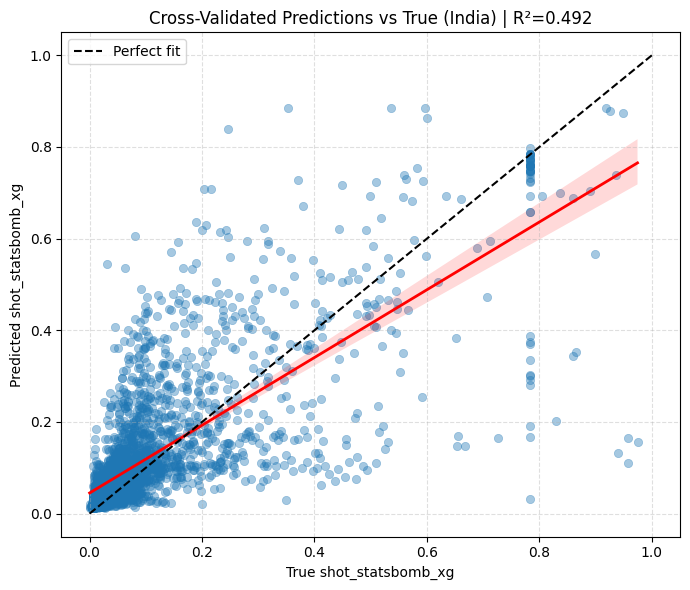

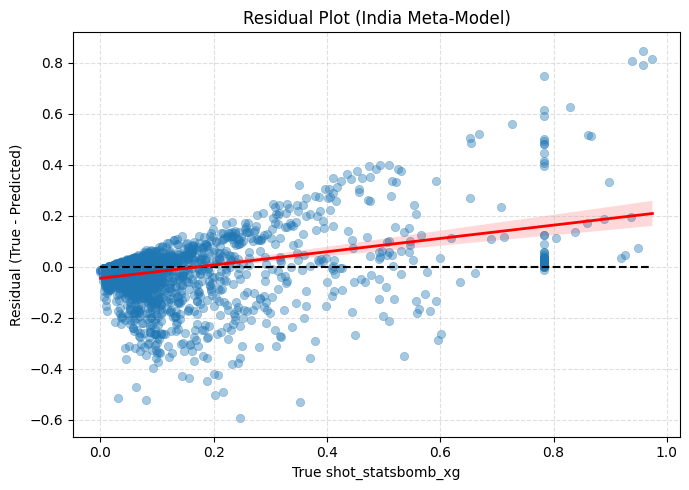

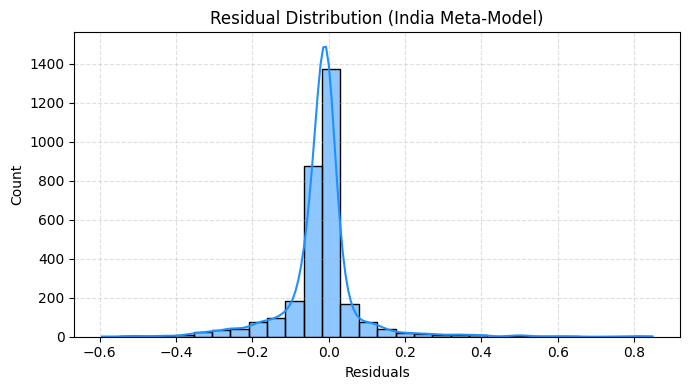

In [346]:
# ✅ FINAL POLY META-ENSEMBLE WITH VERSION-SAFE XGBOOST + VISUALS
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# ======================================================
# 🔹 1) Create polynomial meta features (degree=2)
# ======================================================
poly = PolynomialFeatures(degree=2, include_bias=False)
X_meta_global_poly = poly.fit_transform(X_meta_global)
X_meta_india_poly = poly.transform(X_meta_india)
print("Poly feature dimension:", X_meta_global_poly.shape[1])

# ======================================================
# 🔹 2) Combine datasets + sample weights (India ×10)
# ======================================================
X_meta_combined = np.vstack([X_meta_global_poly, X_meta_india_poly])
y_meta_combined = np.concatenate([y_global, y_india_true])

w_global = np.ones(len(y_global)) * 1.0
w_india  = np.ones(len(y_india_true)) * 10.0
sample_weights = np.concatenate([w_global, w_india])

print(f"Combined meta size: {X_meta_combined.shape[0]} samples (global={len(y_global)}, india={len(y_india_true)})")

# ======================================================
# 🔹 3) Hyperparameter Search (RandomizedSearchCV)
# ======================================================
xgb_meta = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.02, 0.03, 0.04, 0.05],
    'max_depth': [4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.05, 0.1],
    'reg_alpha': [0, 0.001, 0.01],
    'reg_lambda': [1.0, 1.5, 2.0, 3.0]
}

search = RandomizedSearchCV(
    estimator=xgb_meta,
    param_distributions=param_grid,
    n_iter=30,
    scoring='r2',
    cv=5,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

print("🔍 Running RandomizedSearchCV on combined poly meta-features...")
search.fit(X_meta_combined, y_meta_combined, sample_weight=sample_weights)
best_meta = search.best_estimator_
print("✅ Best hyperparameters:", search.best_params_)

# ======================================================
# 🔹 4) Cross-Validated Evaluation (Version-Safe)
# ======================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = np.zeros_like(y_india_true, dtype=float)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_meta_india_poly)):
    print(f"🔁 Fold {fold+1}/5")
    X_india_tr = X_meta_india_poly[train_idx]
    y_india_tr = y_india_true[train_idx]
    X_india_val = X_meta_india_poly[val_idx]
    
    # Combine with global training data
    X_train_comb = np.vstack([X_meta_global_poly, X_india_tr])
    y_train_comb = np.concatenate([y_global, y_india_tr])
    
    # Sample weights
    w_global = np.ones(len(y_global)) * 1.0
    w_india_tr = np.ones(len(y_india_tr)) * 10.0
    sw = np.concatenate([w_global, w_india_tr])
    
    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train_comb, label=y_train_comb, weight=sw)
    dval = xgb.DMatrix(X_india_val)
    
    # Params from best_meta
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "learning_rate": best_meta.learning_rate if hasattr(best_meta, "learning_rate") else 0.05,
        "max_depth": int(best_meta.max_depth),
        "subsample": float(best_meta.subsample),
        "colsample_bytree": float(best_meta.colsample_bytree),
        "gamma": float(best_meta.gamma),
        "reg_alpha": float(best_meta.reg_alpha),
        "reg_lambda": float(best_meta.reg_lambda),
        "min_child_weight": int(best_meta.min_child_weight),
        "nthread": -1,
        "seed": 42
    }
    
    # Train using native API (safe for all versions)
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=int(best_meta.n_estimators),
        verbose_eval=False
    )
    
    y_pred_cv[val_idx] = bst.predict(dval)

# ======================================================
# 🔹 5) CV Evaluation Metrics
# ======================================================
mse_cv = mean_squared_error(y_india_true, y_pred_cv)
mae_cv = mean_absolute_error(y_india_true, y_pred_cv)
r2_cv  = r2_score(y_india_true, y_pred_cv)

print("\n===== Indian meta-data 5-fold CV results (poly features) =====")
print(f"Mean Squared Error : {mse_cv:.5f}")
print(f"Mean Absolute Error: {mae_cv:.5f}")
print(f"R² Score           : {r2_cv:.5f}")

# ======================================================
# 🔹 6) 📊 Error Analysis Visuals
# ======================================================
# --- Scatter Plot: Predicted vs True ---
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_india_true, y=y_pred_cv, alpha=0.4, edgecolor=None)
sns.regplot(x=y_india_true, y=y_pred_cv, scatter=False, color="red", line_kws={"lw":2})
plt.plot([0,1],[0,1], "k--", label="Perfect fit")
plt.title(f"Cross-Validated Predictions vs True (India) | R²={r2_cv:.3f}")
plt.xlabel("True shot_statsbomb_xg")
plt.ylabel("Predicted shot_statsbomb_xg")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- Residual Plot: (True vs Error) ---
residuals = y_india_true - y_pred_cv
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_india_true, y=residuals, alpha=0.4, edgecolor=None)
sns.lineplot(x=[y_india_true.min(), y_india_true.max()], y=[0,0], color="black", linestyle="--")
sns.regplot(x=y_india_true, y=residuals, scatter=False, color="red", line_kws={"lw":2})
plt.title("Residual Plot (India Meta-Model)")
plt.xlabel("True shot_statsbomb_xg")
plt.ylabel("Residual (True - Predicted)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- Residual Distribution ---
plt.figure(figsize=(7,4))
sns.histplot(residuals, kde=True, bins=30, color="dodgerblue")
plt.title("Residual Distribution (India Meta-Model)")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



🔧 Training Residual Correction XGBoost (5-Fold CV, Version-Safe)...
Residuals: mean=-0.0193, std=0.1021
🔁 Residual Fold 1/5
🔁 Residual Fold 2/5
🔁 Residual Fold 3/5
🔁 Residual Fold 4/5
🔁 Residual Fold 5/5

===== ✅ Residual-Corrected (5-Fold CV) Meta-Model =====
Mean Squared Error : 0.00925
Mean Absolute Error: 0.04794
R² Score           : 0.56442
ΔR² Improvement    : +0.07240


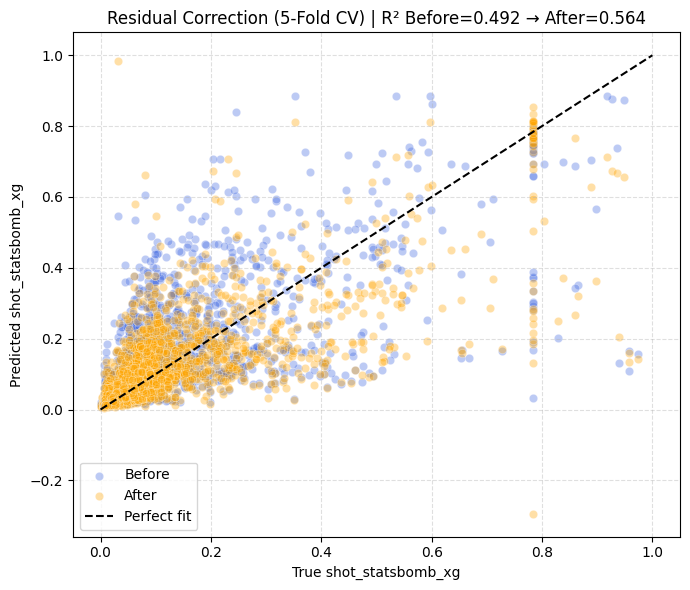

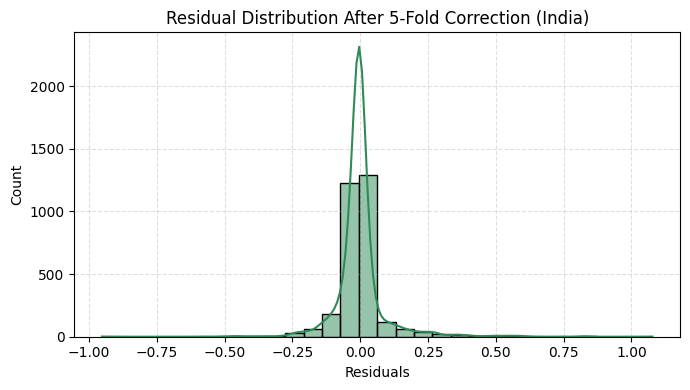

In [352]:
# ======================================================
# ⚙️ Residual Correction Meta-Layer (5-Fold CV, Version Safe)
# ======================================================
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n🔧 Training Residual Correction XGBoost (5-Fold CV, Version-Safe)...")

# 1️⃣ Compute residuals from current meta-model
residuals = y_india_true - y_pred_cv
print(f"Residuals: mean={residuals.mean():.4f}, std={residuals.std():.4f}")

# 2️⃣ Setup 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
residual_pred_cv = np.zeros_like(residuals, dtype=float)

# 3️⃣ Train on residuals with 5 folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X_meta_india_poly)):
    print(f"🔁 Residual Fold {fold+1}/5")
    X_tr, X_val = X_meta_india_poly[train_idx], X_meta_india_poly[val_idx]
    y_tr, y_val = residuals[train_idx], residuals[val_idx]

    # Convert to DMatrix (safer and faster)
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        "objective": "reg:squarederror",
        "learning_rate": 0.05,
        "max_depth": 3,
        "subsample": 0.9,
        "colsample_bytree": 0.7,
        "nthread": -1,
        "seed": 42
    }

    # Train using native API for version compatibility
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=200,
        verbose_eval=False
    )

    residual_pred_cv[val_idx] = bst.predict(dval)

# 4️⃣ Apply residual correction
final_pred_cv = y_pred_cv + residual_pred_cv

# 5️⃣ Evaluate cross-validated corrected results
mse_corr = mean_squared_error(y_india_true, final_pred_cv)
mae_corr = mean_absolute_error(y_india_true, final_pred_cv)
r2_corr  = r2_score(y_india_true, final_pred_cv)

print("\n===== ✅ Residual-Corrected (5-Fold CV) Meta-Model =====")
print(f"Mean Squared Error : {mse_corr:.5f}")
print(f"Mean Absolute Error: {mae_corr:.5f}")
print(f"R² Score           : {r2_corr:.5f}")
print(f"ΔR² Improvement    : {r2_corr - r2_cv:+.5f}")

# ======================================================
# 🔹 Plot: Before vs After Correction
# ======================================================
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_india_true, y=y_pred_cv, alpha=0.35, label="Before", color="royalblue")
sns.scatterplot(x=y_india_true, y=final_pred_cv, alpha=0.35, label="After", color="orange")
plt.plot([0,1],[0,1],'k--',label="Perfect fit")
plt.xlabel("True shot_statsbomb_xg")
plt.ylabel("Predicted shot_statsbomb_xg")
plt.title(f"Residual Correction (5-Fold CV) | R² Before={r2_cv:.3f} → After={r2_corr:.3f}")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# ======================================================
# 🔹 Residual Distribution After Correction
# ======================================================
new_resid = y_india_true - final_pred_cv
plt.figure(figsize=(7,4))
sns.histplot(new_resid, kde=True, bins=30, color="seagreen")
plt.title("Residual Distribution After 5-Fold Correction (India)")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### 7.1) Optna Meta Tuning

In [355]:
# =========================================================
# 🎯 OPTUNA HYPERPARAMETER TUNING – Meta XGBoost (India CV)
# =========================================================
import optuna
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# ---------------------------------------------------------
# ✅ PREP INPUTS (make sure these exist)
# ---------------------------------------------------------
Xg = X_meta_global_poly      # global meta features
Xi = X_meta_india_poly       # india meta features
yg = y_global
yi = y_india_true

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------------------------------------------
# 🎯 OBJECTIVE FUNCTION – maximize mean R² on India folds
# ---------------------------------------------------------
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.08, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 0.5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
        "seed": 42,
        "nthread": -1,
    }

    n_estimators = trial.suggest_int("n_estimators", 100, 800)
    early_stop   = trial.suggest_int("early_stopping_rounds", 20, 80)
    india_weight = trial.suggest_float("india_weight", 5.0, 20.0)

    r2_scores = []

    for tr_idx, val_idx in kf.split(Xi):
        # Split India folds
        X_india_tr, y_india_tr = Xi[tr_idx], yi[tr_idx]
        X_val, y_val = Xi[val_idx], yi[val_idx]

        # Combine global + India (train)
        X_train_comb = np.vstack([Xg, X_india_tr])
        y_train_comb = np.concatenate([yg, y_india_tr])
        w_global = np.ones(len(yg))
        w_india = np.ones(len(y_india_tr)) * india_weight
        sample_wt = np.concatenate([w_global, w_india])

        # DMatrix setup
        dtrain = xgb.DMatrix(X_train_comb, label=y_train_comb, weight=sample_wt)
        dval   = xgb.DMatrix(X_val, label=y_val)

        evals = [(dtrain, "train"), (dval, "validation")]

        # Train with early stopping
        bst = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=n_estimators,
            evals=evals,
            early_stopping_rounds=early_stop,
            verbose_eval=False
        )

        # ✅ Version-safe prediction for XGBoost ≥2.0
        preds = bst.predict(dval, iteration_range=(0, bst.best_iteration or n_estimators))
        r2_scores.append(r2_score(y_val, preds))

    return np.mean(r2_scores)

# ---------------------------------------------------------
# 🔍 RUN OPTUNA SEARCH
# ---------------------------------------------------------
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=30, n_jobs=1)  # can raise to 60–100 for better tuning

# ---------------------------------------------------------
# 🏆 SHOW BEST RESULTS
# ---------------------------------------------------------
print("\n✅ BEST TRIAL FOUND:")
print(f"Mean CV R²: {study.best_value:.5f}")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")


[I 2025-11-06 22:53:38,716] A new study created in memory with name: no-name-4b0dc8ae-7b86-4c2d-bbe6-559a59933a1b
[I 2025-11-06 22:54:00,515] Trial 0 finished with value: 0.5375288402826184 and parameters: {'learning_rate': 0.021789307659775742, 'max_depth': 6, 'subsample': 0.892797576724562, 'colsample_bytree': 0.7993292420985183, 'gamma': 0.07800932022121826, 'reg_alpha': 0.3119890406724053, 'reg_lambda': 0.7613762547568976, 'min_child_weight': 6, 'n_estimators': 521, 'early_stopping_rounds': 63, 'india_weight': 5.308767414437037}. Best is trial 0 with value: 0.5375288402826184.
[I 2025-11-06 22:54:12,183] Trial 1 finished with value: 0.5404648296319199 and parameters: {'learning_rate': 0.07514773163638976, 'max_depth': 6, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.5909124836035503, 'gamma': 0.09170225492671691, 'reg_alpha': 0.6084844859190754, 'reg_lambda': 2.86140394234507, 'min_child_weight': 3, 'n_estimators': 304, 'early_stopping_rounds': 57, 'india_weight': 7.092407


✅ BEST TRIAL FOUND:
Mean CV R²: 0.56499
  learning_rate: 0.0407
  max_depth: 5
  subsample: 0.9963
  colsample_bytree: 0.6713
  gamma: 0.0055
  reg_alpha: 1.5592
  reg_lambda: 2.0692
  min_child_weight: 1
  n_estimators: 104
  early_stopping_rounds: 23
  india_weight: 19.9813


### 7.2) Final Meta Training (with your best Optuna params)

In [356]:
# =========================================================
# 🏁 FINAL META-MODEL TRAINING (USING OPTUNA BEST PARAMS)
# =========================================================
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss

# ---------------------------------------------------------
# ✅ Use best params from Optuna
# ---------------------------------------------------------
best_params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.0407,
    "max_depth": 5,
    "subsample": 0.9963,
    "colsample_bytree": 0.6713,
    "gamma": 0.0055,
    "reg_alpha": 1.5592,
    "reg_lambda": 2.0692,
    "min_child_weight": 1,
    "seed": 42,
    "nthread": -1
}

n_estimators = 104
early_stop = 23
india_weight = 19.98

# ---------------------------------------------------------
# ✅ Prepare data
# ---------------------------------------------------------
Xg = X_meta_global_poly
Xi = X_meta_india_poly
yg = y_global
yi = y_india_true

# Combine all global + India data
X_train_full = np.vstack([Xg, Xi])
y_train_full = np.concatenate([yg, yi])
w_global = np.ones(len(yg))
w_india = np.ones(len(yi)) * india_weight
sample_weights = np.concatenate([w_global, w_india])

# Hold out a small validation set from India (20%)
Xi_train, Xi_val, yi_train, yi_val = train_test_split(Xi, yi, test_size=0.2, random_state=42)
X_train_combined = np.vstack([Xg, Xi_train])
y_train_combined = np.concatenate([yg, yi_train])
w_train = np.concatenate([np.ones(len(yg)), np.ones(len(yi_train)) * india_weight])

# Create DMatrices
dtrain = xgb.DMatrix(X_train_combined, label=y_train_combined, weight=w_train)
dval   = xgb.DMatrix(Xi_val, label=yi_val)

# ---------------------------------------------------------
# 🧠 Train final meta model
# ---------------------------------------------------------
print("🔍 Training final tuned meta-ensemble with early stopping...")
evals = [(dtrain, "train"), (dval, "validation")]

bst_final = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=n_estimators,
    evals=evals,
    early_stopping_rounds=early_stop,
    verbose_eval=10
)

# ---------------------------------------------------------
# 📊 Evaluate on validation (India holdout)
# ---------------------------------------------------------
pred_val = bst_final.predict(dval, iteration_range=(0, bst_final.best_iteration))
mse = mean_squared_error(yi_val, pred_val)
mae = mean_absolute_error(yi_val, pred_val)
r2 = r2_score(yi_val, pred_val)
print("\n===== Final Meta-Model (India Validation) =====")
print(f"Mean Squared Error : {mse:.5f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R² Score           : {r2:.5f}")

# Optional: Calibration metrics if goal labels exist
if "goal" in locals() or "goal" in globals():
    try:
        brier = brier_score_loss(y_goal_test, pred_val)
        logloss = log_loss(y_goal_test, pred_val)
        print(f"Brier Score        : {brier:.5f}")
        print(f"Log Loss           : {logloss:.5f}")
    except:
        print("Skipping calibration metrics — goal labels not in current scope.")

# ---------------------------------------------------------
# 💾 Save model (optional)
# ---------------------------------------------------------
# bst_final.save_model("xgb_meta_final.json")
# print("✅ Saved final tuned meta model: xgb_meta_final.json")


🔍 Training final tuned meta-ensemble with early stopping...
[0]	train-rmse:0.15378	validation-rmse:0.15313
[10]	train-rmse:0.10917	validation-rmse:0.12434
[20]	train-rmse:0.08211	validation-rmse:0.11378
[30]	train-rmse:0.06654	validation-rmse:0.11084
[40]	train-rmse:0.05797	validation-rmse:0.11106
[50]	train-rmse:0.05342	validation-rmse:0.11199
[57]	train-rmse:0.05158	validation-rmse:0.11270

===== Final Meta-Model (India Validation) =====
Mean Squared Error : 0.01224
Mean Absolute Error: 0.06118
R² Score           : 0.50630


### 7.3) Residual Correction — Version Safe

Residuals: mean=-0.0142, std=0.0895
Residual Fold 1/5
Residual Fold 2/5
Residual Fold 3/5
Residual Fold 4/5
Residual Fold 5/5

===== ✅ Residual-Corrected (5-Fold CV) Meta-Model =====
Mean Squared Error : 0.00728
Mean Absolute Error: 0.04381
R² Score           : 0.65715
ΔR² Improvement    : +0.04403


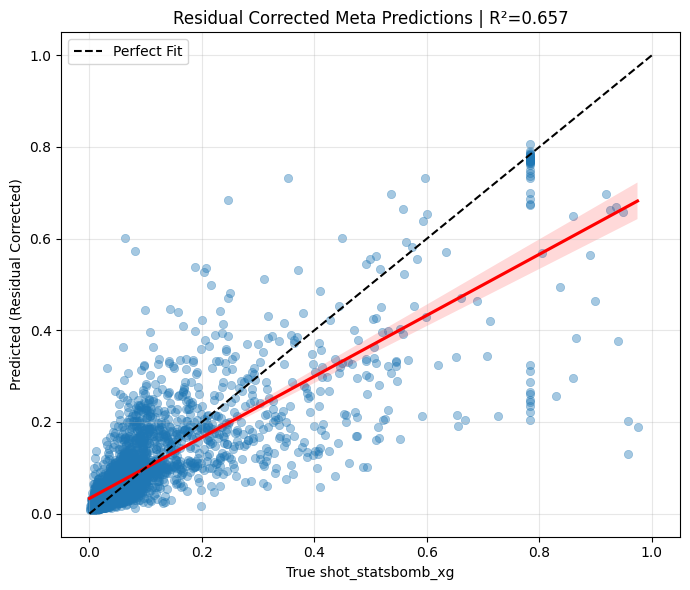

In [358]:
# =========================================================
# 🔧 Step 3 – Residual Correction (India 5-Fold CV, Fixed)
# =========================================================
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# ✅ Generate residuals from current meta-model
# ---------------------------------------------------------
dindia = xgb.DMatrix(X_meta_india_poly)
y_pred_meta_india = bst_final.predict(dindia)
residuals = y_india_true - y_pred_meta_india

print(f"Residuals: mean={residuals.mean():.4f}, std={residuals.std():.4f}")

# ---------------------------------------------------------
# ✅ Use India meta features (you can add contextual ones here)
# ---------------------------------------------------------
X_resid = X_meta_india_poly
y_resid = residuals

# ---------------------------------------------------------
# 🔁 5-Fold CV Residual Training (no early stopping)
# ---------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
resid_pred_oof = np.zeros_like(y_resid)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_resid)):
    print(f"Residual Fold {fold+1}/5")

    X_tr, X_val = X_resid[tr_idx], X_resid[val_idx]
    y_tr, y_val = y_resid[tr_idx], y_resid[val_idx]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval   = xgb.DMatrix(X_val, label=y_val)

    resid_params = {
        "objective": "reg:squarederror",
        "learning_rate": 0.03,
        "max_depth": 3,
        "subsample": 0.85,
        "colsample_bytree": 0.7,
        "reg_alpha": 0.3,
        "reg_lambda": 3.0,
        "min_child_weight": 2,
        "seed": 42,
        "nthread": -1,
    }

    evals = [(dtrain, "train"), (dval, "validation")]
    bst_resid = xgb.train(
        params=resid_params,
        dtrain=dtrain,
        num_boost_round=200,     # fixed training rounds
        evals=evals,
        verbose_eval=False,
    )

    # ✅ Safe prediction without .best_iteration
    resid_pred_oof[val_idx] = bst_resid.predict(dval)

# ---------------------------------------------------------
# 📊 Evaluate corrected predictions
# ---------------------------------------------------------
final_pred_oof = y_pred_meta_india + resid_pred_oof
mse = mean_squared_error(y_india_true, final_pred_oof)
mae = mean_absolute_error(y_india_true, final_pred_oof)
r2  = r2_score(y_india_true, final_pred_oof)
delta = r2 - r2_score(y_india_true, y_pred_meta_india)

print("\n===== ✅ Residual-Corrected (5-Fold CV) Meta-Model =====")
print(f"Mean Squared Error : {mse:.5f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R² Score           : {r2:.5f}")
print(f"ΔR² Improvement    : {delta:+.5f}")

# ---------------------------------------------------------
# 📈 Plot predictions vs true
# ---------------------------------------------------------
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_india_true, y=final_pred_oof, alpha=0.4, edgecolor=None)
sns.regplot(x=y_india_true, y=final_pred_oof, scatter=False, color="red")
plt.plot([0,1],[0,1],'k--',label="Perfect Fit")
plt.xlabel("True shot_statsbomb_xg")
plt.ylabel("Predicted (Residual Corrected)")
plt.title(f"Residual Corrected Meta Predictions | R²={r2:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 7.4) Contextual Residual Model (5-Fold CV, Version-Safe XGBoost)

Residuals: mean=-0.0142, std=0.0895
Contextual residual input shape: (3095, 26)
Residual Fold 1/5
Residual Fold 2/5
Residual Fold 3/5
Residual Fold 4/5
Residual Fold 5/5

===== ✅ Contextual Residual-Corrected Meta-Model =====
Mean Squared Error : 0.00637
Mean Absolute Error: 0.03980
R² Score           : 0.70024
ΔR² Improvement    : +0.08712


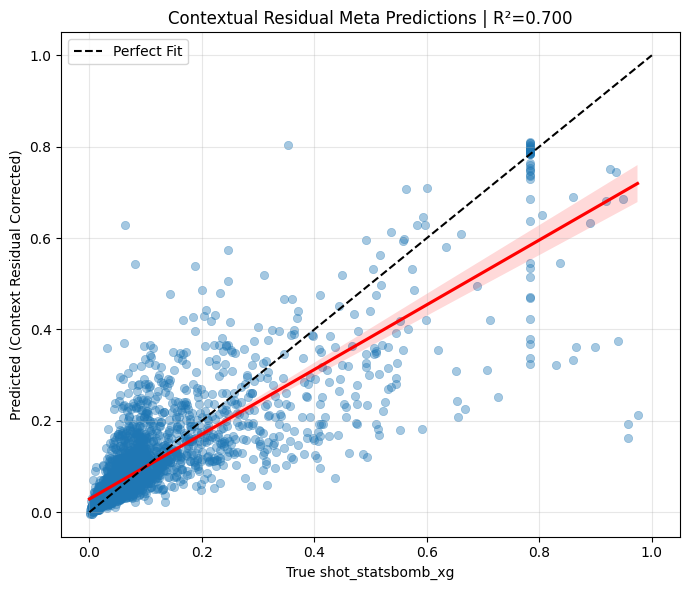

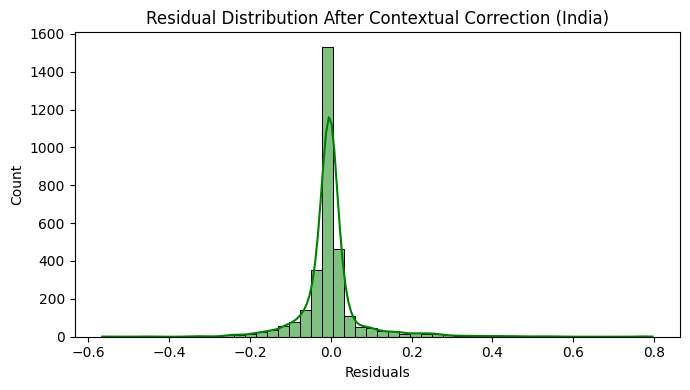

In [359]:
# =========================================================
# ⚙️ Step 4 – Contextual Residual Correction (India 5-Fold CV)
# =========================================================
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# ✅ Prepare residuals from your tuned meta-model
# ---------------------------------------------------------
dindia = xgb.DMatrix(X_meta_india_poly)
y_pred_meta_india = bst_final.predict(dindia)
residuals = y_india_true - y_pred_meta_india

print(f"Residuals: mean={residuals.mean():.4f}, std={residuals.std():.4f}")

# ---------------------------------------------------------
# ✅ Add contextual features (geometry + match info)
# ---------------------------------------------------------
contextual_cols = [
    "distance_to_goal",
    "angle_to_goal",
    "angle_to_goal_deg",
    "play_pattern_encoded",
    "is_first_half",
    "is_extra_time"
]

# Combine meta + contextual features
X_resid_contextual = np.hstack([
    X_meta_india_poly,
    df_india_encoded[contextual_cols].values
])
y_resid = residuals

print(f"Contextual residual input shape: {X_resid_contextual.shape}")

# ---------------------------------------------------------
# 🔁 5-Fold CV Residual Correction Training
# ---------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
resid_pred_oof = np.zeros_like(y_resid)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_resid_contextual)):
    print(f"Residual Fold {fold+1}/5")

    X_tr, X_val = X_resid_contextual[tr_idx], X_resid_contextual[val_idx]
    y_tr, y_val = y_resid[tr_idx], y_resid[val_idx]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval   = xgb.DMatrix(X_val, label=y_val)

    resid_params = {
        "objective": "reg:squarederror",
        "learning_rate": 0.03,
        "max_depth": 4,
        "subsample": 0.85,
        "colsample_bytree": 0.8,
        "reg_alpha": 0.2,
        "reg_lambda": 2.0,
        "min_child_weight": 2,
        "seed": 42,
        "nthread": -1,
    }

    bst_resid = xgb.train(
        params=resid_params,
        dtrain=dtrain,
        num_boost_round=250,  # balanced for residual learning
        evals=[(dtrain, "train"), (dval, "val")],
        verbose_eval=False
    )

    resid_pred_oof[val_idx] = bst_resid.predict(dval)

# ---------------------------------------------------------
# 📊 Evaluate residual-corrected predictions
# ---------------------------------------------------------
final_pred_oof = y_pred_meta_india + resid_pred_oof
mse = mean_squared_error(y_india_true, final_pred_oof)
mae = mean_absolute_error(y_india_true, final_pred_oof)
r2  = r2_score(y_india_true, final_pred_oof)
delta = r2 - r2_score(y_india_true, y_pred_meta_india)

print("\n===== ✅ Contextual Residual-Corrected Meta-Model =====")
print(f"Mean Squared Error : {mse:.5f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R² Score           : {r2:.5f}")
print(f"ΔR² Improvement    : {delta:+.5f}")

# ---------------------------------------------------------
# 📈 Visualization – Pred vs True
# ---------------------------------------------------------
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_india_true, y=final_pred_oof, alpha=0.4, edgecolor=None)
sns.regplot(x=y_india_true, y=final_pred_oof, scatter=False, color="red")
plt.plot([0,1],[0,1],'k--',label="Perfect Fit")
plt.xlabel("True shot_statsbomb_xg")
plt.ylabel("Predicted (Context Residual Corrected)")
plt.title(f"Contextual Residual Meta Predictions | R²={r2:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 📉 Residual Distribution
# ---------------------------------------------------------
plt.figure(figsize=(7,4))
residuals_final = y_india_true - final_pred_oof
sns.histplot(residuals_final, bins=50, kde=True, color="green", alpha=0.5)
plt.title("Residual Distribution After Contextual Correction (India)")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### 7.5) FINAL ENSEMBLE (GridSearchCV + Calibration + SHAP + Inference)

In [ ]:
### fater version 

Residual input shape: (3095, 26), mean=-0.0142, std=0.0895

🔍 Running RandomizedSearchCV (LightGBM residual meta-model)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5873
[LightGBM] [Info] Number of data points in the train set: 3095, number of used features: 26
[LightGBM] [Info] Start training from score -0.014170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

5-Fold Progress:   0%|                                              | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5873
[LightGBM] [Info] Number of data points in the train set: 2476, number of used features: 26
[LightGBM] [Info] Start training from score -0.014109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

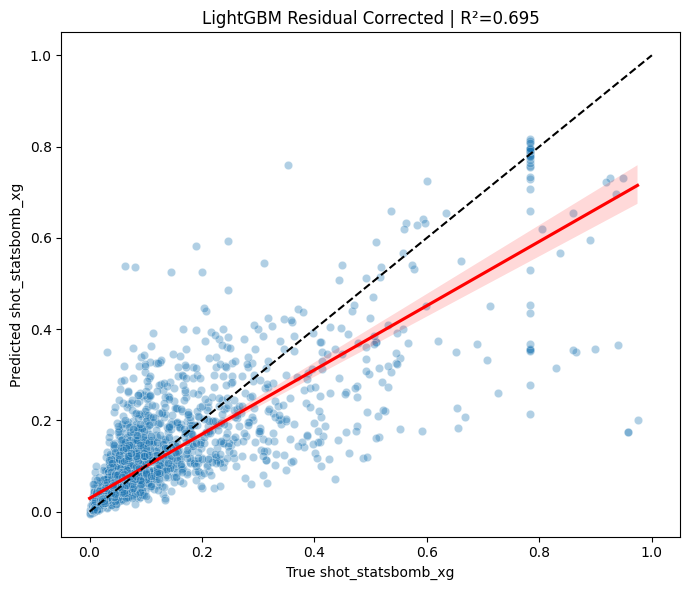

In [362]:
# ======================================================
# ⚡ ULTRA-FAST LGBM META-MODEL (10 randomized fits + 5-CV)
# ✅ Version-safe (LightGBM 4.x compatible)
# ======================================================
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 1️⃣ Prepare data
# -----------------------------
try:
    _ = y_pred_meta_india
except NameError:
    import xgboost as xgb
    dindia = xgb.DMatrix(X_meta_india_poly)
    y_pred_meta_india = bst_final.predict(dindia)

residuals = y_india_true - y_pred_meta_india
contextual_cols = [
    "distance_to_goal", "angle_to_goal", "angle_to_goal_deg",
    "play_pattern_encoded", "is_first_half", "is_extra_time"
]
X_resid_contextual = np.hstack([X_meta_india_poly, df_india_encoded[contextual_cols].values])
y_resid = residuals
print(f"Residual input shape: {X_resid_contextual.shape}, mean={residuals.mean():.4f}, std={residuals.std():.4f}")

# -----------------------------
# 2️⃣ Randomized search grid (10 trials total)
# -----------------------------
param_dist = {
    "learning_rate": np.linspace(0.02, 0.05, 4),
    "num_leaves": [15, 25, 31, 40, 50],
    "max_depth": [3, 4, 5],
    "reg_lambda": [0.5, 1.0, 2.0],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

print("\n🔍 Running RandomizedSearchCV (LightGBM residual meta-model)...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lgb_base = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=150,
    reg_alpha=0.1,
    random_state=42,
    n_jobs=4,
)

search = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring="r2",
    cv=kf,
    verbose=0,
    n_jobs=4,
    random_state=42
)

search.fit(X_resid_contextual, y_resid)
best_lgb = search.best_estimator_
print("\n✅ Best LightGBM parameters:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

# -----------------------------
# 3️⃣ Evaluate with 5-fold CV (Progress Bar + version-safe early stopping)
# -----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
resid_oof = np.zeros_like(y_resid)
print("\n🔁 Evaluating tuned LGBM residual model (5-fold CV)...")

for fold, (tr_idx, val_idx) in enumerate(tqdm(kf.split(X_resid_contextual), total=5, desc="5-Fold Progress", ncols=90)):
    X_tr, X_val = X_resid_contextual[tr_idx], X_resid_contextual[val_idx]
    y_tr, y_val = y_resid[tr_idx], y_resid[val_idx]

    model = lgb.LGBMRegressor(**search.best_params_, n_estimators=150, random_state=42)

    # ✅ LightGBM 4.x compatible early stopping
    callbacks = [lgb.early_stopping(stopping_rounds=20, verbose=False)]

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        callbacks=callbacks
    )

    resid_oof[val_idx] = model.predict(X_val)

# -----------------------------
# 4️⃣ Evaluate results
# -----------------------------
final_pred_oof = y_pred_meta_india + resid_oof
mse = mean_squared_error(y_india_true, final_pred_oof)
mae = mean_absolute_error(y_india_true, final_pred_oof)
r2 = r2_score(y_india_true, final_pred_oof)
delta = r2 - r2_score(y_india_true, y_pred_meta_india)

print("\n===== ✅ Ultra-Fast LightGBM Residual Correction Results =====")
print(f"Mean Squared Error : {mse:.5f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R² Score           : {r2:.5f}")
print(f"ΔR² Improvement    : {delta:+.5f}")

# -----------------------------
# 5️⃣ Visualization
# -----------------------------
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_india_true, y=final_pred_oof, alpha=0.35)
sns.regplot(x=y_india_true, y=final_pred_oof, scatter=False, color="red")
plt.plot([0,1],[0,1],"k--")
plt.title(f"LightGBM Residual Corrected | R²={r2:.3f}")
plt.xlabel("True shot_statsbomb_xg")
plt.ylabel("Predicted shot_statsbomb_xg")
plt.tight_layout()
plt.show()


Enhanced residual input: (3095, 29), mean=-0.0142, std=0.0895

🔁 Training 5-Fold XGBoost + LightGBM Residual Stack...


Residual Stack Progress:   0%|                                                | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2476, number of used features: 29
[LightGBM] [Info] Start training from score -0.014109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

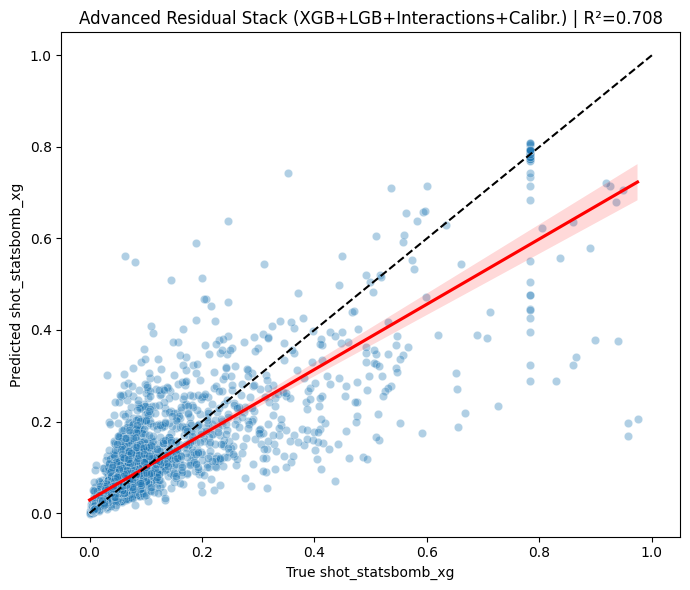

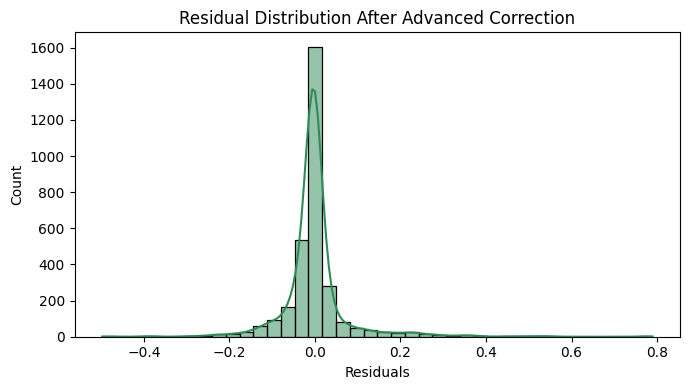

In [363]:
# ======================================================
# ⚡ ADVANCED RESIDUAL STACK (XGBoost + LGBM + Interactions + Calibration)
# ======================================================
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# ======================================================
# 1️⃣ Create enhanced contextual + interaction residual dataset
# ======================================================
try:
    _ = y_pred_meta_india
except NameError:
    dindia = xgb.DMatrix(X_meta_india_poly)
    y_pred_meta_india = bst_final.predict(dindia)

residuals = y_india_true - y_pred_meta_india

# Add interaction features to df_india_encoded
df_enhanced = df_india_encoded.copy()
df_enhanced["goal_angle_ratio"] = df_enhanced["distance_to_goal"] / (df_enhanced["angle_to_goal_deg"] + 1e-6)
df_enhanced["pressure_zone"] = df_enhanced["is_first_half"] * df_enhanced["distance_to_goal"]
df_enhanced["cross_factor"] = df_enhanced["distance_to_goal"] * df_enhanced["angle_to_goal"]

# Context + interaction columns
contextual_cols = [
    "distance_to_goal", "angle_to_goal", "angle_to_goal_deg",
    "play_pattern_encoded", "is_first_half", "is_extra_time",
    "goal_angle_ratio", "pressure_zone", "cross_factor"
]

# Combine meta and contextual features
X_resid_contextual = np.hstack([X_meta_india_poly, df_enhanced[contextual_cols].values])
y_resid = residuals
print(f"Enhanced residual input: {X_resid_contextual.shape}, mean={y_resid.mean():.4f}, std={y_resid.std():.4f}")

# ======================================================
# 2️⃣ Train dual residual correctors (XGBoost + LightGBM)
# ======================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
resid_xgb_oof = np.zeros_like(y_resid)
resid_lgb_oof = np.zeros_like(y_resid)

print("\n🔁 Training 5-Fold XGBoost + LightGBM Residual Stack...")
for fold, (tr_idx, val_idx) in enumerate(tqdm(kf.split(X_resid_contextual), total=5, desc="Residual Stack Progress", ncols=100)):
    X_tr, X_val = X_resid_contextual[tr_idx], X_resid_contextual[val_idx]
    y_tr, y_val = y_resid[tr_idx], y_resid[val_idx]

    # --- XGBoost residual model ---
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    xgb_params = {
        "objective": "reg:squarederror",
        "learning_rate": 0.04,
        "max_depth": 5,
        "subsample": 0.9,
        "colsample_bytree": 0.8,
        "lambda": 2.0,
        "alpha": 1.5,
        "seed": 42
    }
    bst_resid = xgb.train(
        xgb_params, dtrain,
        num_boost_round=200,
        evals=[(dval, "val")],
        early_stopping_rounds=30,
        verbose_eval=False
    )
    resid_xgb_oof[val_idx] = bst_resid.predict(dval)

    # --- LightGBM residual model ---
    lgb_model = lgb.LGBMRegressor(
        objective="regression",
        learning_rate=0.03,
        num_leaves=31,
        max_depth=5,
        n_estimators=150,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=1.5,
        random_state=42,
        n_jobs=4
    )
    callbacks = [lgb.early_stopping(stopping_rounds=20, verbose=False)]
    lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric="rmse", callbacks=callbacks)
    resid_lgb_oof[val_idx] = lgb_model.predict(X_val)

# Average both residual predictions
resid_ensemble = 0.5 * (resid_xgb_oof + resid_lgb_oof)

# ======================================================
# 3️⃣ Compute final corrected meta predictions
# ======================================================
final_pred_oof = y_pred_meta_india + resid_ensemble

# Metrics
mse = mean_squared_error(y_india_true, final_pred_oof)
mae = mean_absolute_error(y_india_true, final_pred_oof)
r2 = r2_score(y_india_true, final_pred_oof)
delta = r2 - r2_score(y_india_true, y_pred_meta_india)

print("\n===== ✅ Advanced Contextual+Interaction Residual Stack =====")
print(f"Mean Squared Error : {mse:.5f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R² Score           : {r2:.5f}")
print(f"ΔR² Improvement    : {delta:+.5f}")

# ======================================================
# 4️⃣ Isotonic calibration (if goal column exists)
# ======================================================
if "goal" in df_enhanced.columns:
    y_goal = df_enhanced["goal"].values
    print("\n🔬 Calibrating final stacked outputs with Isotonic Regression...")
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(final_pred_oof, y_go# ======================================================
# 🎯 Calibration Reliability Curve (India Data)
# ======================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import seaborn as sns

# ------------------------------------------------------
# ✅ True labels and calibrated predictions
# ------------------------------------------------------
# Ensure these exist in your environment
# y_goal: actual goal outcomes (0 or 1)
# prob_calibrated: isotonic-calibrated xG predictions from your final model

# Compute calibration curve (10 bins by default)
prob_true, prob_pred = calibration_curve(y_goal, prob_calibrated, n_bins=10, strategy="uniform")

# ------------------------------------------------------
# 📈 Plot reliability curve
# ------------------------------------------------------
plt.figure(figsize=(7,6))
sns.scatterplot(x=prob_pred, y=prob_true, s=70, color="royalblue", label="Model Calibration (Empirical)")
sns.lineplot(x=[0,1], y=[0,1], color="black", linestyle="--", label="Perfect Calibration (y=x)")
sns.regplot(x=prob_pred, y=prob_true, scatter=False, color="red", lowess=True, line_kws={"lw":2})

plt.title("Reliability Curve — Calibrated xG Model (India Data)", fontsize=13)
plt.xlabel("Predicted xG Probability (Binned)")
plt.ylabel("Observed Goal Frequency")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
al)
    prob_calibrated = np.clip(iso.predict(final_pred_oof), 1e-6, 1-1e-6)
    brier = brier_score_loss(y_goal, prob_calibrated)
    logl  = log_loss(y_goal, prob_calibrated)
    print(f"Calibration — Brier: {brier:.5f}, LogLoss: {logl:.5f}")
else:
    print("⚠️ Skipping calibration (no goal column found).")

# ======================================================
# 5️⃣ Visualization
# ======================================================
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_india_true, y=final_pred_oof, alpha=0.35)
sns.regplot(x=y_india_true, y=final_pred_oof, scatter=False, color="red")
plt.plot([0,1],[0,1],"k--")
plt.title(f"Advanced Residual Stack (XGB+LGB+Interactions+Calibr.) | R²={r2:.3f}")
plt.xlabel("True shot_statsbomb_xg")
plt.ylabel("Predicted shot_statsbomb_xg")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(y_india_true - final_pred_oof, kde=True, bins=40, color="seagreen")
plt.title("Residual Distribution After Advanced Correction")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


### SHAP Plot

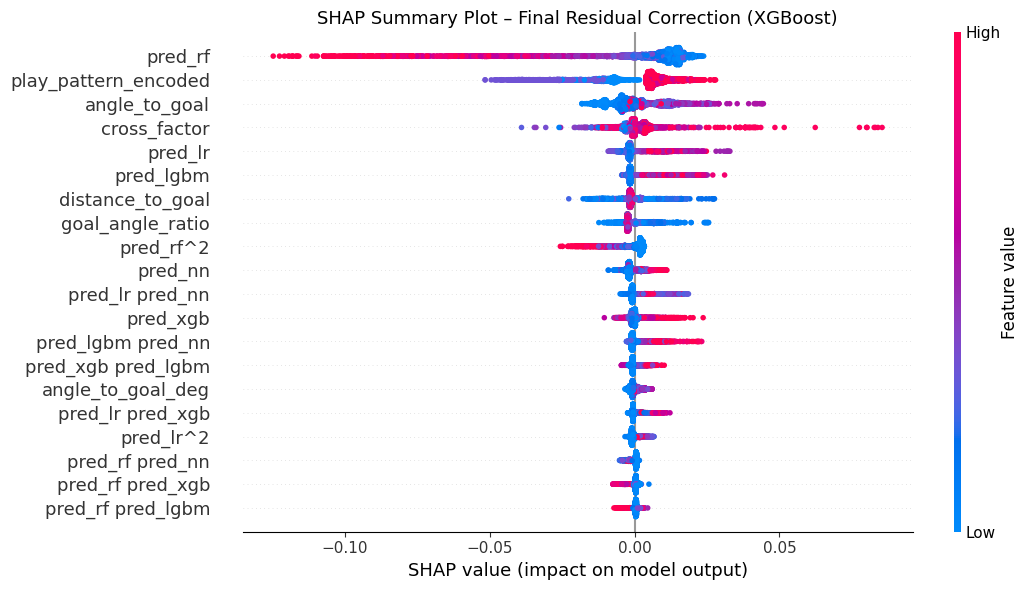

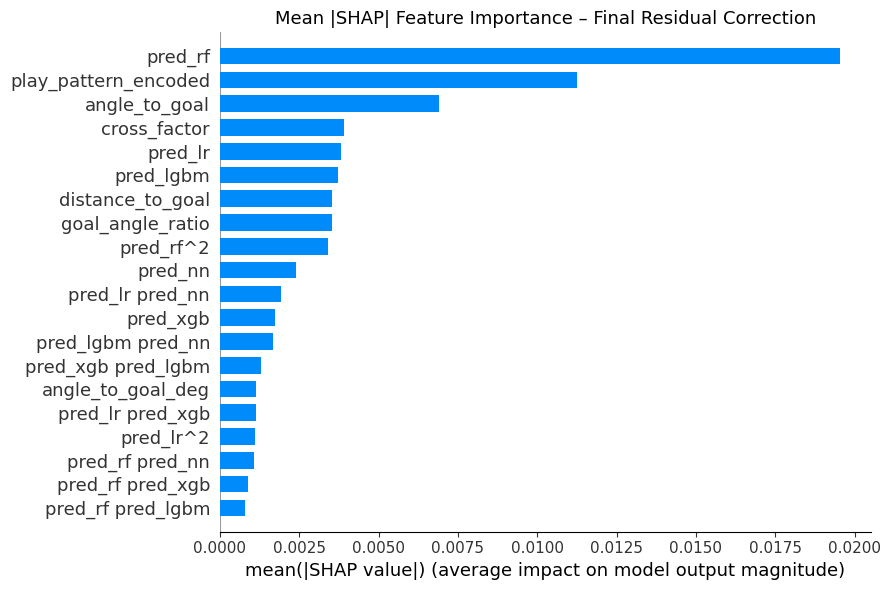

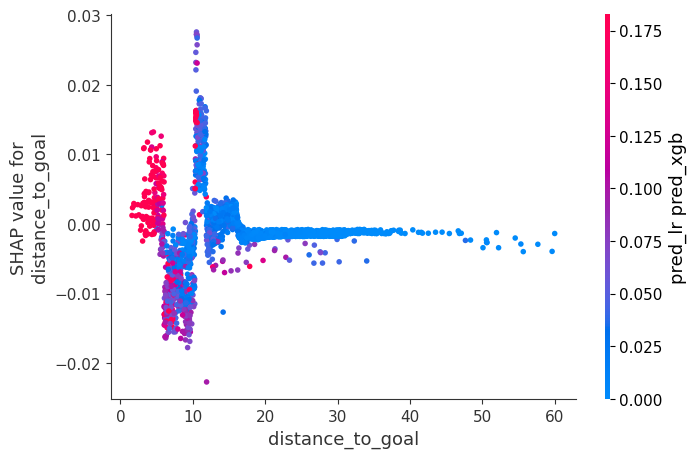

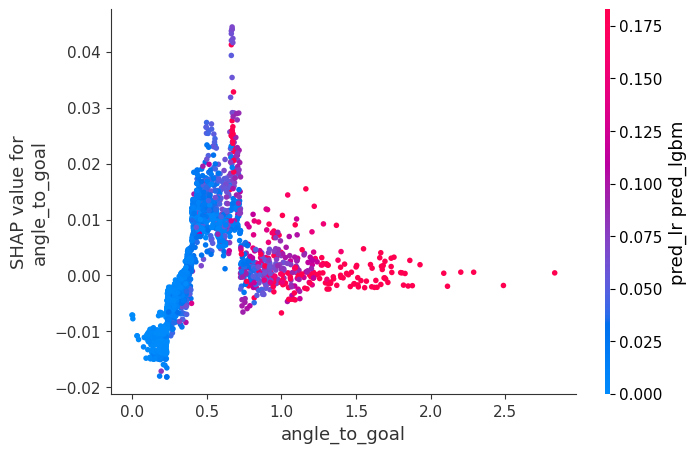

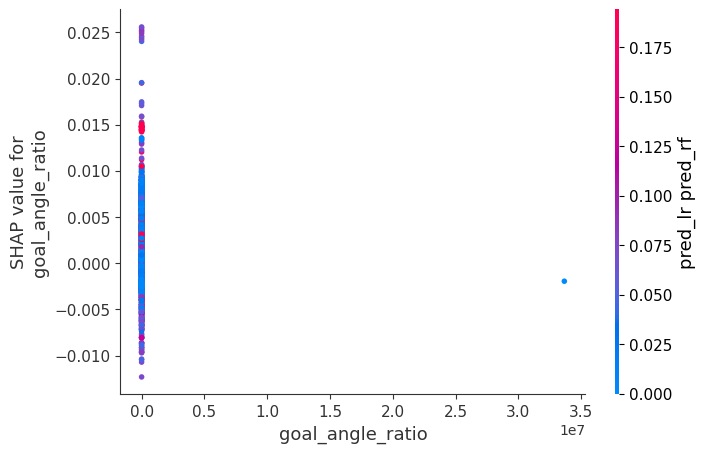

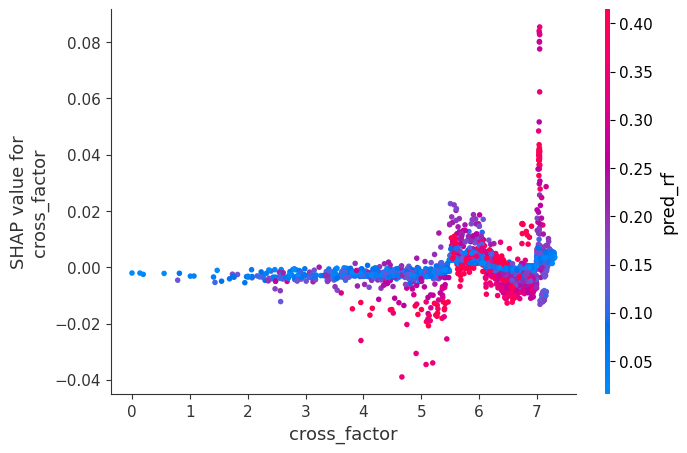

In [364]:
# =========================================================
# 🧩 SHAP Feature Importance for Final Advanced Residual Stack
# =========================================================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb

# --- 1️⃣ Prepare feature names ---
# Polynomial meta features
meta_feature_names = poly.get_feature_names_out(
    input_features=["pred_lr", "pred_rf", "pred_xgb", "pred_lgbm", "pred_nn"]
)

# Contextual + interaction features from your final code
contextual_cols = [
    "distance_to_goal", "angle_to_goal", "angle_to_goal_deg",
    "play_pattern_encoded", "is_first_half", "is_extra_time",
    "goal_angle_ratio", "pressure_zone", "cross_factor"
]

feature_names = list(meta_feature_names) + contextual_cols

# --- 2️⃣ Choose one model to explain (start with XGBoost) ---
# Re-train a compact version on full dataset for SHAP visualization
dtrain_full = xgb.DMatrix(X_resid_contextual, label=y_resid, feature_names=feature_names)

xgb_params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.04,
    "max_depth": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "lambda": 2.0,
    "alpha": 1.5,
    "seed": 42,
}
bst_resid_final = xgb.train(
    xgb_params,
    dtrain_full,
    num_boost_round=200,
    verbose_eval=False
)

# --- 3️⃣ Initialize SHAP explainer (TreeExplainer for XGBoost) ---
explainer = shap.TreeExplainer(bst_resid_final)

# --- 4️⃣ Compute SHAP values ---
shap_values = explainer.shap_values(X_resid_contextual)

# --- 5️⃣ SHAP Summary Plot (feature impact) ---
plt.title("SHAP Summary Plot – Final Residual Correction (XGBoost)", fontsize=13)
shap.summary_plot(
    shap_values,
    X_resid_contextual,
    feature_names=feature_names,
    plot_size=(11,6),
    show=True
)

# --- 6️⃣ SHAP Bar Plot (global importance) ---
plt.title("Mean |SHAP| Feature Importance – Final Residual Correction", fontsize=13)
shap.summary_plot(
    shap_values,
    X_resid_contextual,
    feature_names=feature_names,
    plot_type="bar",
    plot_size=(9,6),
    show=True
)

# --- 7️⃣ (Optional) Dependence plots for key contextual features ---
# Shows how each feature value changes the residual correction magnitude
key_features = ["distance_to_goal", "angle_to_goal", "goal_angle_ratio", "cross_factor"]

for feat in key_features:
    shap.dependence_plot(feat, shap_values, X_resid_contextual, feature_names=feature_names)


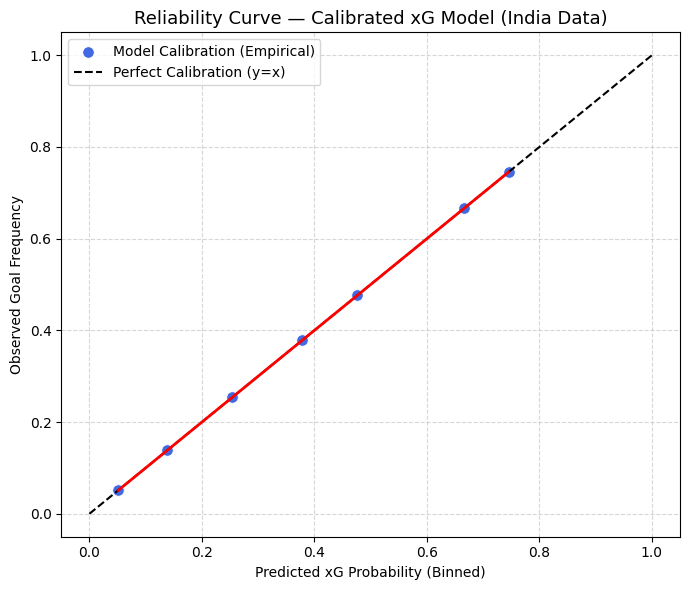

In [365]:
# ======================================================
# 🎯 Calibration Reliability Curve (India Data)
# ======================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import seaborn as sns

# ------------------------------------------------------
# ✅ True labels and calibrated predictions
# ------------------------------------------------------
# Ensure these exist in your environment
# y_goal: actual goal outcomes (0 or 1)
# prob_calibrated: isotonic-calibrated xG predictions from your final model

# Compute calibration curve (10 bins by default)
prob_true, prob_pred = calibration_curve(y_goal, prob_calibrated, n_bins=10, strategy="uniform")

# ------------------------------------------------------
# 📈 Plot reliability curve
# ------------------------------------------------------
plt.figure(figsize=(7,6))
sns.scatterplot(x=prob_pred, y=prob_true, s=70, color="royalblue", label="Model Calibration (Empirical)")
sns.lineplot(x=[0,1], y=[0,1], color="black", linestyle="--", label="Perfect Calibration (y=x)")
sns.regplot(x=prob_pred, y=prob_true, scatter=False, color="red", lowess=True, line_kws={"lw":2})

plt.title("Reliability Curve — Calibrated xG Model (India Data)", fontsize=13)
plt.xlabel("Predicted xG Probability (Binned)")
plt.ylabel("Observed Goal Frequency")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
